<a href="https://colab.research.google.com/github/ELehmann91/Thesis_Multilingual_Transferlearning/blob/master/Results_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train script
  
using prewritten fuctions and standardized data

In [1]:
import pandas as pd
from google.colab import drive, files

drive.mount('/content/gdrive')
path ='/content/gdrive/My Drive/Thesis_ecb_ecoicop'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%%capture
!pip install eli5
!git clone 'https://github.com/ELehmann91/Thesis_Multilingual_Transferlearning'

%cd Thesis_Multilingual_Transferlearning
import labeler_cc5
import coicop_model
import model_helper
import pandas as pd
import numpy as np
from tqdm import tqdm
import io

## Import Data
  
data in the normalized folder are splitted between languages (currently de fr & it) and share the same columns so they can be merged easily

In [3]:
import pandas as pd
import numpy as np

data_path = '/data/'#
#file_path = 'fra/carrfour_trans_pred.csv'
file_path = 'normalized/norm_fr.csv'
file_path2 = 'normalized/norm_de.csv'
file_path3 = 'at/norm_at.csv'
file_path4 = 'normalized/df_italiano.csv'
#file_path = 'edeka_pred.csv'

# french data
df_fr = pd.read_csv(path+data_path+file_path,sep='|',index_col=False)

# only already labeled
df_fr = df_fr[df_fr['cc5'].isna()==False]
df_fr = df_fr[df_fr['shop'].isin(['carrefour','auchan','banque_de_france'])]#,'banque_de_france','carrefour'])]
df_fr['cc5'] = df_fr['cc5'].apply(lambda x: '9999_Non-Food' if int(str(x)[0])>2 else x)
print(len(df_fr))

# german data
df_de = pd.read_csv(path+data_path+file_path2,sep='|',index_col=False)
# only already labeled
df_de = df_de[df_de['cc5'].isna()==False]
print(len(df_de))
# austrian data
df_at = pd.read_csv(path+data_path+file_path3,sep='|',index_col=False)
# only already labeled
df_at = df_at[df_at['cc5'].isna()==False]
df_de = df_de.append(df_at)
print(len(df_de))

df_it = pd.read_csv(path+data_path+file_path4,sep='|',index_col=False)
df_it = df_it[df_it['cc5'].isna()==False]
print(len(df_it))
#df_fr = df_fr.sample(frac=1).reset_index(drop=True)
#df_de = df_de.sample(frac=1).reset_index(drop=True)

22833
21903
31463
667


In [4]:
len(df_fr['cc5'][df_fr['shop'].isin(['banque_de_france'])].value_counts())

43

### Exclude non-food?

In [5]:
no_Classes = 75
exclude_non_food = False
if exclude_non_food:
    df_fr = df_fr[df_fr['cc5']!='9999_Non-Food']
    df_de = df_de[df_de['cc5']!='9999_Non-Food']
    df_at = df_it[df_it['cc5']!='9999_Non-Food']
    no_Classes = 74
    print(len(df_fr))
    print(len(df_de))
    print(len(df_at))

decide which columns should be used for training

In [6]:
var = 'name'
#df_fr['text'] = df_fr[var].fillna('unknown') 
#df_de['text'] = df_de[var].fillna('unknown') 
#df_at['text'] = df_at[var].fillna('unknown') 

var1 = 'categ'
var2 = 'words_from_url'
#df_fr['text'] = df_fr[var1].fillna('unknown')  + ' <sep> ' + df_fr[var2].fillna('unknown') 
#df_de['text'] = df_de[var1].fillna('unknown')  + ' <sep> ' + df_de[var2].fillna('unknown') 
#df_at['text'] = df_at[var1].fillna('unknown')  + ' <sep> ' + df_at[var2].fillna('unknown') 


var1 = 'categ'
var2 = 'words_from_url' 
var3 = 'name'
#var1 = 'name' 
#var2 = 'categ' 
#var3 = 'words_from_url' 
df_fr['text'] = df_fr[var1].fillna('unknown')  + ' <sep> ' + df_fr[var2].fillna('unknown')  + ' <sep> ' + df_fr[var3].fillna('unknown') 
df_de['text'] = df_de[var1].fillna('unknown')  + ' <sep> ' + df_de[var2].fillna('unknown')  + ' <sep> ' + df_de[var3].fillna('unknown') 
df_it['text'] = df_it[var1].fillna('unknown')  + ' <sep> ' + df_it[var2].fillna('unknown')  + ' <sep> ' + df_it[var3].fillna('unknown') 

#df_fr['text'] = df_fr[var1].fillna('unknown')  + df_fr[var2].fillna('unknown')  + df_fr[var3].fillna('unknown') 
#df_de['text'] = df_de[var1].fillna('unknown')  + df_de[var2].fillna('unknown')  + df_de[var3].fillna('unknown') 
#df_at['text'] = df_at[var1].fillna('unknown')  + df_at[var2].fillna('unknown')  + df_at[var3].fillna('unknown') 

#df_fr['text'] = ' <fr> ' + df_fr['name'] + ' <sep> ' + df_fr['categ'].fillna('unknown') + ' <sep> ' + df_fr['words_from_url'].fillna('unknown') + ' <sep> ' + df_fr['prod_desc'].fillna('unknown') 
#df_de['text'] = ' <de> ' + df_de['name'] + ' <sep> ' + df_de['categ'].fillna('unknown') + ' <sep> ' + df_de['words_from_url'].fillna('unknown') + ' <sep> ' + df_de['prod_desc'].fillna('unknown') 
#df_at['text'] = ' <de> ' + df_at['name'] + ' <sep> ' + df_at['categ'].fillna('unknown') + ' <sep> ' + df_at['words_from_url'].fillna('unknown') + ' <sep> ' + df_at['prod_desc'].fillna('unknown') 


In [7]:
import re
rep_dict = {'.':' ',
                        ',': ' ',
                        '&': ' ',
                        '-': ' ',
                        '/': ' ',
                        'ü': 'ue',
                        'ä': 'ae',
                        'ö': 'oe',
                        'ß': 'ss',
                        'ê': 'e',
                        'é': 'e',
                        'è': 'e',
                        'â': 'a',
                        'á': 'a',
                        'à': 'a',
                        ' a ':' ',
                        ' b ':' ',
                        ' c ':' ',
                        ' d ':' ',
                        ' e ':' ',
                        ' f ':' ',
                        ' g ':' ',
                        ' h ':' ',
                        ' i ':' ',
                        ' j ':' ',
                        ' k ':' ',
                        ' l ':' ',
                        ' m ':' ',
                        ' n ':' ',
                        ' o ':' ',
                        ' p ':' ',
                        ' q ':' ',
                        ' r ':' ',
                        ' s ':' ',
                        ' t ':' ',
                        ' u ':' ',
                        ' v ':' ',
                        ' w ':' ',
                        ' x ':' ',
                        ' y ':' ',
                        ' z ':' ',
                        'ô':'o',
                        'œ': 'ae',
                        '%': ' percent ',
                        '1': ' one ',
                        '2': ' two ',
                        '3': ' three ',
                        '4': ' four ',
                        '5': ' five ',
                        '6': ' six ',
                        '7': ' seven ',
                        '8': ' eigth ',
                        '9': ' nine ',
                        '0': ' zero ',
                        ' l ':' liter ',
                        ' ml ':' liter ',
                        'api':' ', 'offers':' ', 'images':' ', 'default':' ', 'msmall' :' ','jpg':' '
                        }

def prepro(line):
    if isinstance(line,str):
        text_str = ' '.join(str(t) for t in line.split())
        text_str = text_str.lower()
        for a,b in rep_dict.items():
            text_str = text_str.replace(a,b)
        text_str = re.sub('[^a-zäöüàáâéèêßœ<>]+', ' ', text_str)
    else: 
        text_str = str(line)
    return text_str

In [8]:
df_fr['text'] = df_fr['text'].apply(lambda x:prepro(x))
df_de['text'] = df_de['text'].apply(lambda x:prepro(x))
df_it['text'] = df_it['text'].apply(lambda x:prepro(x))

In [9]:
print('50% quantile no. of words per row french',np.quantile(df_fr['text'].apply(lambda x: len(str(x).split())),.50))
print('50% quantile no. of words per row german',np.quantile(df_de['text'].apply(lambda x: len(str(x).split())),.50))
print('50% quantile no. of words per row italian',np.quantile(df_it['text'].apply(lambda x: len(str(x).split())),.50))

print('90% quantile no. of words per row french',np.quantile(df_fr['text'].apply(lambda x: len(str(x).split())),.95))
print('90% quantile no. of words per row german',np.quantile(df_de['text'].apply(lambda x: len(str(x).split())),.95))
print('90% quantile no. of words per row italian',np.quantile(df_it['text'].apply(lambda x: len(str(x).split())),.95))

seq_len = int(max(np.quantile(df_fr['text'].apply(lambda x: len(str(x).split())),.95),np.quantile(df_de['text'].apply(lambda x: len(str(x).split())),.95)))
print('seq_len',seq_len)

50% quantile no. of words per row french 19.0
50% quantile no. of words per row german 19.0
50% quantile no. of words per row italian 11.0
90% quantile no. of words per row french 34.0
90% quantile no. of words per row german 27.0
90% quantile no. of words per row italian 18.0
seq_len 34


### Split Train Test

In [10]:
from sklearn.model_selection import train_test_split
def split_train_abs(df):
    X_train, X_val_test, y_train, y_val_test  = train_test_split(df['text'], df['cc5'], random_state=42, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test , y_val_test, train_size=.5,random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_de, X_val_de, X_test_de, y_train_de, y_val_de, y_test_de = split_train_abs(df_de)
X_train_fr, X_val_fr, X_test_fr, y_train_fr, y_val_fr, y_test_fr = split_train_abs(df_fr)

df_it = df_it[df_it['cc5'].isna()==False]

X_it = df_it['text']
y_it = df_it['cc5']
print('de',X_train_de.shape, X_val_de.shape, X_test_de.shape, y_train_de.shape, y_val_de.shape, y_test_de.shape )
print('fr',X_train_fr.shape, X_val_fr.shape, X_test_fr.shape, y_train_fr.shape, y_val_fr.shape, y_test_fr.shape )
print('it',X_it.shape, y_it.shape)

de (23597,) (3933,) (3933,) (23597,) (3933,) (3933,)
fr (17124,) (2854,) (2855,) (17124,) (2854,) (2855,)
it (667,) (667,)


### Embed

In [11]:
import pickle
french = True
german = True
italian = True

embedding_dim = 300

if french:
    fr_git_embed = pickle.load( open(path + '/embeddings/fr_slim_embed_ext.p', "rb" ) ) #fr_slim_embed_ext #fr_muse_align #fr_muse
    #fr_model = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Thesis_ecb_ecoicop/embeddings/wiki.fr.vec')
if german:
    de_git_embed = pickle.load( open(path + '/embeddings/de_slim_embed_ext.p', "rb" ) ) #de_muse
    #de_model = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Thesis_ecb_ecoicop/embeddings/wiki.de.vec')
if italian:
    it_git_embed = pickle.load( open(path + '/embeddings/it_slim_embed.p', "rb" ) ) #de_muse
    #de_model = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Thesis_ecb_ecoicop/embeddings/wiki.de.vec')

v = np.zeros(300)
v[0]=0
fr_git_embed['<sep>'] = v
de_git_embed['<sep>'] = v
it_git_embed['<sep>'] = v

print('de_git_embed',len(de_git_embed.keys()))
print('fr_git_embed',len(fr_git_embed.keys()))
print('it_git_embed',len(it_git_embed.keys()))



de_git_embed 64412
fr_git_embed 43013
it_git_embed 1984


In [12]:
for word in de_git_embed.keys():
    if word in fr_git_embed.keys():
        if word in it_git_embed.keys():
            avg_vec = (de_git_embed[word] + fr_git_embed[word] + it_git_embed[word]) /3
            de_git_embed[word] = avg_vec
            fr_git_embed[word] = avg_vec
            it_git_embed[word] = avg_vec
        else:
            avg_vec = (de_git_embed[word] + fr_git_embed[word] ) /2
            de_git_embed[word] = avg_vec
            fr_git_embed[word] = avg_vec
    elif word in it_git_embed.keys():
        avg_vec = (de_git_embed[word] + it_git_embed[word] ) /2
        de_git_embed[word] = avg_vec
        it_git_embed[word] = avg_vec

for word in fr_git_embed.keys():
    if word in it_git_embed.keys():
        avg_vec = (it_git_embed[word] + fr_git_embed[word] ) /2
        fr_git_embed[word] = avg_vec
        it_git_embed[word] = avg_vec

In [13]:
if False:
    X_train_emb_de = np.array(list(model_helper.text_to_embed(X_train_de, de_git_embed,  seq_len=seq_len)))
    X_val_emb_de = np.array(list(model_helper.text_to_embed(X_val_de,  de_git_embed,  seq_len=seq_len)))
    X_test_emb_de = np.array(list(model_helper.text_to_embed(X_test_de, de_git_embed,  seq_len=seq_len)))

    X_train_emb_fr = np.array(list(model_helper.text_to_embed(X_train_fr, fr_git_embed, seq_len=seq_len)))
    X_val_emb_fr = np.array(list(model_helper.text_to_embed(X_val_fr, fr_git_embed, seq_len=seq_len)))
    X_test_emb_fr = np.array(list(model_helper.text_to_embed(X_test_fr, fr_git_embed, seq_len=seq_len)))

    X_emb_it = np.array(list(model_helper.text_to_embed(X_it, it_git_embed,  seq_len=seq_len)))

    print('de',X_train_emb_de.shape, X_val_emb_de.shape, X_test_emb_de.shape)
    print('fr',X_train_emb_fr.shape, X_val_emb_fr.shape, X_test_emb_fr.shape)
    print('it',X_emb_it.shape)

### Padding

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer_de = Tokenizer()
tokenizer_de.fit_on_texts(X_train_de.append(X_val_de))
vocab_size_de = len(tokenizer_de.word_index) + 1

tokenizer_fr = Tokenizer()
tokenizer_fr.fit_on_texts(X_train_fr.append(X_val_fr))
vocab_size_fr = len(tokenizer_fr.word_index) + 1

tokenizer_it = Tokenizer()
tokenizer_it.fit_on_texts(X_it)
vocab_size_it = len(tokenizer_it.word_index) + 1

tokenizer_all = Tokenizer()
tokenizer_all.fit_on_texts(X_train_de.append(X_val_de).append(X_train_fr).append(X_val_fr).append(X_it))

vocab_size_all = len(tokenizer_all.word_index) + 1
print(vocab_size_de,vocab_size_fr,vocab_size_it,vocab_size_all)

16837 6977 1664 22908


In [15]:

from tensorflow.keras.preprocessing.sequence import pad_sequences
#german
X_train_tokens_de = tokenizer_all.texts_to_sequences(X_train_de)
X_val_tokens_de = tokenizer_all.texts_to_sequences(X_val_de)
X_test_tokens_de = tokenizer_all.texts_to_sequences(X_test_de)

X_train_pad_de = pad_sequences(X_train_tokens_de,maxlen=seq_len, padding='post')
X_val_pad_de = pad_sequences(X_val_tokens_de,maxlen=seq_len, padding='post')
X_test_pad_de = pad_sequences(X_test_tokens_de,maxlen=seq_len, padding='post')

#french
X_train_tokens_fr = tokenizer_all.texts_to_sequences(X_train_fr)
X_val_tokens_fr = tokenizer_all.texts_to_sequences(X_val_fr)
X_test_tokens_fr = tokenizer_all.texts_to_sequences(X_test_fr)

X_train_pad_fr = pad_sequences(X_train_tokens_fr,maxlen=seq_len, padding='post')
X_val_pad_fr = pad_sequences(X_val_tokens_fr,maxlen=seq_len, padding='post')
X_test_pad_fr = pad_sequences(X_test_tokens_fr,maxlen=seq_len, padding='post')

X_tokens_it = tokenizer_all.texts_to_sequences(X_it)
X_pad_it = pad_sequences(X_tokens_it,maxlen=seq_len, padding='post')

In [16]:
unknown = np.random.rand(embedding_dim)

def get_embed_matrix(embed,tokenizer,vocab_size,embedding_dim):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word,i in tokenizer.word_index.items():
        try:
            embedding_matrix[i] = embed[word]
        except KeyError:
            #next
            embedding_matrix[i] = unknown #np.random.rand(embedding_dim)
    return embedding_matrix

embedding_matrix_de = get_embed_matrix(de_git_embed,tokenizer_de,vocab_size_de,embedding_dim)
embedding_matrix_fr = get_embed_matrix(fr_git_embed,tokenizer_fr,vocab_size_fr,embedding_dim)
embedding_matrix_it = get_embed_matrix(it_git_embed,tokenizer_it,vocab_size_it,embedding_dim)

combine_embed = de_git_embed
combine_embed.update(fr_git_embed)
combine_embed.update(it_git_embed)
embedding_matrix_all = get_embed_matrix(combine_embed,tokenizer_all ,vocab_size_all ,embedding_dim)

In [17]:
de_fr_voc = [ w for w in list(tokenizer_de.word_index.keys()) if w in list(tokenizer_fr.word_index.keys())]
de_it_voc = [ w for w in list(tokenizer_de.word_index.keys()) if w in list(tokenizer_it.word_index.keys())]
fr_it_voc = [ w for w in list(tokenizer_fr.word_index.keys()) if w in list(tokenizer_it.word_index.keys())]

In [18]:
len(de_fr_voc), len(de_it_voc), len(fr_it_voc)

(1881, 590, 495)

### LAbel Encoding

In [19]:

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

encoder = LabelEncoder()
encoder.fit(df_de['cc5'])

def encode_label(y_):
    y__ = encoder.transform(y_)
    y_enc =tf.keras.utils.to_categorical(y__, num_classes=no_Classes, dtype="float32")
    return y_enc

y_train_enc_de = encode_label(y_train_de)
y_val_enc_de = encode_label(y_val_de)
y_test_enc_de = encode_label(y_test_de)

y_train_enc_fr = encode_label(y_train_fr)
y_val_enc_fr = encode_label(y_val_fr)
y_test_enc_fr = encode_label(y_test_fr)

y_enc_it = encode_label(y_it)

print(y_train_enc_de.shape,y_val_enc_de.shape,y_test_enc_de.shape)
print(y_train_enc_fr.shape,y_val_enc_fr.shape,y_test_enc_fr.shape)

(23597, 75) (3933, 75) (3933, 75)
(17124, 75) (2854, 75) (2855, 75)


In [20]:
def get_weigth_dict(y_train):
    weights_dict = dict(zip(y_train.value_counts().index.tolist(),list(len(y_train) / ( len(y_train.unique())  * y_train.value_counts()))))

    class_weight_dict = {}
    for n,lab in enumerate(encoder.classes_):
        try:
            class_weight_dict[n] = weights_dict[lab]
        except:
            class_weight_dict[n] = 1
    return class_weight_dict

class_weight_dict_de = get_weigth_dict(y_train_de)
class_weight_dict_fr = get_weigth_dict(y_train_fr)
class_weight_dict_de_fr = get_weigth_dict(y_train_de.append(y_train_fr))

# Single Language Classifier German

In [21]:
df_results = pd.DataFrame(columns=['model','task','metric','0','100','250','500','1000','2000','5000','10000','15000','25000','40000'])
df_results

,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [23]:
def fill_df_res(y,pred,no):
    df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='accuracy')] = round(accuracy_score(pred, y),4)
    df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='avg_recall')] = round(balanced_accuracy_score(pred, y)*len(np.unique(pred))/no_Classes,4)

In [24]:
def tf_idf_log_reg(X_train,y_train,X_test,y_test,no):
  
    idx = np.random.randint(len(X_train), size=no)

    X_train = [str(x) for x in X_train.iloc[idx]] #.replace('<','').replace('>','')
    y_train = y_train.iloc[idx]
    X_test = [str(x) for x in X_test]
    vectorizer  = TfidfVectorizer()
    vectorizer.fit(X_train)
    X_train_vec = vectorizer.transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)

    logreg = LogisticRegression(C=1,max_iter=500, solver='newton-cg')
    logreg.fit(X_train_vec, y_train)

    y_pred_test = logreg.predict(X_test_vec)
    fill_df_res(y_pred_test,y_test,no)


##LogReg

In [ ]:
task = 'slc_de'
model = 'LogReg'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000,10000,15000,25000]):
    tf_idf_log_reg(X_train_de,y_train_de,X_test_de,y_test_de,obs)

df_results[(df_results['model']==model) & (df_results['task']==task)]

## Pooling

In [ ]:
def run_avg_pool(X_train_emb,y_train_enc,X_val_emb,y_val_enc,X_test_emb,y_test,class_weight_dict,no):
    
    dropout_rate= 0.4
    filter_sizes =  [2,3,5]
    num_filters = 75
    lr = .001
    opt = Adam(lr=lr, decay=lr/150)

    idx = np.random.randint(len(X_train_emb), size=no)
                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
    pool_layer = GlobalAveragePooling1D()(embedd_seq)   

    drop_layer = Dropout(dropout_rate,name='drop')(pool_layer)
    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    de_cnn1d = Model(inputs = [input_layer], outputs = pred_layer)
    de_cnn1d.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)
    print(X_train_emb[idx,:].shape, y_train_enc[idx,:].shape)
    print(de_cnn1d.summary())
    hist = de_cnn1d.fit(x = X_train_emb[idx,:], y = y_train_enc[idx,:],\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 150, batch_size = 64, shuffle = True, class_weight = class_weight_dict,  \
                    callbacks = [early_stopping])
    #verbose =0,

    y_pred_test = pred_encode(de_cnn1d,X_test_emb)
    fill_df_res(y_pred_test,y_test,no)
    all_tests(de_cnn1d,X_test_pad_de,X_test_pad_fr,X_pad_it)

    

In [ ]:
task = 'slc_de'
model = 'avg_pool'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000,10000,15000,25000]):
     #run_CNN(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,class_weight_dict_de,obs)
     run_avg_pool(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,class_weight_dict_de,obs)
df_results[(df_results['model']==model) & (df_results['task']==task)]



  0%|          | 0/9 [00:00<?, ?it/s]

(100, 34) (100, 75)
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 34, 300)           6875100   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,897,675
Trainable params: 6,897,675
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
2/2 [==============================] - 0s 239ms/step - loss: 4.3867 - accurac



 11%|█         | 1/9 [00:14<01:52, 14.04s/it]

it 0.0255
(250, 34) (250, 75)
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 34, 300)           6875100   
_________________________________________________________________
global_average_pooling1d_3 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,897,675
Trainable params: 6,897,675
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
4/4 [==============================] - 1s 129ms/step - loss: 4.2220



 22%|██▏       | 2/9 [01:25<03:38, 31.14s/it]


de 0.6102
fr 0.0655
it 0.0195
(500, 34) (500, 75)
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 34, 300)           6875100   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,897,675
Trainable params: 6,897,675
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
8/8 [==============================] - 1s 97ms



 33%|███▎      | 3/9 [03:22<05:41, 56.97s/it]


de 0.79
fr 0.1044
it 0.0165
(1000, 34) (1000, 75)
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 34, 300)           6875100   
_________________________________________________________________
global_average_pooling1d_5 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,897,675
Trainable params: 6,897,675
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
16/16 [==============================] - 1s 83



 44%|████▍     | 4/9 [06:47<08:27, 101.45s/it]

it 0.0795
(2000, 34) (2000, 75)
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 34, 300)           6875100   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,897,675
Trainable params: 6,897,675
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
32/32 [==============================] - 3s 80ms/step - loss: 4.2



 56%|█████▌    | 5/9 [12:51<12:00, 180.19s/it]

it 0.1034
(5000, 34) (5000, 75)
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 34, 300)           6875100   
_________________________________________________________________
global_average_pooling1d_7 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,897,675
Trainable params: 6,897,675
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
79/79 [==============================] - 7s 85ms/step - loss: 4.1



 67%|██████▋   | 6/9 [19:37<12:23, 247.90s/it]

it 0.1604
(10000, 34) (10000, 75)
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 34, 300)           6875100   
_________________________________________________________________
global_average_pooling1d_8 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,897,675
Trainable params: 6,897,675
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
157/157 [==============================] - 12s 74ms/step - loss



 78%|███████▊  | 7/9 [29:15<11:33, 346.99s/it]

it 0.1154
(15000, 34) (15000, 75)
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 34, 300)           6875100   
_________________________________________________________________
global_average_pooling1d_9 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,897,675
Trainable params: 6,897,675
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
235/235 [==============================] - 17s 74ms/step - loss



 89%|████████▉ | 8/9 [39:35<07:08, 428.89s/it]


de 0.9685
fr 0.4448
it 0.1184
(25000, 34) (25000, 75)
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 34, 300)           6875100   
_________________________________________________________________
global_average_pooling1d_10  (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,897,675
Trainable params: 6,897,675
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
391/391 [==============================] -


de 0.9703
fr 0.4014
it 0.1514


100%|██████████| 9/9 [54:48<00:00, 365.39s/it]


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
4,avg_pool,slc_de,accuracy,NaN,0.0742,0.6102,0.79,0.8759,0.9212,0.9494,0.9596,0.9685,0.9703,NaN
5,avg_pool,slc_de,avg_recall,NaN,0.0555,0.3592,0.5772,0.7196,0.8061,0.8661,0.8899,0.919,0.9241,NaN


In [ ]:
def run_avg_pool(X_train_emb,y_train_enc,X_val_emb,y_val_enc,X_test_emb,y_test,class_weight_dict,no):
    
    dropout_rate= 0.1
    filter_sizes =  [2,3,5]
    num_filters = 75
    lr = .005
    opt = Adam(lr=lr, decay=lr/150)

    idx = np.random.randint(len(X_train_emb), size=no)
                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = False, mask_zero=False)(input_layer)
    pool_layer = GlobalAveragePooling1D()(embedd_seq)   

    drop_layer = Dropout(dropout_rate,name='drop')(pool_layer)
    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    de_cnn1d = Model(inputs = [input_layer], outputs = pred_layer)
    de_cnn1d.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)
    print(X_train_emb[idx,:].shape, y_train_enc[idx,:].shape)
    print(de_cnn1d.summary())
    hist = de_cnn1d.fit(x = X_train_emb[idx,:], y = y_train_enc[idx,:],\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 150, batch_size = 64, shuffle = True, class_weight = class_weight_dict,  \
                    callbacks = [early_stopping])
    #verbose =0,

    y_pred_test = pred_encode(de_cnn1d,X_test_emb)
    fill_df_res(y_pred_test,y_test,no)

    #df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='accuracy')] = round(accuracy_score(y_pred_test, y_test),4)
    #df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='avg_recall')] = round(balanced_accuracy_score(y_pred_test, y_test),4)

    all_tests(de_cnn1d,X_test_pad_de,X_test_pad_fr,X_pad_it)
    

In [ ]:
task = 'slc_de'
model = 'avg_pool_FE'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([15000,25000]):
     #run_CNN(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,class_weight_dict_de,obs)
     run_avg_pool(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,class_weight_dict_de,obs)
df_results[(df_results['model']==model) & (df_results['task']==task)]



  0%|          | 0/2 [00:00<?, ?it/s]

(15000, 34) (15000, 75)
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 34, 300)           6875100   
_________________________________________________________________
global_average_pooling1d_11  (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,897,675
Trainable params: 22,575
Non-trainable params: 6,875,100
_________________________________________________________________
None
Epoch 1/150
235/235 [==============================] - 1s 5ms/step - loss: 4.218



 50%|█████     | 1/2 [01:38<01:38, 98.72s/it]

it 0.2024
(25000, 34) (25000, 75)
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 34, 300)           6875100   
_________________________________________________________________
global_average_pooling1d_12  (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,897,675
Trainable params: 22,575
Non-trainable params: 6,875,100
_________________________________________________________________
None
Epoch 1/150
391/391 [==============================] - 2s 4ms/step - l



100%|██████████| 2/2 [05:00<00:00, 150.29s/it]

it 0.1829


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
6,avg_pool_FE,slc_de,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8843,0.895,NaN
7,avg_pool_FE,slc_de,avg_recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8044,0.8104,NaN


In [ ]:
def run_max_pool(X_train_emb,y_train_enc,X_val_emb,y_val_enc,X_test_emb,y_test,class_weight_dict,no):
    
    dropout_rate= 0.4
    filter_sizes =  [2,3,5]
    num_filters = 75
    lr = .001
    opt = Adam(lr=lr, decay=lr/150)

    idx = np.random.randint(len(X_train_emb), size=no)
                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
    pool_layer = GlobalMaxPooling1D()(embedd_seq)   

    drop_layer = Dropout(dropout_rate,name='drop')(pool_layer)
    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    de_cnn1d = Model(inputs = [input_layer], outputs = pred_layer)
    de_cnn1d.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)
    print(X_train_emb[idx,:].shape, y_train_enc[idx,:].shape)
    print(de_cnn1d.summary())
    hist = de_cnn1d.fit(x = X_train_emb[idx,:], y = y_train_enc[idx,:],\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 150, batch_size = 64, shuffle = True, class_weight = class_weight_dict,  \
                    callbacks = [early_stopping])
    #verbose =0,

    y_pred_test = pred_encode(de_cnn1d,X_test_emb)

    fill_df_res(y_pred_test,y_test,no)

    all_tests(de_cnn1d,X_test_pad_de,X_test_pad_fr,X_pad_it)
    

In [ ]:
task = 'slc_de'
model = 'max_pool'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([15000,25000]):
     #run_CNN(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,class_weight_dict_de,obs)
     run_max_pool(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,class_weight_dict_de,obs)
df_results[(df_results['model']==model) & (df_results['task']==task)]

## CNN

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPooling1D,AvgPool1D,Dropout,AveragePooling1D, Dense,Embedding, Flatten,Reshape, GlobalAveragePooling1D,MaxPool2D, Concatenate,\
Conv1D,Conv2D,BatchNormalization,Add,Masking,GlobalMaxPooling1D,LayerNormalization,Bidirectional,LSTM,GlobalAveragePooling2D,GlobalMaxPooling2D,GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.regularizers import l1,l2
import pickle
import numpy as np

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,balanced_accuracy_score

def pred_encode(model,X_test):
    y_pred_test = model.predict(X_test)
    y_pred_arg = y_pred_test.argmax(axis=1)
    y_pred_test= [encoder.classes_[y] for y in y_pred_arg]
    return y_pred_test

def all_tests(model,de,fr,it,y_it):
    y_pred_test = pred_encode(model,de)
    print()
    print('de',round(accuracy_score(y_pred_test, y_test_de),4))
    y_pred_test = pred_encode(model,fr)
    print('fr',round(accuracy_score(y_pred_test, y_test_fr),4))
    y_pred_test = pred_encode(model,it)
    print('it',round(accuracy_score(y_pred_test, y_it),4))

In [27]:
def run_CNN(X_train_emb,y_train_enc,X_val_emb,y_val_enc,X_test_emb,y_test,class_weight_dict,no):
    
    dropout_rate= 0.6
    filter_sizes =  [3,4,5]
    num_filters = 100
    lr = .0005
    opt = Adam(lr=lr, decay=lr/150)

    idx = np.random.randint(len(X_train_emb), size=no)
                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i],  activation='relu')(embedd_seq) #kernel_initializer='he_normal',
        maxpool_pool.append(MaxPooling1D(pool_size = seq_len-filter_sizes[i]+1)(conv))

    pool_layer = Concatenate(axis=1)(maxpool_pool)  
    falt_layer = Flatten(name='flat')(pool_layer)
    #dense_layer = Dense(150,activation='relu')(falt_layer)

    drop_layer = Dropout(dropout_rate,name='drop')(falt_layer)
    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    de_cnn1d = Model(inputs = [input_layer], outputs = pred_layer)
    de_cnn1d.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)
    print(X_train_emb[idx,:].shape, y_train_enc[idx,:].shape)
    print(de_cnn1d.summary())
    hist = de_cnn1d.fit(x = X_train_emb[idx,:], y = y_train_enc[idx,:], class_weight = class_weight_dict,\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 150, batch_size = 32, shuffle = True,  \
                    callbacks = [early_stopping])
    #verbose =0,

    y_pred_test = pred_encode(de_cnn1d,X_test_emb)
    fill_df_res(y_pred_test,y_test,no)
    #df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='accuracy')] = round(accuracy_score(y_pred_test, y_test),4)
    #df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='avg_recall')] = round(balanced_accuracy_score(y_pred_test, y_test),4)

    all_tests(de_cnn1d,X_test_pad_de,X_test_pad_fr,X_pad_it)
    

In [ ]:
task = 'slc_de'
model = 'CNN1D_max'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000,10000,15000,25000]):
     #run_CNN(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,class_weight_dict_de,obs)
     run_CNN(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,class_weight_dict_de,obs)
df_results[(df_results['model']==model) & (df_results['task']==task)]


  0%|          | 0/9 [00:00<?, ?it/s]

(100, 34) (100, 75)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 300)      6872400     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 32, 100)      90100       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 31, 100)      120100      embedding_1[0][0]                
________________________________________________________________________


 11%|█         | 1/9 [00:18<02:27, 18.39s/it]

it 0.0
(250, 34) (250, 75)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 300)      6872400     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 32, 100)      90100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 31, 100)      120100      embedding_2[0][0]                
_________________________________________________________________


 22%|██▏       | 2/9 [00:40<02:16, 19.51s/it]

it 0.0015
(500, 34) (500, 75)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 300)      6872400     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 32, 100)      90100       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 31, 100)      120100      embedding_3[0][0]                
______________________________________________________________

KeyboardInterrupt: ignored

In [ ]:
def run_CNN(X_train_emb,y_train_enc,X_val_emb,y_val_enc,X_test_emb,y_test,class_weight_dict,no):
    
    dropout_rate= 0.6
    filter_sizes =  [3,4,5]
    num_filters = 100
    lr = .001
    opt = Adam(lr=lr, decay=lr/150)

    idx = np.random.randint(len(X_train_emb), size=no)
                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = False, mask_zero=False)(input_layer)
    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i],  activation='relu')(embedd_seq) #kernel_initializer='he_normal',
        maxpool_pool.append(MaxPooling1D(pool_size = seq_len-filter_sizes[i]+1)(conv))

    pool_layer = Concatenate(axis=1)(maxpool_pool)  
    falt_layer = Flatten(name='flat')(pool_layer)
    #dense_layer = Dense(150,activation='relu')(falt_layer)

    drop_layer = Dropout(dropout_rate,name='drop')(falt_layer)
    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    de_cnn1d = Model(inputs = [input_layer], outputs = pred_layer)
    de_cnn1d.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)
    print(X_train_emb[idx,:].shape, y_train_enc[idx,:].shape)
    print(de_cnn1d.summary())
    hist = de_cnn1d.fit(x = X_train_emb[idx,:], y = y_train_enc[idx,:],\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 150, batch_size = 64, shuffle = True, class_weight = class_weight_dict,  \
                    callbacks = [early_stopping])
    #verbose =0,

    y_pred_test = pred_encode(de_cnn1d,X_test_emb)
    fill_df_res(y_pred_test,y_test,no)


    all_tests(de_cnn1d,X_test_pad_de,X_test_pad_fr,X_pad_it)
    

In [ ]:
task = 'slc_de'
model = 'CNN1D_WOET'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000,10000,15000,25000]):
     #run_CNN(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,class_weight_dict_de,obs)
     run_CNN(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,class_weight_dict_de,obs)
df_results[(df_results['model']==model) & (df_results['task']==task)]

  0%|          | 0/9 [00:00<?, ?it/s]

(100, 31) (100, 75)
Model: "model_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, 31, 300)      6760200     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_144 (Conv1D)             (None, 29, 100)      90100       embedding_52[0][0]               
__________________________________________________________________________________________________
conv1d_145 (Conv1D)             (None, 28, 100)      120100      embedding_52[0][0]               
_______________________________________________________________________

 11%|█         | 1/9 [00:02<00:22,  2.75s/it]


de 0.0
fr 0.0021
it 0.0
(250, 31) (250, 75)
Model: "model_92"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, 31, 300)      6760200     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_147 (Conv1D)             (None, 29, 100)      90100       embedding_53[0][0]               
__________________________________________________________________________________________________
conv1d_148 (Conv1D)             (None, 28, 100)      120100      embedding_53[0][0]               
______________________________________________

 22%|██▏       | 2/9 [00:33<01:18, 11.16s/it]


de 0.6481
fr 0.1723
it 0.2417
(500, 31) (500, 75)
Model: "model_93"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_54 (Embedding)        (None, 31, 300)      6760200     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_150 (Conv1D)             (None, 29, 100)      90100       embedding_54[0][0]               
__________________________________________________________________________________________________
conv1d_151 (Conv1D)             (None, 28, 100)      120100      embedding_54[0][0]               
________________________________________

 33%|███▎      | 3/9 [00:57<01:29, 14.90s/it]


de 0.7714
fr 0.235
it 0.3128
(1000, 31) (1000, 75)
Model: "model_94"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 31, 300)      6760200     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_153 (Conv1D)             (None, 29, 100)      90100       embedding_55[0][0]               
__________________________________________________________________________________________________
conv1d_154 (Conv1D)             (None, 28, 100)      120100      embedding_55[0][0]               
_______________________________________

 44%|████▍     | 4/9 [01:31<01:44, 20.81s/it]


de 0.8708
fr 0.29
it 0.3175
(2000, 31) (2000, 75)
Model: "model_95"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, 31, 300)      6760200     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_156 (Conv1D)             (None, 29, 100)      90100       embedding_56[0][0]               
__________________________________________________________________________________________________
conv1d_157 (Conv1D)             (None, 28, 100)      120100      embedding_56[0][0]               
________________________________________

 56%|█████▌    | 5/9 [02:01<01:34, 23.62s/it]


de 0.9108
fr 0.2795
it 0.2986
(5000, 31) (5000, 75)
Model: "model_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_57 (Embedding)        (None, 31, 300)      6760200     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_159 (Conv1D)             (None, 29, 100)      90100       embedding_57[0][0]               
__________________________________________________________________________________________________
conv1d_160 (Conv1D)             (None, 28, 100)      120100      embedding_57[0][0]               
______________________________________

 67%|██████▋   | 6/9 [02:36<01:20, 26.79s/it]


de 0.9413
fr 0.2977
it 0.3152
(10000, 31) (10000, 75)
Model: "model_97"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_58 (Embedding)        (None, 31, 300)      6760200     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_162 (Conv1D)             (None, 29, 100)      90100       embedding_58[0][0]               
__________________________________________________________________________________________________
conv1d_163 (Conv1D)             (None, 28, 100)      120100      embedding_58[0][0]               
____________________________________

 78%|███████▊  | 7/9 [03:22<01:05, 32.73s/it]


de 0.9525
fr 0.3296
it 0.3341
(15000, 31) (15000, 75)
Model: "model_98"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_59 (Embedding)        (None, 31, 300)      6760200     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_165 (Conv1D)             (None, 29, 100)      90100       embedding_59[0][0]               
__________________________________________________________________________________________________
conv1d_166 (Conv1D)             (None, 28, 100)      120100      embedding_59[0][0]               
____________________________________

 89%|████████▉ | 8/9 [04:06<00:36, 36.07s/it]


de 0.9578
fr 0.2879
it 0.3483
(25000, 31) (25000, 75)
Model: "model_99"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_60 (Embedding)        (None, 31, 300)      6760200     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_168 (Conv1D)             (None, 29, 100)      90100       embedding_60[0][0]               
__________________________________________________________________________________________________
conv1d_169 (Conv1D)             (None, 28, 100)      120100      embedding_60[0][0]               
____________________________________

100%|██████████| 9/9 [04:58<00:00, 33.17s/it]


de 0.958
fr 0.2718
it 0.3246


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000
2,CNN1D_WOET,slc_de,accuracy,NaN,0,0.6481,0.7714,0.8708,0.9108,0.9413,0.9525,0.9578,0.958
3,CNN1D_WOET,slc_de,avg_recall,NaN,0,0.5542,0.6733,0.7967,0.8576,0.8931,0.9174,0.9127,0.9152


In [ ]:
 def run_CNN(X_train_emb,y_train_enc,X_val_emb,y_val_enc,X_test_emb,y_test,class_weight_dict,no):
    
    dropout_rate= 0.7
    filter_sizes =  [2,3,5]
    num_filters = 100
    lr = .0005
    opt = Adam(lr=lr, decay=lr/150)

    idx = np.random.randint(len(X_train_emb), size=no)
                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i],  activation='relu')(embedd_seq) #kernel_initializer='he_normal',
        maxpool_pool.append(MaxPooling1D(pool_size = seq_len-filter_sizes[i]+1)(conv))

    pool_layer = Concatenate(axis=1)(maxpool_pool)  
    falt_layer = Flatten(name='flat')(pool_layer)
    #dense_layer = Dense(150,activation='relu')(falt_layer)

    drop_layer = Dropout(dropout_rate,name='drop')(falt_layer)
    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    de_cnn1d = Model(inputs = [input_layer], outputs = pred_layer)
    de_cnn1d.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)
    print(X_train_emb[idx,:].shape, y_train_enc[idx,:].shape)
    print(de_cnn1d.summary())
    hist = de_cnn1d.fit(x = X_train_emb[idx,:], y = y_train_enc[idx,:],\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 150, batch_size = 64, shuffle = True, class_weight = class_weight_dict,  \
                    callbacks = [early_stopping])
    #verbose =0,

    y_pred_test = pred_encode(de_cnn1d,X_test_emb)

    fill_df_res(y_pred_test,y_test,no)
    all_tests(de_cnn1d,X_test_pad_de,X_test_pad_fr,X_pad_it)
    

In [ ]:
task = 'slc_de'
model = 'CNN1D_345'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

obs =25000
run_CNN(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,class_weight_dict_de,obs)
df_results[(df_results['model']==model) & (df_results['task']==task)]

(25000, 31) (25000, 75)
Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, 31, 300)      6846300     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_95 (Conv1D)              (None, 29, 70)       63070       embedding_41[0][0]               
__________________________________________________________________________________________________
conv1d_96 (Conv1D)              (None, 28, 70)       84070       embedding_41[0][0]               
___________________________________________________________________

,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000
8,CNN1D_345,slc_de,accuracy,NaN,0.1876,0.6959,0.779,0.8515,0.9085,0.9255,0.9484,0.9634,0.9692
9,CNN1D_345,slc_de,avg_recall,NaN,0.4487,0.6129,0.6651,0.7404,0.8057,0.8225,0.8888,0.9157,0.9231


## RNN

In [ ]:
def run_RNN(X_train_emb,y_train_enc,X_val_emb,y_val_enc,X_test_emb,y_test,class_weight_dict,no):
    
    dropout_rate= .2
    lr = .005
    opt = Adam(lr=lr, decay=lr/150)

    idx = np.random.randint(len(X_train_emb), size=no)
                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = False, mask_zero=False)(input_layer)
    lstm_layer = Bidirectional(LSTM(256,activation = 'tanh',recurrent_activation = 'sigmoid', dropout = dropout_rate,recurrent_dropout = 0, unroll = False,use_bias = True))(embedd_seq)
    drop_layer = Dropout(dropout_rate)(lstm_layer)

    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    de_rnn = Model(inputs = [input_layer], outputs = pred_layer)
    de_rnn.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)

    hist = de_rnn.fit(x = X_train_emb[idx,:], y = y_train_enc[idx,:],\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 100, batch_size = 64, shuffle = True, class_weight = class_weight_dict,  \
                    callbacks = [early_stopping])
    #verbose =0,
    y_pred_test = pred_encode(de_rnn,X_test_emb)

    fill_df_res(y_pred_test,y_test,no)
    all_tests(de_rnn,X_test_pad_de,X_test_pad_fr,X_pad_it)

In [ ]:
task = 'slc_de'
model = 'RNN'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000,10000,15000,25000]):
     #run_RNN(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,class_weight_dict_de,obs)
     run_RNN(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,class_weight_dict_de,obs)

df_results[(df_results['model']==model) & (df_results['task']==task)]




  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/100
2/2 [==============================] - 1s 445ms/step - loss: 3.8426 - accuracy: 0.0100 - val_loss: 4.7085 - val_accuracy: 0.0036
Epoch 2/100
2/2 [==============================] - 0s 178ms/step - loss: 3.4206 - accuracy: 0.0100 - val_loss: 4.3288 - val_accuracy: 0.0056
Epoch 3/100
2/2 [==============================] - 0s 180ms/step - loss: 3.0390 - accuracy: 0.0200 - val_loss: 4.4322 - val_accuracy: 0.0086
Epoch 4/100
2/2 [==============================] - 0s 171ms/step - loss: 2.8171 - accuracy: 0.0300 - val_loss: 4.7518 - val_accuracy: 0.0211
Epoch 5/100
2/2 [==============================] - 0s 173ms/step - loss: 2.6519 - accuracy: 0.0500 - val_loss: 4.6468 - val_accuracy: 0.0371
Epoch 6/100
2/2 [==============================] - 0s 179ms/step - loss: 2.4769 - accuracy: 0.0900 - val_loss: 4.8137 - val_accuracy: 0.0554
Epoch 7/100
2/2 [==============================] - 0s 185ms/step - loss: 2.3530 - accuracy: 0.1600 - val_loss: 4.6145 - val_accuracy: 0.0392

de 0.0325





 11%|█         | 1/9 [00:07<01:03,  7.91s/it]

fr 0.0091
it 0.015
Epoch 1/100
4/4 [==============================] - 1s 236ms/step - loss: 4.6376 - accuracy: 0.0080 - val_loss: 4.4319 - val_accuracy: 0.0107
Epoch 2/100
4/4 [==============================] - 0s 92ms/step - loss: 4.3216 - accuracy: 0.0240 - val_loss: 4.3898 - val_accuracy: 0.0175
Epoch 3/100
4/4 [==============================] - 0s 93ms/step - loss: 3.8234 - accuracy: 0.0440 - val_loss: 4.4058 - val_accuracy: 0.0369
Epoch 4/100
4/4 [==============================] - 0s 97ms/step - loss: 3.6946 - accuracy: 0.0640 - val_loss: 4.1748 - val_accuracy: 0.0506
Epoch 5/100
4/4 [==============================] - 0s 95ms/step - loss: 3.3379 - accuracy: 0.0920 - val_loss: 4.1069 - val_accuracy: 0.0501
Epoch 6/100
4/4 [==============================] - 0s 91ms/step - loss: 3.0063 - accuracy: 0.1080 - val_loss: 4.1625 - val_accuracy: 0.0503
Epoch 7/100
4/4 [==============================] - 0s 92ms/step - loss: 2.7740 - accuracy: 0.1480 - val_loss: 3.9606 - val_accuracy: 0.0842





 22%|██▏       | 2/9 [00:22<01:10, 10.06s/it]

fr 0.0683
it 0.033
Epoch 1/100
8/8 [==============================] - 1s 116ms/step - loss: 4.0793 - accuracy: 0.0160 - val_loss: 4.2525 - val_accuracy: 0.0272
Epoch 2/100
8/8 [==============================] - 0s 51ms/step - loss: 3.6531 - accuracy: 0.0580 - val_loss: 3.9270 - val_accuracy: 0.0595
Epoch 3/100
8/8 [==============================] - 0s 53ms/step - loss: 3.3098 - accuracy: 0.1000 - val_loss: 3.8932 - val_accuracy: 0.0674
Epoch 4/100
8/8 [==============================] - 0s 52ms/step - loss: 2.9142 - accuracy: 0.1220 - val_loss: 3.6532 - val_accuracy: 0.1192
Epoch 5/100
8/8 [==============================] - 0s 50ms/step - loss: 2.5547 - accuracy: 0.3120 - val_loss: 3.5133 - val_accuracy: 0.1704
Epoch 6/100
8/8 [==============================] - 0s 52ms/step - loss: 2.1681 - accuracy: 0.3160 - val_loss: 3.1996 - val_accuracy: 0.2754
Epoch 7/100
8/8 [==============================] - 0s 52ms/step - loss: 1.9055 - accuracy: 0.4380 - val_loss: 2.6819 - val_accuracy: 0.4180





 33%|███▎      | 3/9 [00:39<01:12, 12.14s/it]

fr 0.1093
it 0.1409
Epoch 1/100
16/16 [==============================] - 1s 68ms/step - loss: 4.7643 - accuracy: 0.0020 - val_loss: 4.1336 - val_accuracy: 0.0196
Epoch 2/100
16/16 [==============================] - 1s 32ms/step - loss: 4.2638 - accuracy: 0.0250 - val_loss: 4.0490 - val_accuracy: 0.0290
Epoch 3/100
16/16 [==============================] - 1s 33ms/step - loss: 3.7863 - accuracy: 0.0510 - val_loss: 3.4867 - val_accuracy: 0.1233
Epoch 4/100
16/16 [==============================] - 1s 35ms/step - loss: 3.2111 - accuracy: 0.1490 - val_loss: 3.1580 - val_accuracy: 0.2532
Epoch 5/100
16/16 [==============================] - 1s 34ms/step - loss: 2.8993 - accuracy: 0.2950 - val_loss: 3.0676 - val_accuracy: 0.1381
Epoch 6/100
16/16 [==============================] - 1s 35ms/step - loss: 2.3909 - accuracy: 0.3230 - val_loss: 2.7285 - val_accuracy: 0.3092
Epoch 7/100
16/16 [==============================] - 1s 34ms/step - loss: 1.9207 - accuracy: 0.4860 - val_loss: 2.2305 - val_acc




 44%|████▍     | 4/9 [00:59<01:12, 14.42s/it]

fr 0.0799
it 0.1484
Epoch 1/100
32/32 [==============================] - 1s 39ms/step - loss: 4.2112 - accuracy: 0.0330 - val_loss: 3.7866 - val_accuracy: 0.0974
Epoch 2/100
32/32 [==============================] - 1s 21ms/step - loss: 3.3087 - accuracy: 0.3060 - val_loss: 2.2492 - val_accuracy: 0.4246
Epoch 3/100
32/32 [==============================] - 1s 20ms/step - loss: 2.3193 - accuracy: 0.4805 - val_loss: 2.0571 - val_accuracy: 0.4668
Epoch 4/100
32/32 [==============================] - 1s 21ms/step - loss: 1.7861 - accuracy: 0.6095 - val_loss: 1.4375 - val_accuracy: 0.6206
Epoch 5/100
32/32 [==============================] - 1s 21ms/step - loss: 1.3719 - accuracy: 0.6890 - val_loss: 1.1732 - val_accuracy: 0.6901
Epoch 6/100
32/32 [==============================] - 1s 21ms/step - loss: 1.2587 - accuracy: 0.7280 - val_loss: 1.1037 - val_accuracy: 0.6903
Epoch 7/100
32/32 [==============================] - 1s 20ms/step - loss: 1.0679 - accuracy: 0.7520 - val_loss: 0.9801 - val_acc




 56%|█████▌    | 5/9 [01:23<01:09, 17.26s/it]

fr 0.1187
it 0.2114
Epoch 1/100
79/79 [==============================] - 2s 21ms/step - loss: 3.7297 - accuracy: 0.1770 - val_loss: 2.5483 - val_accuracy: 0.4302
Epoch 2/100
79/79 [==============================] - 1s 15ms/step - loss: 2.1480 - accuracy: 0.5692 - val_loss: 1.1468 - val_accuracy: 0.6827
Epoch 3/100
79/79 [==============================] - 1s 15ms/step - loss: 1.5105 - accuracy: 0.6924 - val_loss: 1.0671 - val_accuracy: 0.7338
Epoch 4/100
79/79 [==============================] - 1s 15ms/step - loss: 1.1121 - accuracy: 0.7730 - val_loss: 0.7832 - val_accuracy: 0.7790
Epoch 5/100
79/79 [==============================] - 1s 15ms/step - loss: 0.9493 - accuracy: 0.8064 - val_loss: 0.8665 - val_accuracy: 0.7773
Epoch 6/100
79/79 [==============================] - 1s 15ms/step - loss: 0.8273 - accuracy: 0.8124 - val_loss: 0.6380 - val_accuracy: 0.8230
Epoch 7/100
79/79 [==============================] - 1s 15ms/step - loss: 0.7292 - accuracy: 0.8532 - val_loss: 0.5683 - val_acc




 67%|██████▋   | 6/9 [01:53<01:03, 21.13s/it]

fr 0.1303
it 0.2309
Epoch 1/100
157/157 [==============================] - 3s 16ms/step - loss: 2.7737 - accuracy: 0.3710 - val_loss: 1.2610 - val_accuracy: 0.6949
Epoch 2/100
157/157 [==============================] - 2s 13ms/step - loss: 1.3073 - accuracy: 0.7475 - val_loss: 0.6768 - val_accuracy: 0.8241
Epoch 3/100
157/157 [==============================] - 2s 13ms/step - loss: 0.9866 - accuracy: 0.8139 - val_loss: 0.6061 - val_accuracy: 0.8314
Epoch 4/100
157/157 [==============================] - 2s 13ms/step - loss: 0.7778 - accuracy: 0.8483 - val_loss: 0.5220 - val_accuracy: 0.8556
Epoch 5/100
157/157 [==============================] - 2s 13ms/step - loss: 0.6810 - accuracy: 0.8638 - val_loss: 0.4754 - val_accuracy: 0.8632
Epoch 6/100
157/157 [==============================] - 2s 13ms/step - loss: 0.6029 - accuracy: 0.8789 - val_loss: 0.4417 - val_accuracy: 0.8851
Epoch 7/100
157/157 [==============================] - 2s 13ms/step - loss: 0.5399 - accuracy: 0.8910 - val_loss: 0.




 78%|███████▊  | 7/9 [02:52<01:05, 32.55s/it]

fr 0.1821
it 0.2294
Epoch 1/100
235/235 [==============================] - 3s 15ms/step - loss: 2.4767 - accuracy: 0.4852 - val_loss: 0.8770 - val_accuracy: 0.7719
Epoch 2/100
235/235 [==============================] - 3s 12ms/step - loss: 1.1423 - accuracy: 0.7927 - val_loss: 0.6769 - val_accuracy: 0.8035
Epoch 3/100
235/235 [==============================] - 3s 12ms/step - loss: 0.8385 - accuracy: 0.8441 - val_loss: 0.5679 - val_accuracy: 0.8380
Epoch 4/100
235/235 [==============================] - 3s 12ms/step - loss: 0.6813 - accuracy: 0.8756 - val_loss: 0.4653 - val_accuracy: 0.8719
Epoch 5/100
235/235 [==============================] - 3s 12ms/step - loss: 0.4839 - accuracy: 0.9040 - val_loss: 0.4204 - val_accuracy: 0.8777
Epoch 6/100
235/235 [==============================] - 3s 12ms/step - loss: 0.4436 - accuracy: 0.9113 - val_loss: 0.3743 - val_accuracy: 0.9064
Epoch 7/100
235/235 [==============================] - 3s 12ms/step - loss: 0.3668 - accuracy: 0.9217 - val_loss: 0.




 89%|████████▉ | 8/9 [04:06<00:44, 44.88s/it]

fr 0.1037
it 0.2099
Epoch 1/100
391/391 [==============================] - 5s 13ms/step - loss: 1.9785 - accuracy: 0.5859 - val_loss: 0.6871 - val_accuracy: 0.8241
Epoch 2/100
391/391 [==============================] - 4s 11ms/step - loss: 0.8309 - accuracy: 0.8390 - val_loss: 0.4482 - val_accuracy: 0.8764
Epoch 3/100
391/391 [==============================] - 4s 11ms/step - loss: 0.5266 - accuracy: 0.8958 - val_loss: 0.4331 - val_accuracy: 0.8912
Epoch 4/100
391/391 [==============================] - 4s 11ms/step - loss: 0.4070 - accuracy: 0.9128 - val_loss: 0.3374 - val_accuracy: 0.9006
Epoch 5/100
391/391 [==============================] - 4s 11ms/step - loss: 0.3196 - accuracy: 0.9321 - val_loss: 0.3311 - val_accuracy: 0.9067
Epoch 6/100
391/391 [==============================] - 4s 11ms/step - loss: 0.2529 - accuracy: 0.9472 - val_loss: 0.3120 - val_accuracy: 0.9219
Epoch 7/100
391/391 [==============================] - 4s 11ms/step - loss: 0.2216 - accuracy: 0.9498 - val_loss: 0.




100%|██████████| 9/9 [05:14<00:00, 34.93s/it]

fr 0.1352
it 0.2189


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
8,RNN,slc_de,accuracy,NaN,0.0325,0.4973,0.745,0.7613,0.8752,0.923,0.9451,0.9527,0.9464,NaN
9,RNN,slc_de,avg_recall,NaN,0.043,0.2888,0.5145,0.597,0.7455,0.8338,0.8722,0.8921,0.888,NaN


In [ ]:
task = 'slc_de'
df_results[(df_results['task']==task)]

,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000
0,LogReg,slc_de,accuracy,NaN,0.2747,0.4469,0.5665,0.7278,0.8264,0.8804,0.9094,0.9286,0.9387
1,LogReg,slc_de,avg_recall,NaN,0.7303,0.7093,0.7707,0.7983,0.8695,0.8924,0.9067,0.9255,0.9364
2,avg_pool,slc_de,accuracy,NaN,0.0101,0.0101,0.7071,0.8449,0.8934,0.9311,0.9478,0.9525,0.9554
3,avg_pool,slc_de,avg_recall,NaN,0.1202,0.3464,0.6924,0.7751,0.8209,0.8888,0.9139,0.9208,0.9281
4,CNN1D_max,slc_de,accuracy,NaN,0.0033,0.6546,0.7626,0.8579,0.8985,0.9416,0.9551,0.9569,0.9561
5,CNN1D_max,slc_de,avg_recall,NaN,0.0033,0.6697,0.723,0.8214,0.8564,0.9248,0.9369,0.9305,0.9372
6,RNN,slc_de,accuracy,NaN,0.0671,0.3766,0.6354,0.7688,0.8706,0.905,0.9217,0.9119,0.938
7,RNN,slc_de,avg_recall,NaN,0.0984,0.4014,0.6026,0.7121,0.8312,0.8696,0.8846,0.8713,0.9082


# Single Language Classifier French

##LogReg

In [ ]:
task = 'slc_fr'
model = 'LogReg'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)
    
for obs in tqdm([100,250,500,1000,2000,5000,10000,15000]):
    tf_idf_log_reg(X_train_fr,y_train_fr,X_test_fr,y_test_fr,obs)

df_results[(df_results['model']==model) & (df_results['task']==task)]




  0%|          | 0/8 [00:00<?, ?it/s]


 12%|█▎        | 1/8 [00:00<00:00,  7.96it/s]


 25%|██▌       | 2/8 [00:00<00:01,  5.75it/s]


 38%|███▊      | 3/8 [00:00<00:01,  3.61it/s]


 50%|█████     | 4/8 [00:01<00:01,  2.01it/s]


 62%|██████▎   | 5/8 [00:03<00:02,  1.09it/s]


 75%|███████▌  | 6/8 [00:08<00:04,  2.17s/it]


 88%|████████▊ | 7/8 [00:19<00:04,  4.78s/it]


100%|██████████| 8/8 [00:37<00:00,  4.70s/it]


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
10,LogReg,slc_fr,accuracy,NaN,0.4841,0.5846,0.7156,0.7867,0.8508,0.9075,0.918,0.937,NaN,NaN
11,LogReg,slc_fr,avg_recall,NaN,0.1019,0.1692,0.2427,0.3362,0.4519,0.592,0.6549,0.7182,NaN,NaN


## Pooling

In [ ]:
task = 'slc_fr'
model = 'avg_pool'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000,10000,15000]):
     #run_CNN(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,class_weight_dict_de,obs)
     run_avg_pool(X_train_pad_fr,y_train_enc_fr,X_val_pad_fr,y_val_enc_fr,X_test_pad_fr,y_test_fr,class_weight_dict_fr,obs)
df_results[(df_results['model']==model) & (df_results['task']==task)]




  0%|          | 0/8 [00:00<?, ?it/s]

(100, 34) (100, 75)
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 34, 300)           6872400   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,894,975
Trainable params: 6,894,975
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
2/2 [==============================] - 0s 157ms/step - loss: 5.6611 - accuracy




 12%|█▎        | 1/8 [00:03<00:22,  3.28s/it]


de 0.0137
fr 0.0357
it 0.0015
(250, 34) (250, 75)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 34, 300)           6872400   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,894,975
Trainable params: 6,894,975
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
4/4 [==============================] - 0s 116ms




 25%|██▌       | 2/8 [00:46<01:31, 15.27s/it]


de 0.0496
fr 0.7653
it 0.012
(500, 34) (500, 75)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 34, 300)           6872400   
_________________________________________________________________
global_average_pooling1d_3 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,894,975
Trainable params: 6,894,975
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
8/8 [==============================] - 1s 92ms/s




 38%|███▊      | 3/8 [01:12<01:32, 18.43s/it]


de 0.0829
fr 0.8207
it 0.0075
(1000, 34) (1000, 75)
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 34, 300)           6872400   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,894,975
Trainable params: 6,894,975
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
16/16 [==============================] - 1s 




 50%|█████     | 4/8 [01:40<01:24, 21.23s/it]


de 0.1192
fr 0.8704
it 0.0075
(2000, 34) (2000, 75)
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 34, 300)           6872400   
_________________________________________________________________
global_average_pooling1d_5 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,894,975
Trainable params: 6,894,975
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
32/32 [==============================] - 2s 




 62%|██████▎   | 5/8 [02:16<01:17, 25.87s/it]


de 0.1259
fr 0.9079
it 0.03
(5000, 34) (5000, 75)
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 34, 300)           6872400   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,894,975
Trainable params: 6,894,975
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
79/79 [==============================] - 6s 72




 75%|███████▌  | 6/8 [03:20<01:14, 37.26s/it]


de 0.2001
fr 0.9394
it 0.075
(10000, 34) (10000, 75)
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 34, 300)           6872400   
_________________________________________________________________
global_average_pooling1d_7 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,894,975
Trainable params: 6,894,975
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
157/157 [==============================] - 




 88%|████████▊ | 7/8 [05:02<00:56, 56.52s/it]


de 0.2207
fr 0.9503
it 0.1049
(15000, 34) (15000, 75)
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 34, 300)           6872400   
_________________________________________________________________
global_average_pooling1d_8 ( (None, 300)               0         
_________________________________________________________________
drop (Dropout)               (None, 300)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                22575     
Total params: 6,894,975
Trainable params: 6,894,975
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
235/235 [==============================] -




100%|██████████| 8/8 [07:32<00:00, 84.68s/it]


de 0.1729
fr 0.9664
it 0.0885


100%|██████████| 8/8 [07:32<00:00, 56.56s/it]


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
0,avg_pool,slc_fr,accuracy,NaN,0.0357,0.7653,0.8207,0.8704,0.9079,0.9394,0.9503,0.9664,NaN,NaN
1,avg_pool,slc_fr,avg_recall,NaN,0.053,0.4174,0.4927,0.5704,0.6615,0.7719,0.7746,0.8275,NaN,NaN


##CNN

In [ ]:
task = 'slc_fr'
model = 'CNN1D'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000,10000,15000]):
     run_CNN(X_train_pad_fr,y_train_enc_fr,X_val_pad_fr,y_val_enc_fr,X_test_pad_fr,y_test_fr,class_weight_dict_fr,obs)

df_results[(df_results['model']==model) & (df_results['task']==task)]

  0%|          | 0/8 [00:00<?, ?it/s]

(100, 34) (100, 75)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 300)      6875100     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 32, 100)      90100       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 31, 100)      120100      embedding[0][0]                  
__________________________________________________________________________

 12%|█▎        | 1/8 [00:21<02:32, 21.83s/it]

it 0.0015
(250, 34) (250, 75)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 300)      6875100     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 32, 100)      90100       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 31, 100)      120100      embedding_1[0][0]                
______________________________________________________________

 25%|██▌       | 2/8 [00:46<02:16, 22.75s/it]

it 0.003
(500, 34) (500, 75)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 300)      6875100     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 32, 100)      90100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 31, 100)      120100      embedding_2[0][0]                
_______________________________________________________________

 38%|███▊      | 3/8 [06:34<10:01, 120.24s/it]

it 0.1169
(1000, 34) (1000, 75)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 300)      6875100     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 32, 100)      90100       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 31, 100)      120100      embedding_3[0][0]                
____________________________________________________________

 50%|█████     | 4/8 [12:59<13:19, 199.78s/it]

it 0.1004
(2000, 34) (2000, 75)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 34, 300)      6875100     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 32, 100)      90100       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 31, 100)      120100      embedding_4[0][0]                
____________________________________________________________

 62%|██████▎   | 5/8 [19:37<12:57, 259.19s/it]

it 0.1799
(5000, 34) (5000, 75)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 34, 300)      6875100     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 32, 100)      90100       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 31, 100)      120100      embedding_5[0][0]                
____________________________________________________________

 75%|███████▌  | 6/8 [30:26<12:32, 376.18s/it]

it 0.2069
(10000, 34) (10000, 75)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 34, 300)      6875100     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 32, 100)      90100       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 31, 100)      120100      embedding_6[0][0]                
__________________________________________________________

 88%|████████▊ | 7/8 [46:47<09:17, 557.45s/it]

it 0.2249
(15000, 34) (15000, 75)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 34, 300)      6875100     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 32, 100)      90100       embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 31, 100)      120100      embedding_7[0][0]                
__________________________________________________________

100%|██████████| 8/8 [1:01:24<00:00, 460.51s/it]

it 0.1994


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
0,CNN1D,slc_fr,accuracy,NaN,0.0004,0.0042,0.828,0.8729,0.9026,0.9356,0.9496,0.9615,NaN,NaN
1,CNN1D,slc_fr,avg_recall,NaN,0.0133,0.0164,0.4694,0.5792,0.6432,0.7488,0.8025,0.8347,NaN,NaN


## RNN

In [ ]:
task = 'slc_fr'
model = 'RNN'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000,10000,15000]):
     run_RNN(X_train_pad_fr,y_train_enc_fr,X_val_pad_fr,y_val_enc_fr,X_test_pad_fr,y_test_fr,class_weight_dict_fr,obs)

df_results[(df_results['model']==model) & (df_results['task']==task)]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/100
2/2 [==============================] - 7s 3s/step - loss: 3.3244 - accuracy: 0.0200 - val_loss: 4.4377 - val_accuracy: 0.0025
Epoch 2/100
2/2 [==============================] - 6s 3s/step - loss: 3.1207 - accuracy: 0.0000e+00 - val_loss: 4.0022 - val_accuracy: 0.0081
Epoch 3/100
2/2 [==============================] - 6s 3s/step - loss: 2.6763 - accuracy: 0.0300 - val_loss: 4.2977 - val_accuracy: 0.0035
Epoch 4/100
2/2 [==============================] - 6s 3s/step - loss: 2.3951 - accuracy: 0.0400 - val_loss: 4.5412 - val_accuracy: 0.0053
Epoch 5/100
2/2 [==============================] - 6s 3s/step - loss: 2.2903 - accuracy: 0.0400 - val_loss: 4.4361 - val_accuracy: 0.0067
Epoch 6/100
2/2 [==============================] - 6s 3s/step - loss: 2.1499 - accuracy: 0.0400 - val_loss: 4.4353 - val_accuracy: 0.0126
Epoch 7/100
2/2 [==============================] - 6s 3s/step - loss: 2.0535 - accuracy: 0.0800 - val_loss: 4.5737 - val_accuracy: 0.0116

de 0.0074
fr 0.0119


 12%|█▎        | 1/8 [01:15<08:51, 75.99s/it]

it 0.0015
Epoch 1/100
4/4 [==============================] - 7s 2s/step - loss: 4.0770 - accuracy: 0.0000e+00 - val_loss: 4.1683 - val_accuracy: 0.0070
Epoch 2/100
4/4 [==============================] - 7s 2s/step - loss: 3.6812 - accuracy: 0.0040 - val_loss: 4.1312 - val_accuracy: 0.0081
Epoch 3/100
4/4 [==============================] - 7s 2s/step - loss: 3.3367 - accuracy: 0.0320 - val_loss: 3.9392 - val_accuracy: 0.0119
Epoch 4/100
4/4 [==============================] - 7s 2s/step - loss: 3.0868 - accuracy: 0.0680 - val_loss: 3.9945 - val_accuracy: 0.0368
Epoch 5/100
4/4 [==============================] - 7s 2s/step - loss: 2.7704 - accuracy: 0.0800 - val_loss: 4.1935 - val_accuracy: 0.0158
Epoch 6/100
4/4 [==============================] - 7s 2s/step - loss: 2.5162 - accuracy: 0.0960 - val_loss: 3.8751 - val_accuracy: 0.0925
Epoch 7/100
4/4 [==============================] - 7s 2s/step - loss: 2.1597 - accuracy: 0.1920 - val_loss: 4.0906 - val_accuracy: 0.1076
Epoch 8/100
4/4 [===

 25%|██▌       | 2/8 [04:22<10:55, 109.26s/it]

it 0.0345
Epoch 1/100
8/8 [==============================] - 9s 1s/step - loss: 4.1707 - accuracy: 0.0120 - val_loss: 4.1363 - val_accuracy: 0.0067
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 3.8398 - accuracy: 0.0320 - val_loss: 3.7785 - val_accuracy: 0.0424
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 3.4585 - accuracy: 0.0480 - val_loss: 3.7389 - val_accuracy: 0.0291
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 3.1379 - accuracy: 0.0640 - val_loss: 3.8239 - val_accuracy: 0.0736
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 2.8717 - accuracy: 0.0900 - val_loss: 3.7633 - val_accuracy: 0.0224
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 2.6613 - accuracy: 0.1140 - val_loss: 3.5876 - val_accuracy: 0.1391
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 2.3521 - accuracy: 0.1740 - val_loss: 3.3916 - val_accuracy: 0.1230
Epoch 8/100
8/8 [=======

 38%|███▊      | 3/8 [08:40<12:48, 153.67s/it]

it 0.1169
Epoch 1/100
16/16 [==============================] - 12s 758ms/step - loss: 4.5506 - accuracy: 0.0070 - val_loss: 4.1123 - val_accuracy: 0.0158
Epoch 2/100
16/16 [==============================] - 11s 715ms/step - loss: 4.0682 - accuracy: 0.0800 - val_loss: 3.5533 - val_accuracy: 0.1009
Epoch 3/100
16/16 [==============================] - 11s 718ms/step - loss: 3.5436 - accuracy: 0.1290 - val_loss: 3.4087 - val_accuracy: 0.1854
Epoch 4/100
16/16 [==============================] - 12s 719ms/step - loss: 2.8197 - accuracy: 0.2680 - val_loss: 3.1713 - val_accuracy: 0.1626
Epoch 5/100
16/16 [==============================] - 11s 716ms/step - loss: 2.3627 - accuracy: 0.3470 - val_loss: 2.5625 - val_accuracy: 0.3315
Epoch 6/100
16/16 [==============================] - 11s 713ms/step - loss: 1.8029 - accuracy: 0.4350 - val_loss: 2.3020 - val_accuracy: 0.4019
Epoch 7/100
16/16 [==============================] - 11s 716ms/step - loss: 1.4161 - accuracy: 0.5400 - val_loss: 2.0313 - val

 50%|█████     | 4/8 [14:33<14:14, 213.55s/it]

it 0.0975
Epoch 1/100
32/32 [==============================] - 19s 592ms/step - loss: 4.1069 - accuracy: 0.0440 - val_loss: 3.5692 - val_accuracy: 0.1468
Epoch 2/100
32/32 [==============================] - 19s 594ms/step - loss: 3.5897 - accuracy: 0.1490 - val_loss: 3.2465 - val_accuracy: 0.2200
Epoch 3/100
32/32 [==============================] - 18s 552ms/step - loss: 2.8546 - accuracy: 0.3045 - val_loss: 2.4476 - val_accuracy: 0.3584
Epoch 4/100
32/32 [==============================] - 18s 554ms/step - loss: 2.2175 - accuracy: 0.4480 - val_loss: 1.7863 - val_accuracy: 0.5617
Epoch 5/100
32/32 [==============================] - 18s 559ms/step - loss: 1.8764 - accuracy: 0.5590 - val_loss: 1.7694 - val_accuracy: 0.5441
Epoch 6/100
32/32 [==============================] - 18s 553ms/step - loss: 1.4837 - accuracy: 0.6435 - val_loss: 1.4543 - val_accuracy: 0.6748
Epoch 7/100
32/32 [==============================] - 18s 575ms/step - loss: 1.2461 - accuracy: 0.7030 - val_loss: 1.5963 - val

 62%|██████▎   | 5/8 [22:15<14:24, 288.20s/it]

it 0.1469
Epoch 1/100
79/79 [==============================] - 38s 476ms/step - loss: 3.9002 - accuracy: 0.1538 - val_loss: 2.6580 - val_accuracy: 0.3886
Epoch 2/100
79/79 [==============================] - 37s 465ms/step - loss: 2.5462 - accuracy: 0.4438 - val_loss: 1.6531 - val_accuracy: 0.5676
Epoch 3/100
79/79 [==============================] - 37s 472ms/step - loss: 1.7330 - accuracy: 0.6002 - val_loss: 1.2400 - val_accuracy: 0.6542
Epoch 4/100
79/79 [==============================] - 38s 479ms/step - loss: 1.3257 - accuracy: 0.7408 - val_loss: 0.9673 - val_accuracy: 0.7596
Epoch 5/100
79/79 [==============================] - 39s 488ms/step - loss: 1.1212 - accuracy: 0.7938 - val_loss: 0.8132 - val_accuracy: 0.8020
Epoch 6/100
79/79 [==============================] - 37s 472ms/step - loss: 0.9477 - accuracy: 0.8056 - val_loss: 0.7661 - val_accuracy: 0.8115
Epoch 7/100
79/79 [==============================] - 37s 470ms/step - loss: 0.7346 - accuracy: 0.8490 - val_loss: 0.8209 - val

 75%|███████▌  | 6/8 [34:07<13:50, 415.28s/it]

it 0.2429
Epoch 1/100
157/157 [==============================] - 73s 466ms/step - loss: 3.0852 - accuracy: 0.3172 - val_loss: 1.6981 - val_accuracy: 0.5879
Epoch 2/100
157/157 [==============================] - 71s 452ms/step - loss: 1.6292 - accuracy: 0.6806 - val_loss: 1.2473 - val_accuracy: 0.6861
Epoch 3/100
157/157 [==============================] - 72s 457ms/step - loss: 1.1827 - accuracy: 0.7778 - val_loss: 0.7141 - val_accuracy: 0.8125
Epoch 4/100
157/157 [==============================] - 71s 452ms/step - loss: 0.9373 - accuracy: 0.8210 - val_loss: 0.7075 - val_accuracy: 0.8181
Epoch 5/100
157/157 [==============================] - 69s 443ms/step - loss: 0.7360 - accuracy: 0.8648 - val_loss: 0.5519 - val_accuracy: 0.8626
Epoch 6/100
157/157 [==============================] - 71s 452ms/step - loss: 0.6127 - accuracy: 0.8846 - val_loss: 0.4986 - val_accuracy: 0.8802
Epoch 7/100
157/157 [==============================] - 69s 441ms/step - loss: 0.5405 - accuracy: 0.8949 - val_loss

 88%|████████▊ | 7/8 [53:40<10:42, 642.69s/it]

it 0.2234
Epoch 1/100
235/235 [==============================] - 102s 435ms/step - loss: 2.6208 - accuracy: 0.4287 - val_loss: 1.2218 - val_accuracy: 0.7025
Epoch 2/100
235/235 [==============================] - 105s 447ms/step - loss: 1.2353 - accuracy: 0.7647 - val_loss: 0.7695 - val_accuracy: 0.8024
Epoch 3/100
235/235 [==============================] - 103s 437ms/step - loss: 0.8579 - accuracy: 0.8465 - val_loss: 0.6559 - val_accuracy: 0.8308
Epoch 4/100
235/235 [==============================] - 101s 429ms/step - loss: 0.6465 - accuracy: 0.8839 - val_loss: 0.5789 - val_accuracy: 0.8591
Epoch 5/100
235/235 [==============================] - 103s 439ms/step - loss: 0.5074 - accuracy: 0.8981 - val_loss: 0.5531 - val_accuracy: 0.8669
Epoch 6/100
235/235 [==============================] - 103s 438ms/step - loss: 0.4213 - accuracy: 0.9121 - val_loss: 0.4213 - val_accuracy: 0.9054
Epoch 7/100
235/235 [==============================] - 101s 431ms/step - loss: 0.3306 - accuracy: 0.9241 - v

100%|██████████| 8/8 [1:28:33<00:00, 664.13s/it] 

it 0.1259


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
2,RNN,slc_fr,accuracy,NaN,0.0119,0.4333,0.6641,0.7937,0.8529,0.8907,0.9068,0.9257,NaN,NaN
3,RNN,slc_fr,avg_recall,NaN,0.0288,0.1968,0.344,0.4856,0.6012,0.6892,0.743,0.7767,NaN,NaN


In [ ]:
task = 'slc_fr'
df_results[(df_results['task']==task)]

In [ ]:
X_it.shape

(415,)

In [ ]:
task = 'slc_it'
model = 'LogReg'
metrics = ['accuracy','avg_recall']

for m in metrics:
    df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)
    
tf_idf_log_reg(X_it[:365],y_it[:365],X_it[365:],y_it[365:],500)


In [ ]:
df_results

,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000
0,CNN1D_max,slc_de,accuracy,NaN,0.0056,0.7051,0.7994,0.8922,0.9283,0.9527,0.9624,0.9697,0.973
1,CNN1D_max,slc_de,avg_recall,NaN,0.0119,0.5919,0.6787,0.8116,0.8348,0.9052,0.9014,0.9432,0.9345
2,CNN1D_WOET,slc_de,accuracy,NaN,0.0173,0.7061,0.7849,0.8678,0.9204,0.9466,0.9603,0.9629,0.9677
3,CNN1D_WOET,slc_de,avg_recall,NaN,0.2246,0.6136,0.654,0.7801,0.8632,0.8962,0.9177,0.9294,0.9223
4,CNN1D_WOET_Avg,slc_de,accuracy,NaN,0.0488,0.6031,0.6929,0.8029,0.8973,0.9265,0.9522,0.9575,0.9626
5,CNN1D_WOET_Avg,slc_de,avg_recall,NaN,0.3273,0.4711,0.5453,0.6862,0.8111,0.8668,0.9071,0.9108,0.9136
6,RNN,slc_de,accuracy,NaN,0.0313,0.5578,0.6995,0.8408,0.8935,0.926,0.9433,0.9408,0.9621
7,RNN,slc_de,avg_recall,NaN,0.1149,0.3815,0.5266,0.6932,0.7806,0.8491,0.8711,0.8845,0.9226
8,LogReg,slc_fr,accuracy,NaN,0.5419,0.5818,0.7114,0.7765,0.8392,0.8942,0.9264,0.9436,NaN
9,LogReg,slc_fr,avg_recall,NaN,0.7418,0.8571,0.9028,0.8399,0.852,0.8573,0.9192,0.9185,NaN


# Multilingual Training

## CNN DE FR 

In [28]:
def fill_df_res(y,pred,no,task):
    df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='accuracy')] = round(accuracy_score(pred, y),4)
    df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='avg_recall')] = round(balanced_accuracy_score(pred, y)*len(np.unique(pred))/no_Classes,4)

### LogReg

In [ ]:
def tf_idf_log_reg(X_train_de,y_train_de,X_train_fr,y_train_fr,X_test_de,y_test_de,X_test_fr,y_test_fr,no):
    
    idx = np.random.randint(len(X_train_fr), size=no)
    

    idx_de = np.random.randint(len(X_train_de), size=no)


    X_train  = X_train_de.iloc[idx_de].append(X_train_fr.iloc[idx])
    y_train  = y_train_de.iloc[idx_de].append(y_train_fr.iloc[idx])
    print(X_train.shape,X_train_fr.shape,X_train_de.shape)      

    X_test_de = [str(x) for x in X_test_de]
    X_test_fr = [str(x) for x in X_test_fr]
    vectorizer  = TfidfVectorizer()
    vectorizer.fit(X_train)

    X_train_vec = vectorizer.transform(X_train)
    X_test_vec_fr  = vectorizer.transform(X_test_fr)
    X_test_vec_de  = vectorizer.transform(X_test_de)

    logreg = LogisticRegression(C=1,max_iter=500, solver='newton-cg')#,class_weight=weights_dict)
    logreg.fit(X_train_vec, y_train)

    y_pred_train = logreg.predict(X_train_vec)
    y_pred_test_fr = logreg.predict(X_test_vec_fr)
    y_pred_test_de = logreg.predict(X_test_vec_de)

    #df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='accuracy')] = round(accuracy_score(y_pred_test_fr , y_test_fr ),4)
    #df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='avg_recall')] = round(balanced_accuracy_score(y_pred_test_de , y_test_de ),4)

    task_fr = task + '_fr'
    fill_df_res(y_pred_test_fr,y_test_fr,no,task_fr)

    task_de = task + '_de'
    fill_df_res(y_pred_test_de,y_test_de,no,task_de)
    
    


In [ ]:
task = 'mlc_defr'
model = 'LogReg'
metrics = ['accuracy','avg_recall']

for m in metrics:
    task_l = task + '_fr'
    df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)
    task_l = task + '_de'
    df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000,10000,15000]):
    tf_idf_log_reg(X_train_de,y_train_de,X_train_fr,y_train_fr,X_test_de,y_test_de,X_test_fr,y_test_fr,obs)

df_results[(df_results['model']==model)]




  0%|          | 0/8 [00:00<?, ?it/s]

(200,) (17124,) (23597,)





 12%|█▎        | 1/8 [00:00<00:02,  2.71it/s]

(500,) (17124,) (23597,)





 25%|██▌       | 2/8 [00:01<00:02,  2.14it/s]

(1000,) (17124,) (23597,)





 38%|███▊      | 3/8 [00:02<00:03,  1.34it/s]

(2000,) (17124,) (23597,)





 50%|█████     | 4/8 [00:05<00:05,  1.30s/it]

(4000,) (17124,) (23597,)





 62%|██████▎   | 5/8 [00:10<00:07,  2.53s/it]

(10000,) (17124,) (23597,)





 75%|███████▌  | 6/8 [00:24<00:12,  6.06s/it]

(20000,) (17124,) (23597,)





 88%|████████▊ | 7/8 [00:58<00:14, 14.29s/it]

(30000,) (17124,) (23597,)





100%|██████████| 8/8 [01:49<00:00, 13.68s/it]


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
4,LogReg,slc_de,accuracy,NaN,0.3364,0.3722,0.5057,0.6834,0.7918,0.8818,0.924,0.9405,0.9542,NaN
5,LogReg,slc_de,avg_recall,NaN,0.0302,0.0617,0.1395,0.3319,0.4836,0.632,0.7596,0.8138,0.8534,NaN
10,LogReg,slc_fr,accuracy,NaN,0.4841,0.5846,0.7156,0.7867,0.8508,0.9075,0.918,0.937,NaN,NaN
11,LogReg,slc_fr,avg_recall,NaN,0.1019,0.1692,0.2427,0.3362,0.4519,0.592,0.6549,0.7182,NaN,NaN
12,LogReg,mlc_defr_fr,accuracy,NaN,0.4,0.5811,0.6697,0.7685,0.8326,0.8974,0.9219,0.9338,NaN,NaN
13,LogReg,mlc_defr_de,accuracy,NaN,0.3155,0.446,0.5095,0.7,0.8238,0.8919,0.9275,0.9392,NaN,NaN
14,LogReg,mlc_defr_fr,avg_recall,NaN,0.0611,0.1467,0.2071,0.3104,0.4052,0.5603,0.6442,0.6874,NaN,NaN
15,LogReg,mlc_defr_de,avg_recall,NaN,0.0175,0.1086,0.1447,0.3563,0.5264,0.6552,0.7509,0.795,NaN,NaN


### Pooling

In [ ]:
 def run_ml_pool(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,
             X_train_emb_fr,y_train_enc_fr,X_val_emb_fr,y_val_enc_fr,X_test_emb_fr,y_test_fr,
             class_weight_dict,no):
   
    idx_fr = np.random.randint(len(X_train_emb_fr), size=no)
    idx_de = np.random.randint(len(X_train_emb_de), size=no)

    X_train_emb =  np.concatenate((X_train_emb_de[idx_de,:], X_train_emb_fr[idx_fr,:]))
    y_train_enc =  np.concatenate((y_train_enc_de[idx_de,:], y_train_enc_fr[idx_fr,:]))

    X_val_emb =  np.concatenate((X_val_emb_de, X_val_emb_fr))
    y_val_enc =  np.concatenate((y_val_enc_de, y_val_enc_fr))


    print(len(X_train_emb))

    dropout_rate= 0.4

    lr = .001
    opt = Adam(lr=lr, decay=lr/150)

                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)

    pool_layer = GlobalAveragePooling1D()(embedd_seq)   

    drop_layer = Dropout(dropout_rate,name='drop')(pool_layer)
    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    avg_pool_defr = Model(inputs = [input_layer], outputs = pred_layer)
    avg_pool_defr.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)

    hist = avg_pool_defr.fit(x = X_train_emb, y = y_train_enc,\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 50, batch_size = 64, shuffle = True, class_weight = class_weight_dict, \
                    callbacks = [early_stopping])
    
    #task_fr = task + '_fr'
    #y_pred_test = pred_encode(avg_pool_defr,X_test_pad_fr)
    #df_results[str(no)][(df_results['model']==model) & (df_results['task']==task_fr)& (df_results['metric']=='accuracy')] = round(accuracy_score(y_pred_test, y_test_fr),4)
    #df_results[str(no)][(df_results['model']==model) & (df_results['task']==task_fr)& (df_results['metric']=='avg_recall')] = round(balanced_accuracy_score(y_pred_test, y_test_fr),4)

    #task_de = task + '_de'
    #y_pred_test = pred_encode(avg_pool_defr,X_test_pad_de)
    #df_results[str(no)][(df_results['model']==model) & (df_results['task']==task_de)& (df_results['metric']=='accuracy')] = round(accuracy_score(y_pred_test, y_test_de),4)
    #df_results[str(no)][(df_results['model']==model) & (df_results['task']==task_de)& (df_results['metric']=='avg_recall')] = round(balanced_accuracy_score(y_pred_test, y_test_de),4)
    
    task_fr = task + '_fr'
    y_pred_test = pred_encode(avg_pool_defr,X_test_pad_fr)
    fill_df_res(y_pred_test,y_test_fr,no,task_fr)

    task_de = task + '_de'
    y_pred_test = pred_encode(avg_pool_defr,X_test_pad_de)
    fill_df_res(y_pred_test,y_test_de,no,task_de)

    all_tests(avg_pool_defr,X_test_pad_de,X_test_pad_fr,X_pad_it)



In [ ]:
task = 'mlc_defr'
model = 'Avg_pool'
metrics = ['accuracy','avg_recall']

for m in metrics:
    task_l = task + '_fr'
    df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)
    task_l = task + '_de'
    df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000,10000,15000]):
     run_ml_pool(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,\
             X_train_pad_fr,y_train_enc_fr,X_val_pad_fr,y_val_enc_fr,X_test_pad_fr,y_test_fr,\
             class_weight_dict_de_fr,obs)

df_results[(df_results['model']==model) & (df_results['task']==task)]





  0%|          | 0/4 [00:00<?, ?it/s]

500
Epoch 1/50
8/8 [==============================] - 1s 83ms/step - loss: 4.4506 - accuracy: 0.0340 - val_loss: 4.2836 - val_accuracy: 0.0620
Epoch 2/50
8/8 [==============================] - 1s 67ms/step - loss: 4.4154 - accuracy: 0.0720 - val_loss: 4.2707 - val_accuracy: 0.0631
Epoch 3/50
8/8 [==============================] - 1s 66ms/step - loss: 4.3774 - accuracy: 0.1020 - val_loss: 4.2610 - val_accuracy: 0.0688
Epoch 4/50
8/8 [==============================] - 1s 69ms/step - loss: 4.3424 - accuracy: 0.1420 - val_loss: 4.2507 - val_accuracy: 0.0814
Epoch 5/50
8/8 [==============================] - 1s 68ms/step - loss: 4.3058 - accuracy: 0.1540 - val_loss: 4.2420 - val_accuracy: 0.0778
Epoch 6/50
8/8 [==============================] - 1s 68ms/step - loss: 4.2753 - accuracy: 0.1520 - val_loss: 4.2345 - val_accuracy: 0.0757
Epoch 7/50
8/8 [==============================] - 1s 67ms/step - loss: 4.2361 - accuracy: 0.1940 - val_loss: 4.2250 - val_accuracy: 0.0746
Epoch 8/50
8/8 [=======

TypeError: ignored

In [ ]:
df_results[(df_results['model']==model)]

,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
16,Avg_pool,mlc_defr_fr,accuracy,NaN,0.027,0.7023,0.814,0.8806,0.9166,0.9338,NaN,NaN,NaN,NaN
17,Avg_pool,mlc_defr_de,accuracy,NaN,0.0053,0.5106,0.684,0.8474,0.913,0.9491,NaN,NaN,NaN,NaN
18,Avg_pool,mlc_defr_fr,avg_recall,NaN,0.0212,0.3395,0.452,0.5755,0.6749,0.7695,NaN,NaN,NaN,NaN
19,Avg_pool,mlc_defr_de,avg_recall,NaN,0.0059,0.2478,0.4331,0.6675,0.7688,0.8607,NaN,NaN,NaN,NaN


### CNN

In [ ]:
 def run_ml_CNN1D(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,
             X_train_emb_fr,y_train_enc_fr,X_val_emb_fr,y_val_enc_fr,X_test_emb_fr,y_test_fr,
             class_weight_dict,no):
   
    idx_fr = np.random.randint(len(X_train_emb_fr), size=no)
    idx_de = np.random.randint(len(X_train_emb_de), size=no)

    X_train_emb =  np.concatenate((X_train_emb_de[idx_de,:], X_train_emb_fr[idx_fr,:]))
    y_train_enc =  np.concatenate((y_train_enc_de[idx_de,:], y_train_enc_fr[idx_fr,:]))

    X_val_emb =  np.concatenate((X_val_emb_de, X_val_emb_fr))
    y_val_enc =  np.concatenate((y_val_enc_de, y_val_enc_fr))

    dropout_rate= .2
    filter_sizes = [3,4,5]
    num_filters = 75
    lr = .005
    opt = Adam(lr=lr, decay=lr/150)

                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i],  activation='relu')(embedd_seq) #kernel_initializer='he_normal',
        maxpool_pool.append(MaxPooling1D(pool_size = seq_len-filter_sizes[i]+1)(conv))

    pool_layer = Concatenate(axis=1)(maxpool_pool)   
    falt_layer = Flatten(name='flat')(pool_layer)
    #dense_layer = Dense(150,activation='tanh')(falt_layer)


    drop_layer = Dropout(dropout_rate,name='drop')(falt_layer)
    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    cnn_defr = Model(inputs = [input_layer], outputs = pred_layer)
    cnn_defr.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)

    hist = cnn_defr.fit(x = X_train_emb, y = y_train_enc,\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 50, batch_size = 32, shuffle = True, class_weight = class_weight_dict, \
                    callbacks = [early_stopping])
    
    task_fr = task + '_fr'
    y_pred_test = pred_encode(cnn_defr,X_test_pad_fr)
    fill_df_res(y_pred_test,y_test_fr,no,task_fr)

    task_de = task + '_de'
    y_pred_test = pred_encode(cnn_defr,X_test_pad_de)
    fill_df_res(y_pred_test,y_test_de,no,task_de)

    all_tests(cnn_defr,X_test_pad_de,X_test_emb_fr,X_pad_it)



In [ ]:
task = 'mlc_defr'
model = 'CNN1D'
metrics = ['accuracy','avg_recall']

for m in metrics:
    task_l = task + '_fr'
    if len(df_results[(df_results['model']==model) & (df_results['task']==task_l)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)
        task_l = task + '_de'
        df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)
    

#for obs in tqdm([100,250,500,1000,2000,5000,10000,15000]):
for obs in tqdm([250,500,1000,5000]):
     run_ml_CNN1D(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,\
             X_train_pad_fr,y_train_enc_fr,X_val_pad_fr,y_val_enc_fr,X_test_pad_fr,y_test_fr,\
             class_weight_dict_de_fr,obs)
df_results[(df_results['model']==model)]









  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/50
16/16 [==============================] - 4s 222ms/step - loss: 5.0560 - accuracy: 0.0180 - val_loss: 4.1333 - val_accuracy: 0.0426
Epoch 2/50
16/16 [==============================] - 4s 226ms/step - loss: 3.3574 - accuracy: 0.2320 - val_loss: 3.4974 - val_accuracy: 0.2426
Epoch 3/50
16/16 [==============================] - 4s 231ms/step - loss: 2.1277 - accuracy: 0.5340 - val_loss: 2.8360 - val_accuracy: 0.4318
Epoch 4/50
16/16 [==============================] - 4s 240ms/step - loss: 0.9893 - accuracy: 0.7840 - val_loss: 2.4116 - val_accuracy: 0.4963
Epoch 5/50
16/16 [==============================] - 3s 213ms/step - loss: 0.4565 - accuracy: 0.9160 - val_loss: 2.2002 - val_accuracy: 0.5701
Epoch 6/50
16/16 [==============================] - 3s 215ms/step - loss: 0.1951 - accuracy: 0.9540 - val_loss: 2.2288 - val_accuracy: 0.5766
Epoch 7/50
16/16 [==============================] - 3s 209ms/step - loss: 0.0958 - accuracy: 0.9800 - val_loss: 2.1366 - val_accuracy: 0.5968
Epoch 









 25%|██▌       | 1/4 [00:48<02:24, 48.06s/it]

it 0.0885
Epoch 1/50
32/32 [==============================] - 5s 169ms/step - loss: 4.4700 - accuracy: 0.0850 - val_loss: 3.6329 - val_accuracy: 0.1781
Epoch 2/50
32/32 [==============================] - 5s 162ms/step - loss: 2.7420 - accuracy: 0.4190 - val_loss: 2.3479 - val_accuracy: 0.5154
Epoch 3/50
32/32 [==============================] - 5s 162ms/step - loss: 1.2512 - accuracy: 0.7480 - val_loss: 1.7866 - val_accuracy: 0.5725
Epoch 4/50
32/32 [==============================] - 5s 169ms/step - loss: 0.4921 - accuracy: 0.8820 - val_loss: 1.3756 - val_accuracy: 0.7020
Epoch 5/50
32/32 [==============================] - 5s 170ms/step - loss: 0.2015 - accuracy: 0.9530 - val_loss: 1.3450 - val_accuracy: 0.7173
Epoch 6/50
32/32 [==============================] - 5s 166ms/step - loss: 0.0942 - accuracy: 0.9820 - val_loss: 1.3231 - val_accuracy: 0.7329
Epoch 7/50
32/32 [==============================] - 5s 164ms/step - loss: 0.0552 - accuracy: 0.9920 - val_loss: 1.2689 - val_accuracy: 0.7









 50%|█████     | 2/4 [02:03<01:52, 56.20s/it]

it 0.0645
Epoch 1/50
63/63 [==============================] - 9s 142ms/step - loss: 4.3069 - accuracy: 0.2055 - val_loss: 2.4285 - val_accuracy: 0.4928
Epoch 2/50
63/63 [==============================] - 9s 142ms/step - loss: 1.6367 - accuracy: 0.6640 - val_loss: 1.1678 - val_accuracy: 0.7077
Epoch 3/50
63/63 [==============================] - 9s 141ms/step - loss: 0.6171 - accuracy: 0.8630 - val_loss: 1.0259 - val_accuracy: 0.7531
Epoch 4/50
63/63 [==============================] - 9s 143ms/step - loss: 0.2377 - accuracy: 0.9360 - val_loss: 0.8694 - val_accuracy: 0.8080
Epoch 5/50
63/63 [==============================] - 9s 143ms/step - loss: 0.0868 - accuracy: 0.9770 - val_loss: 0.8530 - val_accuracy: 0.8178
Epoch 6/50
63/63 [==============================] - 9s 141ms/step - loss: 0.0501 - accuracy: 0.9895 - val_loss: 0.8420 - val_accuracy: 0.8306
Epoch 7/50
63/63 [==============================] - 9s 141ms/step - loss: 0.0224 - accuracy: 0.9955 - val_loss: 0.8679 - val_accuracy: 0.8









 75%|███████▌  | 3/4 [03:48<01:10, 70.78s/it]

it 0.09
Epoch 1/50
313/313 [==============================] - 38s 121ms/step - loss: 1.9217 - accuracy: 0.6393 - val_loss: 0.5987 - val_accuracy: 0.8596
Epoch 2/50
313/313 [==============================] - 38s 120ms/step - loss: 0.4634 - accuracy: 0.9073 - val_loss: 0.6216 - val_accuracy: 0.8645
Epoch 3/50
313/313 [==============================] - 38s 121ms/step - loss: 0.2363 - accuracy: 0.9468 - val_loss: 0.5890 - val_accuracy: 0.8962
Epoch 4/50
313/313 [==============================] - 38s 121ms/step - loss: 0.1532 - accuracy: 0.9642 - val_loss: 0.6091 - val_accuracy: 0.9041
Epoch 5/50
313/313 [==============================] - 38s 122ms/step - loss: 0.1185 - accuracy: 0.9732 - val_loss: 0.6738 - val_accuracy: 0.9000
Epoch 6/50
313/313 [==============================] - 38s 121ms/step - loss: 0.1121 - accuracy: 0.9740 - val_loss: 0.7838 - val_accuracy: 0.9041
Epoch 7/50
313/313 [==============================] - 37s 120ms/step - loss: 0.2052 - accuracy: 0.9652 - val_loss: 1.2446 









100%|██████████| 4/4 [08:56<00:00, 134.25s/it]

it 0.1169


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
4,CNN1D,mlc_defr_fr,accuracy,NaN,NaN,0.5785,0.6836,0.771,NaN,0.8451,NaN,NaN,NaN,NaN
5,CNN1D,mlc_defr_de,accuracy,NaN,NaN,0.6321,0.7695,0.8489,NaN,0.8971,NaN,NaN,NaN,NaN
6,CNN1D,mlc_defr_fr,avg_recall,NaN,NaN,0.4011,0.5031,0.6477,NaN,0.7339,NaN,NaN,NaN,NaN
7,CNN1D,mlc_defr_de,avg_recall,NaN,NaN,0.5041,0.6486,0.778,NaN,0.8391,NaN,NaN,NaN,NaN


In [ ]:
df_results[(df_results['model']==model)]

,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
20,CNN1D,mlc_defr_fr,accuracy,NaN,0.0175,0.7758,0.8217,0.8701,0.9156,0.9415,0.9587,0.9685,NaN,NaN
21,CNN1D,mlc_defr_de,accuracy,NaN,0.0064,0.658,0.7859,0.866,0.9072,0.9497,0.9601,0.9677,NaN,NaN
22,CNN1D,mlc_defr_fr,avg_recall,NaN,0.0305,0.4024,0.4774,0.5863,0.679,0.759,0.8157,0.8582,NaN,NaN
23,CNN1D,mlc_defr_de,avg_recall,NaN,0.0276,0.4118,0.5669,0.6574,0.7735,0.8716,0.9027,0.9131,NaN,NaN


### RNN

In [ ]:
 def run_ml_RNN(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,
             X_train_emb_fr,y_train_enc_fr,X_val_emb_fr,y_val_enc_fr,X_test_emb_fr,y_test_fr,
             class_weight_dict,no):
   
    idx_fr = np.random.randint(len(X_train_emb_fr), size=no)
    idx_de = np.random.randint(len(X_train_emb_de), size=no)

    X_train_emb =  np.concatenate((X_train_emb_de[idx_de,:], X_train_emb_fr[idx_fr,:]))
    y_train_enc =  np.concatenate((y_train_enc_de[idx_de,:], y_train_enc_fr[idx_fr,:]))

    X_val_emb =  np.concatenate((X_val_emb_de, X_val_emb_fr))
    y_val_enc =  np.concatenate((y_val_enc_de, y_val_enc_fr))


    dropout_rate= .5
    lr = .005
    opt = Adam(lr=lr, decay=lr/100)

                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)

    lstm_layer = Bidirectional(LSTM(256,activation = 'tanh',recurrent_activation = 'sigmoid', dropout = dropout_rate,recurrent_dropout = 0, unroll = False,use_bias = True))(embedd_seq)
    drop_layer = Dropout(dropout_rate)(lstm_layer)

    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    rnn_defr = Model(inputs = [input_layer], outputs = pred_layer)
    rnn_defr.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)

    hist = rnn_defr.fit(x = X_train_emb, y = y_train_enc,\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 50, batch_size = 64, shuffle = True, class_weight = class_weight_dict, \
                    callbacks = [early_stopping])
    
    task_fr = task + '_fr'
    y_pred_test = pred_encode(rnn_defr,X_test_pad_fr)
    fill_df_res(y_pred_test,y_test_fr,no,task_fr)

    task_de = task + '_de'
    y_pred_test = pred_encode(rnn_defr,X_test_pad_de)
    fill_df_res(y_pred_test,y_test_de,no,task_de)
    all_tests(rnn_defr,X_test_pad_de,X_test_pad_fr,X_pad_it)



In [ ]:
task = 'mlc_defr'
model = 'RNN'
metrics = ['accuracy','avg_recall']

for m in metrics:
    task_l = task + '_fr'
    if len(df_results[(df_results['model']==model) & (df_results['task']==task_l)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)
        task_l = task + '_de'
        df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000,10000,15000]):
     run_ml_RNN(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,\
             X_train_pad_fr,y_train_enc_fr,X_val_pad_fr,y_val_enc_fr,X_test_pad_fr,y_test_fr,\
             class_weight_dict_de_fr,obs)

df_results[(df_results['model']==model)]






  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/50
4/4 [==============================] - 1s 310ms/step - loss: 3.9867 - accuracy: 0.0200 - val_loss: 4.3878 - val_accuracy: 0.0018
Epoch 2/50
4/4 [==============================] - 1s 170ms/step - loss: 3.6606 - accuracy: 0.0200 - val_loss: 4.3833 - val_accuracy: 0.0015
Epoch 3/50
4/4 [==============================] - 1s 172ms/step - loss: 3.4781 - accuracy: 0.0200 - val_loss: 4.2411 - val_accuracy: 0.0227
Epoch 4/50
4/4 [==============================] - 1s 172ms/step - loss: 3.2474 - accuracy: 0.0550 - val_loss: 4.5300 - val_accuracy: 0.0147
Epoch 5/50
4/4 [==============================] - 1s 170ms/step - loss: 3.1236 - accuracy: 0.0350 - val_loss: 4.2113 - val_accuracy: 0.0197
Epoch 6/50
4/4 [==============================] - 1s 173ms/step - loss: 2.8808 - accuracy: 0.1100 - val_loss: 4.2043 - val_accuracy: 0.0645
Epoch 7/50
4/4 [==============================] - 1s 173ms/step - loss: 2.7485 - accuracy: 0.1500 - val_loss: 4.2777 - val_accuracy: 0.0485
Epoch 8/50
4/4 [====





 12%|█▎        | 1/8 [00:22<02:35, 22.18s/it]

fr 0.4921
it 0.0195
Epoch 1/50
8/8 [==============================] - 1s 177ms/step - loss: 3.8734 - accuracy: 0.0060 - val_loss: 4.1604 - val_accuracy: 0.0211
Epoch 2/50
8/8 [==============================] - 1s 106ms/step - loss: 3.6109 - accuracy: 0.0360 - val_loss: 3.9680 - val_accuracy: 0.0641
Epoch 3/50
8/8 [==============================] - 1s 107ms/step - loss: 3.3948 - accuracy: 0.0680 - val_loss: 3.6776 - val_accuracy: 0.2430
Epoch 4/50
8/8 [==============================] - 1s 108ms/step - loss: 2.9716 - accuracy: 0.3380 - val_loss: 3.0498 - val_accuracy: 0.3704
Epoch 5/50
8/8 [==============================] - 1s 105ms/step - loss: 2.2345 - accuracy: 0.4820 - val_loss: 2.5762 - val_accuracy: 0.4893
Epoch 6/50
8/8 [==============================] - 1s 107ms/step - loss: 1.7113 - accuracy: 0.6680 - val_loss: 2.2281 - val_accuracy: 0.5431
Epoch 7/50
8/8 [==============================] - 1s 105ms/step - loss: 1.3027 - accuracy: 0.7480 - val_loss: 2.2283 - val_accuracy: 0.5273






 25%|██▌       | 2/8 [00:41<02:07, 21.19s/it]

fr 0.6844
it 0.0765
Epoch 1/50
16/16 [==============================] - 2s 108ms/step - loss: 4.4437 - accuracy: 0.0130 - val_loss: 4.1510 - val_accuracy: 0.0280
Epoch 2/50
16/16 [==============================] - 1s 71ms/step - loss: 3.9886 - accuracy: 0.0820 - val_loss: 3.6369 - val_accuracy: 0.1678
Epoch 3/50
16/16 [==============================] - 1s 73ms/step - loss: 3.1069 - accuracy: 0.3340 - val_loss: 2.8393 - val_accuracy: 0.3526
Epoch 4/50
16/16 [==============================] - 1s 73ms/step - loss: 2.4013 - accuracy: 0.5320 - val_loss: 1.9950 - val_accuracy: 0.5580
Epoch 5/50
16/16 [==============================] - 1s 73ms/step - loss: 1.5226 - accuracy: 0.7180 - val_loss: 1.6138 - val_accuracy: 0.6610
Epoch 6/50
16/16 [==============================] - 1s 71ms/step - loss: 0.9813 - accuracy: 0.8180 - val_loss: 1.4267 - val_accuracy: 0.7056
Epoch 7/50
16/16 [==============================] - 1s 72ms/step - loss: 0.6864 - accuracy: 0.8840 - val_loss: 1.4440 - val_accuracy:





 38%|███▊      | 3/8 [01:02<01:46, 21.34s/it]

fr 0.7695
it 0.054
Epoch 1/50
32/32 [==============================] - 2s 72ms/step - loss: 4.1577 - accuracy: 0.0380 - val_loss: 3.5698 - val_accuracy: 0.1983
Epoch 2/50
32/32 [==============================] - 2s 56ms/step - loss: 2.9938 - accuracy: 0.4220 - val_loss: 1.7461 - val_accuracy: 0.5606
Epoch 3/50
32/32 [==============================] - 2s 56ms/step - loss: 1.9291 - accuracy: 0.6530 - val_loss: 1.2999 - val_accuracy: 0.6826
Epoch 4/50
32/32 [==============================] - 2s 55ms/step - loss: 1.2889 - accuracy: 0.7670 - val_loss: 1.0408 - val_accuracy: 0.7520
Epoch 5/50
32/32 [==============================] - 2s 58ms/step - loss: 0.8797 - accuracy: 0.8475 - val_loss: 0.9014 - val_accuracy: 0.7948
Epoch 6/50
32/32 [==============================] - 2s 57ms/step - loss: 0.6138 - accuracy: 0.8920 - val_loss: 0.8598 - val_accuracy: 0.8029
Epoch 7/50
32/32 [==============================] - 2s 56ms/step - loss: 0.4464 - accuracy: 0.9125 - val_loss: 0.8084 - val_accuracy: 0





 50%|█████     | 4/8 [01:30<01:33, 23.38s/it]

fr 0.8501
it 0.1019
Epoch 1/50
63/63 [==============================] - 4s 58ms/step - loss: 3.6665 - accuracy: 0.2562 - val_loss: 1.7175 - val_accuracy: 0.5858
Epoch 2/50
63/63 [==============================] - 3s 48ms/step - loss: 1.8765 - accuracy: 0.7197 - val_loss: 0.9203 - val_accuracy: 0.7679
Epoch 3/50
63/63 [==============================] - 3s 49ms/step - loss: 1.1488 - accuracy: 0.8240 - val_loss: 0.7416 - val_accuracy: 0.8198
Epoch 4/50
63/63 [==============================] - 3s 49ms/step - loss: 0.7705 - accuracy: 0.8755 - val_loss: 0.6123 - val_accuracy: 0.8518
Epoch 5/50
63/63 [==============================] - 3s 49ms/step - loss: 0.5546 - accuracy: 0.9055 - val_loss: 0.5704 - val_accuracy: 0.8743
Epoch 6/50
63/63 [==============================] - 3s 49ms/step - loss: 0.3475 - accuracy: 0.9373 - val_loss: 0.5641 - val_accuracy: 0.8783
Epoch 7/50
63/63 [==============================] - 3s 50ms/step - loss: 0.2598 - accuracy: 0.9467 - val_loss: 0.5556 - val_accuracy: 





 62%|██████▎   | 5/8 [02:13<01:27, 29.26s/it]

fr 0.8932
it 0.1154
Epoch 1/50
157/157 [==============================] - 8s 50ms/step - loss: 2.7792 - accuracy: 0.5029 - val_loss: 0.8276 - val_accuracy: 0.8045
Epoch 2/50
157/157 [==============================] - 7s 43ms/step - loss: 1.2012 - accuracy: 0.8375 - val_loss: 0.5265 - val_accuracy: 0.8705
Epoch 3/50
157/157 [==============================] - 7s 43ms/step - loss: 0.7370 - accuracy: 0.8980 - val_loss: 0.4202 - val_accuracy: 0.8998
Epoch 4/50
157/157 [==============================] - 7s 43ms/step - loss: 0.4980 - accuracy: 0.9321 - val_loss: 0.4088 - val_accuracy: 0.9084
Epoch 5/50
157/157 [==============================] - 7s 43ms/step - loss: 0.3354 - accuracy: 0.9450 - val_loss: 0.4230 - val_accuracy: 0.9069
Epoch 6/50
157/157 [==============================] - 7s 43ms/step - loss: 0.2519 - accuracy: 0.9577 - val_loss: 0.3873 - val_accuracy: 0.9232
Epoch 7/50
157/157 [==============================] - 7s 43ms/step - loss: 0.1948 - accuracy: 0.9676 - val_loss: 0.3942 - 





 75%|███████▌  | 6/8 [03:35<01:29, 44.93s/it]

fr 0.9229
it 0.1409
Epoch 1/50
313/313 [==============================] - 14s 44ms/step - loss: 1.9794 - accuracy: 0.6641 - val_loss: 0.4940 - val_accuracy: 0.8714
Epoch 2/50
313/313 [==============================] - 13s 41ms/step - loss: 0.7463 - accuracy: 0.8820 - val_loss: 0.4152 - val_accuracy: 0.9032
Epoch 3/50
313/313 [==============================] - 13s 41ms/step - loss: 0.4134 - accuracy: 0.9319 - val_loss: 0.3451 - val_accuracy: 0.9235
Epoch 4/50
313/313 [==============================] - 13s 41ms/step - loss: 0.2747 - accuracy: 0.9510 - val_loss: 0.3242 - val_accuracy: 0.9331
Epoch 5/50
313/313 [==============================] - 13s 41ms/step - loss: 0.1972 - accuracy: 0.9651 - val_loss: 0.3126 - val_accuracy: 0.9368
Epoch 6/50
313/313 [==============================] - 13s 41ms/step - loss: 0.1338 - accuracy: 0.9738 - val_loss: 0.3232 - val_accuracy: 0.9427
Epoch 7/50
313/313 [==============================] - 13s 41ms/step - loss: 0.1236 - accuracy: 0.9765 - val_loss: 0.





 88%|████████▊ | 7/8 [05:50<01:12, 72.12s/it]

fr 0.9436
it 0.1289
Epoch 1/50
469/469 [==============================] - 21s 44ms/step - loss: 1.5774 - accuracy: 0.7312 - val_loss: 0.4330 - val_accuracy: 0.8957
Epoch 2/50
469/469 [==============================] - 19s 41ms/step - loss: 0.5231 - accuracy: 0.9154 - val_loss: 0.2994 - val_accuracy: 0.9296
Epoch 3/50
469/469 [==============================] - 19s 41ms/step - loss: 0.2690 - accuracy: 0.9512 - val_loss: 0.2794 - val_accuracy: 0.9402
Epoch 4/50
469/469 [==============================] - 20s 42ms/step - loss: 0.1681 - accuracy: 0.9669 - val_loss: 0.2950 - val_accuracy: 0.9414
Epoch 5/50
469/469 [==============================] - 19s 41ms/step - loss: 0.1314 - accuracy: 0.9724 - val_loss: 0.2691 - val_accuracy: 0.9529
Epoch 6/50
469/469 [==============================] - 19s 41ms/step - loss: 0.1004 - accuracy: 0.9792 - val_loss: 0.2904 - val_accuracy: 0.9474
Epoch 7/50
469/469 [==============================] - 19s 41ms/step - loss: 0.0970 - accuracy: 0.9800 - val_loss: 0.





100%|██████████| 8/8 [09:12<00:00, 69.06s/it] 

fr 0.951
it 0.1724


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
8,RNN,slc_de,accuracy,NaN,0.0325,0.4973,0.745,0.7613,0.8752,0.923,0.9451,0.9527,0.9464,NaN
9,RNN,slc_de,avg_recall,NaN,0.043,0.2888,0.5145,0.597,0.7455,0.8338,0.8722,0.8921,0.888,NaN
24,RNN,mlc_defr_fr,accuracy,NaN,0.4921,0.6844,0.7695,0.8501,0.8932,0.9229,0.9436,0.951,NaN,NaN
25,RNN,mlc_defr_de,accuracy,NaN,0.3705,0.6461,0.761,0.8408,0.908,0.9413,0.9583,0.9603,NaN,NaN
26,RNN,mlc_defr_fr,avg_recall,NaN,0.1816,0.3354,0.4159,0.5733,0.6607,0.7299,0.7877,0.82,NaN,NaN
27,RNN,mlc_defr_de,avg_recall,NaN,0.1759,0.3784,0.5541,0.6708,0.7781,0.8438,0.8946,0.9001,NaN,NaN


# Final Model + Transfer



In [29]:
def fill_df_res(y,pred,no):
    print(round(accuracy_score(pred, y),4))
    print(round(balanced_accuracy_score(pred, y)*len(np.unique(pred))/no_Classes,4))
    df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='accuracy')] = round(accuracy_score(pred, y),4)
    df_results[str(no)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='avg_recall')] = round(balanced_accuracy_score(pred, y)*len(np.unique(pred))/no_Classes,4)

## LogReg

In [142]:

X_train = [str(x) for x in X_train_de]
y_train = y_train_de
X_test = [str(x) for x in X_test_fr]
vectorizer  = TfidfVectorizer()
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

logreg = LogisticRegression(C=1,max_iter=500, solver='newton-cg')
logreg.fit(X_train_vec, y_train)

y_pred_train = logreg.predict(X_train_vec)
y_pred_test = logreg.predict(X_test_vec)

print(round(accuracy_score(y_pred_test, y_test_fr),4),round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4))


0.1387 0.1448


In [136]:
def transfer_cnn(model_base,model_str,few_shot,freeze,opt=opt):

    model_base.load_weights(path+'/model/'+model_str)

    #opt = Adam(lr=lr, decay=lr/100)
    inp = model_base.input
    out = model_base.output #get_layer('output_de').output

    # create a new network between inp and out
    model_transfer = Model(inp, out)    

    model_transfer.compile(optimizer = opt, loss = ['categorical_crossentropy'], metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 2)
    #freeze
    for l , layer in enumerate(model_transfer.layers[:-2]):
        model_transfer.layers[l].trainable = (freeze==False)

    idx = np.random.randint(len(X_train_pad_fr), size=few_shot)
    bs = 2** (few_shot // 500 //2) *2
    model_transfer.fit(x = X_train_pad_fr[idx,:], y = y_train_enc_fr[idx,:],\
                    validation_data = (X_val_pad_fr, y_val_enc_fr), \
                    epochs = 150, batch_size = bs, shuffle = True, \
                    class_weight = class_weight_dict_fr, \
                    callbacks = [early_stopping])
    print(few_shot,bs)
    print(model_transfer.summary())
    #all_tests(model_transfer,X_test_pad_de,X_test_pad_fr,X_pad_it)

    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    y_pred_test_fr = model_transfer.predict(X_test_pad_fr)
    y_pred_arg_fr = y_pred_test_fr.argmax(axis=1)
    y_pred_test_fr = [encoder.classes_[y] for y in y_pred_arg_fr]
    fill_df_res(y_pred_test_fr,y_test_fr,few_shot,task)

    #df_results[str(few_shot)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='accuracy')] = round(accuracy_score(y_pred_test_fr, y_test_fr),4)
    #df_results[str(few_shot)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='avg_recall')] = round(balanced_accuracy_score(y_pred_test_fr, y_test_fr),4)

    print(all_tests(model_transfer,X_test_pad_de,X_test_pad_fr,X_pad_it,y_it))

## Pool FE DE - FR

In [132]:
dropout_rate= .4
lr = .005
opt = Adam(lr=lr, decay=lr/150)
                  
input_layer = Input(shape = (seq_len,), name='text_input')

embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
pool_layer = GlobalAveragePooling1D()(embedd_seq)   
drop_layer = Dropout(dropout_rate)(pool_layer)

pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

de_avg_pool = Model(inputs = [input_layer], outputs = pred_layer)
de_avg_pool.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 2)
print(X_train_pad_de.shape)
hist = de_avg_pool.fit(x = X_train_pad_de, y = y_train_enc_de,\
                validation_data = (X_val_pad_de, y_val_enc_de), \
                epochs = 150, batch_size = 256, shuffle = True, class_weight = class_weight_dict_de_fr, \
                callbacks = [early_stopping])
print(de_avg_pool.summary())
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_test = de_avg_pool.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

round(accuracy_score(y_pred_test, y_test_fr),4)
round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4)

all_tests(de_avg_pool,X_test_pad_de,X_test_pad_fr,X_pad_it,y_it)
#all_tests(de_avg_pool,X_test_pad_de,X_test_pad_fr,X_it,y_it)

(23597, 34)
Epoch 1/150
93/93 [==============================] - 8s 84ms/step - loss: 3.6578 - accuracy: 0.5323 - val_loss: 1.2810 - val_accuracy: 0.8055
Epoch 2/150
93/93 [==============================] - 8s 83ms/step - loss: 1.3629 - accuracy: 0.8732 - val_loss: 0.4418 - val_accuracy: 0.9148
Epoch 3/150
93/93 [==============================] - 8s 83ms/step - loss: 0.5597 - accuracy: 0.9347 - val_loss: 0.2587 - val_accuracy: 0.9484
Epoch 4/150
93/93 [==============================] - 8s 83ms/step - loss: 0.3150 - accuracy: 0.9611 - val_loss: 0.1886 - val_accuracy: 0.9601
Epoch 5/150
93/93 [==============================] - 8s 84ms/step - loss: 0.2089 - accuracy: 0.9733 - val_loss: 0.1556 - val_accuracy: 0.9654
Epoch 6/150
93/93 [==============================] - 8s 85ms/step - loss: 0.1508 - accuracy: 0.9814 - val_loss: 0.1347 - val_accuracy: 0.9697
Epoch 7/150
93/93 [==============================] - 8s 85ms/step - loss: 0.1160 - accuracy: 0.9848 - val_loss: 0.1242 - val_accuracy: 0

In [133]:

y_pred_test = de_avg_pool.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]
print(round(accuracy_score(y_pred_test, y_test_fr),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4))
print(classification_report(y_pred_test, y_test_fr))

0.4011
0.3241
                                                                       precision    recall  f1-score   support

                                                            1111_Rice       0.43      0.94      0.59        17
                                        1112_Flours and other cereals       0.00      0.00      0.00        22
                                                           1113_Bread       0.27      0.71      0.39        21
                                           1114_Other bakery products       0.28      0.36      0.31        44
                                                1115_Pizza and quiche       0.91      0.71      0.80        28
                                     1116_Pasta products and couscous       0.53      0.67      0.59        90
                                               1117_Breakfast cereals       0.39      0.95      0.55        22
                                           1118_Other cereal products       0.00      0.00      0

In [134]:
de_avg_pool.save_weights(path+'/model/de_avg_pool')
de_avg_pool.save(path+'/model/de_avg_pool.h5')

In [137]:
# run transfer
task = 'slc_de_tf_fr'
model = 'avg_pool'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000]):
     transfer_cnn(de_avg_pool,'de_avg_pool',obs,freeze=False)

df_results[(df_results['model']==model) & (df_results['task']==task)]










  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/150
50/50 [==============================] - 5s 100ms/step - loss: 4.9779 - accuracy: 0.4700 - val_loss: 1.6631 - val_accuracy: 0.6857
Epoch 2/150
50/50 [==============================] - 5s 99ms/step - loss: 0.5832 - accuracy: 0.9200 - val_loss: 1.5791 - val_accuracy: 0.7085
Epoch 3/150
50/50 [==============================] - 5s 98ms/step - loss: 0.0358 - accuracy: 1.0000 - val_loss: 1.5313 - val_accuracy: 0.7155
Epoch 4/150
50/50 [==============================] - 5s 98ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 1.5180 - val_accuracy: 0.7200
Epoch 5/150
50/50 [==============================] - 5s 98ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 1.5203 - val_accuracy: 0.7256
Epoch 6/150
50/50 [==============================] - 5s 97ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 1.5198 - val_accuracy: 0.7228
100 2
Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Pa










 17%|█▋        | 1/6 [00:31<02:36, 31.28s/it]

it 0.1079
None
Epoch 1/150
125/125 [==============================] - 10s 82ms/step - loss: 3.7070 - accuracy: 0.5480 - val_loss: 1.2311 - val_accuracy: 0.7270
Epoch 2/150
125/125 [==============================] - 10s 82ms/step - loss: 0.4997 - accuracy: 0.8920 - val_loss: 1.0130 - val_accuracy: 0.8041
Epoch 3/150
125/125 [==============================] - 10s 82ms/step - loss: 0.0936 - accuracy: 0.9600 - val_loss: 0.9999 - val_accuracy: 0.8003
Epoch 4/150
125/125 [==============================] - 10s 82ms/step - loss: 0.0196 - accuracy: 0.9960 - val_loss: 0.9998 - val_accuracy: 0.8003
Epoch 5/150
125/125 [==============================] - 10s 82ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 1.0090 - val_accuracy: 0.7947
Epoch 6/150
125/125 [==============================] - 10s 82ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 1.0020 - val_accuracy: 0.8031
250 2
Model: "model_36"
_________________________________________________________________
Layer (type)             










 33%|███▎      | 2/6 [01:34<02:43, 40.85s/it]


de 0.9596
fr 0.7989
it 0.1304
None
Epoch 1/150
250/250 [==============================] - 20s 79ms/step - loss: 3.0674 - accuracy: 0.7120 - val_loss: 0.9097 - val_accuracy: 0.8129
Epoch 2/150
250/250 [==============================] - 19s 75ms/step - loss: 0.3592 - accuracy: 0.9500 - val_loss: 0.7853 - val_accuracy: 0.8490
Epoch 3/150
250/250 [==============================] - 19s 75ms/step - loss: 0.0707 - accuracy: 0.9900 - val_loss: 0.7654 - val_accuracy: 0.8539
Epoch 4/150
250/250 [==============================] - 19s 77ms/step - loss: 0.0225 - accuracy: 0.9980 - val_loss: 0.7547 - val_accuracy: 0.8535
Epoch 5/150
250/250 [==============================] - 19s 75ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.7536 - val_accuracy: 0.8546
Epoch 6/150
250/250 [==============================] - 19s 75ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.7593 - val_accuracy: 0.8521
Epoch 7/150
250/250 [==============================] - 19s 74ms/step - loss: 0.0060 - accuracy










 50%|█████     | 3/6 [03:48<03:26, 68.91s/it]

it 0.1259
None
Epoch 1/150
250/250 [==============================] - 18s 73ms/step - loss: 2.0305 - accuracy: 0.7830 - val_loss: 0.6905 - val_accuracy: 0.8686
Epoch 2/150
250/250 [==============================] - 18s 72ms/step - loss: 0.2163 - accuracy: 0.9650 - val_loss: 0.6514 - val_accuracy: 0.8725
Epoch 3/150
250/250 [==============================] - 18s 73ms/step - loss: 0.0348 - accuracy: 0.9920 - val_loss: 0.6204 - val_accuracy: 0.8774
Epoch 4/150
250/250 [==============================] - 18s 72ms/step - loss: 0.0202 - accuracy: 0.9920 - val_loss: 0.6247 - val_accuracy: 0.8795
Epoch 5/150
250/250 [==============================] - 18s 72ms/step - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.6180 - val_accuracy: 0.8830
Epoch 6/150
250/250 [==============================] - 18s 72ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.6198 - val_accuracy: 0.8826
Epoch 7/150
250/250 [==============================] - 18s 72ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 










 67%|██████▋   | 4/6 [05:57<02:53, 86.69s/it]


de 0.9619
fr 0.8942
it 0.2159
None
Epoch 1/150
250/250 [==============================] - 18s 71ms/step - loss: 1.9639 - accuracy: 0.8185 - val_loss: 0.5974 - val_accuracy: 0.8577
Epoch 2/150
250/250 [==============================] - 18s 71ms/step - loss: 0.3512 - accuracy: 0.9525 - val_loss: 0.4756 - val_accuracy: 0.9057
Epoch 3/150
250/250 [==============================] - 18s 71ms/step - loss: 0.0863 - accuracy: 0.9835 - val_loss: 0.4416 - val_accuracy: 0.9075
Epoch 4/150
250/250 [==============================] - 18s 71ms/step - loss: 0.0350 - accuracy: 0.9955 - val_loss: 0.4358 - val_accuracy: 0.9124
Epoch 5/150
250/250 [==============================] - 18s 70ms/step - loss: 0.0193 - accuracy: 0.9985 - val_loss: 0.4385 - val_accuracy: 0.9124
Epoch 6/150
250/250 [==============================] - 18s 70ms/step - loss: 0.0147 - accuracy: 0.9965 - val_loss: 0.4412 - val_accuracy: 0.9138
2000 8
Model: "model_39"
_________________________________________________________________
Lay










 83%|████████▎ | 5/6 [07:44<01:33, 93.04s/it]


de 0.957
fr 0.9166
it 0.1499
None
Epoch 1/150
79/79 [==============================] - 6s 73ms/step - loss: 1.4473 - accuracy: 0.8436 - val_loss: 0.4746 - val_accuracy: 0.8938
Epoch 2/150
79/79 [==============================] - 6s 75ms/step - loss: 0.2339 - accuracy: 0.9604 - val_loss: 0.3605 - val_accuracy: 0.9222
Epoch 3/150
79/79 [==============================] - 6s 74ms/step - loss: 0.0848 - accuracy: 0.9820 - val_loss: 0.3308 - val_accuracy: 0.9306
Epoch 4/150
79/79 [==============================] - 6s 72ms/step - loss: 0.0487 - accuracy: 0.9914 - val_loss: 0.3217 - val_accuracy: 0.9348
Epoch 5/150
79/79 [==============================] - 6s 72ms/step - loss: 0.0344 - accuracy: 0.9942 - val_loss: 0.3234 - val_accuracy: 0.9338
Epoch 6/150
79/79 [==============================] - 6s 72ms/step - loss: 0.0298 - accuracy: 0.9948 - val_loss: 0.3238 - val_accuracy: 0.9359
5000 64
Model: "model_40"
_________________________________________________________________
Layer (type)         










100%|██████████| 6/6 [08:21<00:00, 83.53s/it]


de 0.9603
fr 0.9426
it 0.2789
None


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
0,avg_pool,slc_de_tf_fr,accuracy,NaN,0.7292,0.7989,0.8609,0.8942,0.9166,0.9426,NaN,NaN,NaN,NaN
1,avg_pool,slc_de_tf_fr,avg_recall,NaN,0.3923,0.4596,0.5774,0.6134,0.7026,0.7733,NaN,NaN,NaN,NaN


In [138]:
from tensorflow.keras.layers import SpatialDropout1D
dropout_rate= .3
lr = .0005
opt = Adam(lr=lr, decay=lr/150)
                  
input_layer = Input(shape = (seq_len,), name='text_input')

embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
sdo = SpatialDropout1D(dropout_rate)(embedd_seq)
pool_layer = GlobalAveragePooling1D()(sdo)   
drop_layer = Dropout(dropout_rate)(pool_layer)

pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

de_avg_pool = Model(inputs = [input_layer], outputs = pred_layer)
de_avg_pool.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 2)
print(X_train_pad_de.shape)
hist = de_avg_pool.fit(x = X_train_pad_de, y = y_train_enc_de,\
                validation_data = (X_val_pad_de, y_val_enc_de), \
                epochs = 150, batch_size = 256, shuffle = True, class_weight = class_weight_dict_de_fr, \
                callbacks = [early_stopping])
print(de_avg_pool.summary())
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_test = de_avg_pool.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

round(accuracy_score(y_pred_test, y_test_fr),4)
round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4)

all_tests(de_avg_pool,X_test_pad_de,X_test_pad_fr,X_pad_it,y_it)
#all_tests(de_avg_pool,X_test_pad_de,X_test_pad_fr,X_it,y_it)

(23597, 34)
Epoch 1/150
93/93 [==============================] - 8s 89ms/step - loss: 4.5451 - accuracy: 0.2334 - val_loss: 4.0668 - val_accuracy: 0.3448
Epoch 2/150
93/93 [==============================] - 8s 87ms/step - loss: 4.4005 - accuracy: 0.3733 - val_loss: 3.8489 - val_accuracy: 0.4444
Epoch 3/150
93/93 [==============================] - 8s 88ms/step - loss: 4.2267 - accuracy: 0.4725 - val_loss: 3.4945 - val_accuracy: 0.5167
Epoch 4/150
93/93 [==============================] - 8s 87ms/step - loss: 4.0060 - accuracy: 0.5491 - val_loss: 3.0322 - val_accuracy: 0.5891
Epoch 5/150
93/93 [==============================] - 8s 87ms/step - loss: 3.7392 - accuracy: 0.6119 - val_loss: 2.6132 - val_accuracy: 0.6417
Epoch 6/150
93/93 [==============================] - 8s 87ms/step - loss: 3.4404 - accuracy: 0.6681 - val_loss: 2.2521 - val_accuracy: 0.6921
Epoch 7/150
93/93 [==============================] - 8s 88ms/step - loss: 3.1217 - accuracy: 0.7103 - val_loss: 1.9364 - val_accuracy: 0

In [139]:
# run transfer
task = 'slc_de_tf_fr'
model = 'avg_pool'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000]):
     transfer_cnn(de_avg_pool,'de_avg_pool',obs,freeze=False)

df_results[(df_results['model']==model) & (df_results['task']==task)]










  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/150
50/50 [==============================] - 5s 97ms/step - loss: 4.2102 - accuracy: 0.4400 - val_loss: 1.5124 - val_accuracy: 0.6976
Epoch 2/150
50/50 [==============================] - 5s 97ms/step - loss: 0.8028 - accuracy: 0.8700 - val_loss: 1.6955 - val_accuracy: 0.6461
Epoch 3/150
50/50 [==============================] - 5s 96ms/step - loss: 0.2008 - accuracy: 0.9700 - val_loss: 1.6275 - val_accuracy: 0.6819
100 2
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 34, 300)           6872400   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 34, 300)           0         
_________________________________________________________________
global_average_pooling










 17%|█▋        | 1/6 [00:16<01:20, 16.07s/it]


de 0.9286
fr 0.6851
it 0.0615
None


Epoch 1/150
125/125 [==============================] - 10s 81ms/step - loss: 3.3353 - accuracy: 0.6040 - val_loss: 1.3384 - val_accuracy: 0.7043
Epoch 2/150
125/125 [==============================] - 10s 80ms/step - loss: 0.9116 - accuracy: 0.9120 - val_loss: 1.1265 - val_accuracy: 0.7814
Epoch 3/150
125/125 [==============================] - 10s 83ms/step - loss: 0.1205 - accuracy: 0.9760 - val_loss: 1.1076 - val_accuracy: 0.7873
Epoch 4/150
125/125 [==============================] - 10s 81ms/step - loss: 0.0397 - accuracy: 0.9840 - val_loss: 1.0790 - val_accuracy: 0.7954
Epoch 5/150
125/125 [==============================] - 10s 81ms/step - loss: 0.0268 - accuracy: 0.9920 - val_loss: 1.0679 - val_accuracy: 0.7968
Epoch 6/150
125/125 [==============================] - 10s 81ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 1.0657 - val_accuracy: 0.7964
Epoch 7/150
125/125 [==============================] - 10s 80ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 1.0579 - val_ac










 33%|███▎      | 2/6 [02:19<03:13, 48.25s/it]


de 0.9575
fr 0.8056
it 0.1679
None


Epoch 1/150
250/250 [==============================] - 19s 77ms/step - loss: 2.6034 - accuracy: 0.6520 - val_loss: 0.9266 - val_accuracy: 0.8276
Epoch 2/150
250/250 [==============================] - 19s 77ms/step - loss: 0.5964 - accuracy: 0.9340 - val_loss: 0.8253 - val_accuracy: 0.8283
Epoch 3/150
250/250 [==============================] - 19s 76ms/step - loss: 0.1233 - accuracy: 0.9820 - val_loss: 0.7943 - val_accuracy: 0.8406
Epoch 4/150
250/250 [==============================] - 20s 81ms/step - loss: 0.0768 - accuracy: 0.9900 - val_loss: 0.7976 - val_accuracy: 0.8448
Epoch 5/150
250/250 [==============================] - 19s 77ms/step - loss: 0.0858 - accuracy: 0.9940 - val_loss: 0.7906 - val_accuracy: 0.8423
Epoch 6/150
250/250 [==============================] - 19s 77ms/step - loss: 0.0332 - accuracy: 0.9960 - val_loss: 0.7761 - val_accuracy: 0.8462
Epoch 7/150
250/250 [==============================] - 19s 76ms/step - loss: 0.0207 - accuracy: 0.9940 - val_loss: 0.7685 - val_ac










 50%|█████     | 3/6 [05:33<04:36, 92.13s/it]


de 0.9514
fr 0.8557
it 0.1709
None
Epoch 1/150
250/250 [==============================] - 19s 75ms/step - loss: 2.3903 - accuracy: 0.7360 - val_loss: 0.8002 - val_accuracy: 0.8329
Epoch 2/150
250/250 [==============================] - 19s 74ms/step - loss: 0.4398 - accuracy: 0.9480 - val_loss: 0.6426 - val_accuracy: 0.8735
Epoch 3/150
250/250 [==============================] - 18s 74ms/step - loss: 0.1416 - accuracy: 0.9830 - val_loss: 0.5985 - val_accuracy: 0.8746
Epoch 4/150
250/250 [==============================] - 18s 73ms/step - loss: 0.0703 - accuracy: 0.9930 - val_loss: 0.5710 - val_accuracy: 0.8826
Epoch 5/150
250/250 [==============================] - 18s 74ms/step - loss: 0.0392 - accuracy: 0.9970 - val_loss: 0.5614 - val_accuracy: 0.8830
Epoch 6/150
250/250 [==============================] - 18s 73ms/step - loss: 0.0246 - accuracy: 0.9980 - val_loss: 0.5630 - val_accuracy: 0.8816
Epoch 7/150
250/250 [==============================] - 18s 73ms/step - loss: 0.0169 - accuracy










 67%|██████▋   | 4/6 [08:21<03:49, 114.89s/it]

it 0.1739
None
Epoch 1/150
250/250 [==============================] - 18s 71ms/step - loss: 2.1433 - accuracy: 0.7670 - val_loss: 0.6152 - val_accuracy: 0.8683
Epoch 2/150
250/250 [==============================] - 18s 72ms/step - loss: 0.4318 - accuracy: 0.9485 - val_loss: 0.5235 - val_accuracy: 0.8956
Epoch 3/150
250/250 [==============================] - 18s 71ms/step - loss: 0.1769 - accuracy: 0.9685 - val_loss: 0.4840 - val_accuracy: 0.9040
Epoch 4/150
250/250 [==============================] - 18s 71ms/step - loss: 0.0932 - accuracy: 0.9860 - val_loss: 0.4708 - val_accuracy: 0.9075
Epoch 5/150
250/250 [==============================] - 18s 71ms/step - loss: 0.0699 - accuracy: 0.9905 - val_loss: 0.4565 - val_accuracy: 0.9085
Epoch 6/150
250/250 [==============================] - 18s 71ms/step - loss: 0.0379 - accuracy: 0.9950 - val_loss: 0.4596 - val_accuracy: 0.9078
Epoch 7/150
250/250 [==============================] - 18s 71ms/step - loss: 0.0315 - accuracy: 0.9930 - val_loss: 










 83%|████████▎ | 5/6 [11:39<02:19, 139.73s/it]


de 0.9687
fr 0.9145
it 0.2144
None


Epoch 1/150
79/79 [==============================] - 6s 74ms/step - loss: 2.0302 - accuracy: 0.7444 - val_loss: 0.6325 - val_accuracy: 0.8907
Epoch 2/150
79/79 [==============================] - 6s 72ms/step - loss: 0.5400 - accuracy: 0.9392 - val_loss: 0.4743 - val_accuracy: 0.9085
Epoch 3/150
79/79 [==============================] - 6s 73ms/step - loss: 0.2736 - accuracy: 0.9620 - val_loss: 0.4148 - val_accuracy: 0.9187
Epoch 4/150
79/79 [==============================] - 6s 73ms/step - loss: 0.1771 - accuracy: 0.9750 - val_loss: 0.3812 - val_accuracy: 0.9222
Epoch 5/150
79/79 [==============================] - 6s 73ms/step - loss: 0.1287 - accuracy: 0.9794 - val_loss: 0.3652 - val_accuracy: 0.9257
Epoch 6/150
79/79 [==============================] - 6s 72ms/step - loss: 0.0997 - accuracy: 0.9856 - val_loss: 0.3521 - val_accuracy: 0.9292
Epoch 7/150
79/79 [==============================] - 6s 71ms/step - loss: 0.0771 - accuracy: 0.9874 - val_loss: 0.3453 - val_accuracy: 0.9303
Epoch 










100%|██████████| 6/6 [13:14<00:00, 132.34s/it]


de 0.968
fr 0.9324
it 0.2714
None


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
0,avg_pool,slc_de_tf_fr,accuracy,NaN,0.6851,0.8056,0.8557,0.8876,0.9145,0.9324,NaN,NaN,NaN,NaN
1,avg_pool,slc_de_tf_fr,avg_recall,NaN,0.3459,0.4622,0.5407,0.616,0.6549,0.7495,NaN,NaN,NaN,NaN


## CNN DE -> FR

In [141]:
dropout_rate= .4
lr = .001
#lr= .001
opt = Adam(lr=lr, decay=lr/100)

filter_sizes =  [3,4,5]
num_filters = 75

                  
input_layer = Input(shape = (seq_len,), name='text_input')
embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
sdo = SpatialDropout1D(dropout_rate)(embedd_seq)
maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv1D(num_filters, kernel_size=filter_sizes[i],  activation='relu')(sdo) #kernel_initializer='he_normal',
    maxpool_pool.append(MaxPooling1D(pool_size = seq_len-filter_sizes[i]+1)(conv))
pool_layer = Concatenate(axis=1)(maxpool_pool)  
falt_layer = Flatten(name='flat')(pool_layer)
drop_layer = Dropout(dropout_rate)(falt_layer)

pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

de_cnn = Model(inputs = [input_layer], outputs = pred_layer)
de_cnn.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 3)
print(de_cnn.summary())

#de_cnn.load_weights(path+'/model/de_cnn')

hist = de_cnn.fit(x = X_train_pad_fr, y = y_train_enc_fr,\
                validation_data = (X_val_pad_fr, y_val_enc_fr), \
                epochs = 50, batch_size = 64, shuffle = True, class_weight = class_weight_dict_de_fr, \
                callbacks = [early_stopping])

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_test = de_cnn.predict(X_test_pad_de)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_test_de),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_de)*len(np.unique(y_pred_test))/no_Classes,4))

y_pred_test = de_cnn.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_test_fr),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4))

de_cnn.save_weights(path+'/model/de_cnn')
de_cnn.save(path+'/model/de_cnn.h5')

all_tests(de_cnn,X_test_pad_de,X_test_pad_fr,X_pad_it)

Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_35 (Embedding)        (None, 34, 300)      6872400     text_input[0][0]                 
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 34, 300)      0           embedding_35[0][0]               
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 32, 75)       67575       spatial_dropout1d_2[0][0]        
___________________________________________________________________________________________

TypeError: ignored

In [ ]:
y_train_fr.value_counts()[:5]

In [ ]:
y_train_fr.value_counts()[40:]

1221_Mineral or spring waters                                            73
1136_Other preserved or processed fish and seafood-based preparations    72
2111_Spirits and liqueurs                                                70
1133_Fresh or chilled seafood                                            70
1174_Potatoes                                                            69
1161_Fresh or chilled fruit                                              68
1171_Fresh or chilled vegetables other than potatoes and other tubers    67
2131_Lager beer                                                          63
1128_Other meat preparations                                             55
1172_Frozen vegetables other than potatoes and other tubers              53
1124_Poultry                                                             44
1112_Flours and other cereals                                            42
1143_Preserved milk                                                      40
1186_Artific

In [ ]:
y_pred_test = de_cnn.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]
print(round(accuracy_score(y_pred_test, y_test_fr),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4))
print(classification_report(y_pred_test, y_test_fr))

0.979
0.8573
                                                                       precision    recall  f1-score   support

                                                            1111_Rice       1.00      0.97      0.99        38
                                        1112_Flours and other cereals       1.00      1.00      1.00         6
                                                           1113_Bread       1.00      1.00      1.00        55
                                           1114_Other bakery products       0.93      0.98      0.96        55
                                                1115_Pizza and quiche       1.00      0.96      0.98        23
                                     1116_Pasta products and couscous       0.98      0.99      0.99       112
                                               1117_Breakfast cereals       1.00      0.95      0.97        57
                                           1118_Other cereal products       1.00      1.00      1.

In [ ]:
y_pred_test_p = de_cnn.predict(X_test_pad_de)
y_pred_arg = y_pred_test_p.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

df_y = pd.DataFrame()
df_y['y_test'] = y_test_de
df_y['y_pred'] = y_pred_test
df_y['y_p'] = np.max(y_pred_test_p,axis=1)
np.mean(df_y['y_p'][(df_y['y_pred'] =='1194_Ready-made meals') & (df_y['y_test'] !='1194_Ready-made meals')])

0.8314691781997681

In [ ]:
np.mean(df_y['y_p'])

0.9838460087776184

In [ ]:
np.mean(df_y['y_p'][df_y['y_test'] =='2134_Beer-based drinks'])

0.9969618916511536

In [ ]:
df_y = pd.DataFrame()
df_y['y_test'] = y_test_de
df_y['y_pred'] = y_pred_test
df_y['X'][df_y['y_test'] =='1194_Ready-made meals'].value_counts()

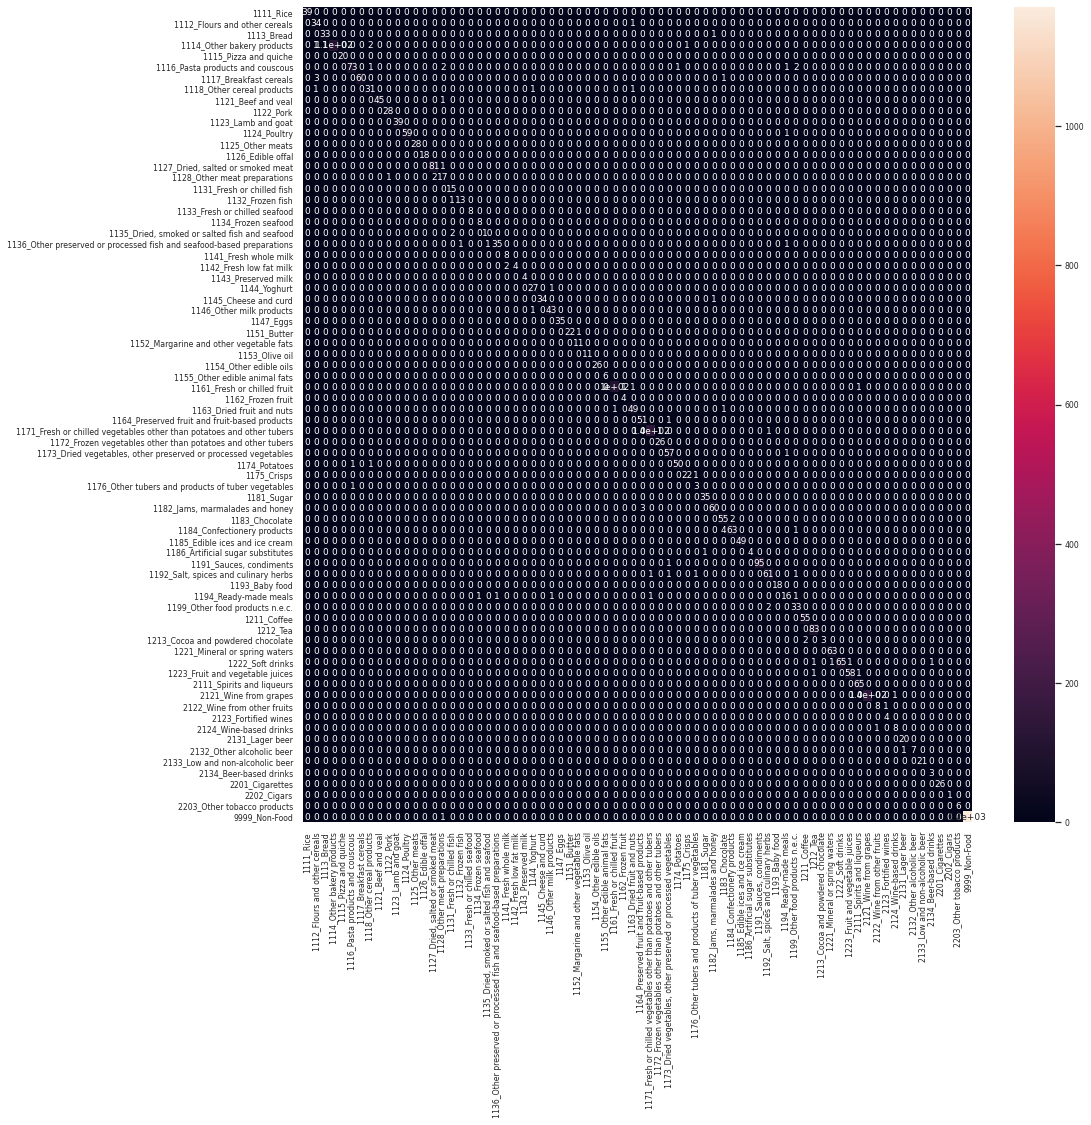

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

#print(classification_report(y_pred_test, y_test_de))
#y_pred_test, y_test_de

label = pd.Series(y_test_de).unique()
label.sort()
cm = confusion_matrix(y_test_de,y_pred_test,labels=label)#, normalize='true')

df_cm = pd.DataFrame(cm, label,label)
plt.figure(figsize=(15,15))
sn.set(font_scale=.7) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

In [ ]:

y_pred_test = de_cnn.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]
print(round(accuracy_score(y_pred_test, y_test_fr),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4))
print(classification_report(y_pred_test, y_test_fr))

0.3884
0.2631
                                                                       precision    recall  f1-score   support

                                                            1111_Rice       0.32      0.92      0.48        13
                                        1112_Flours and other cereals       0.00      0.00      0.00         7
                                                           1113_Bread       0.02      1.00      0.04         1
                                           1114_Other bakery products       0.33      0.49      0.39        39
                                                1115_Pizza and quiche       0.91      0.51      0.66        39
                                     1116_Pasta products and couscous       0.57      0.32      0.41       201
                                               1117_Breakfast cereals       0.24      0.68      0.36        19
                                           1118_Other cereal products       0.25      0.02      0

In [ ]:
# run transfer
task = 'slc_de_tf_fr'
model = 'cnn'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000]):
     transfer_cnn(de_cnn,'de_cnn',obs,freeze=False)

df_results[(df_results['model']==model) & (df_results['task']==task)]






  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/150
13/13 [==============================] - 1s 82ms/step - loss: 3.6910 - accuracy: 0.1900 - val_loss: 2.6126 - val_accuracy: 0.3931
Epoch 2/150
13/13 [==============================] - 1s 75ms/step - loss: 1.1673 - accuracy: 0.5100 - val_loss: 2.5737 - val_accuracy: 0.4713
Epoch 3/150
13/13 [==============================] - 1s 74ms/step - loss: 0.5285 - accuracy: 0.6900 - val_loss: 2.4529 - val_accuracy: 0.4944
Epoch 4/150
13/13 [==============================] - 1s 74ms/step - loss: 0.2391 - accuracy: 0.7700 - val_loss: 2.3377 - val_accuracy: 0.5245
Epoch 5/150
13/13 [==============================] - 1s 74ms/step - loss: 0.1888 - accuracy: 0.8600 - val_loss: 2.2419 - val_accuracy: 0.5582
Epoch 6/150
13/13 [==============================] - 1s 74ms/step - loss: 0.1095 - accuracy: 0.9500 - val_loss: 2.2188 - val_accuracy: 0.5767
Epoch 7/150
13/13 [==============================] - 1s 74ms/step - loss: 0.1196 - accuracy: 0.9000 - val_loss: 2.1899 - val_accuracy: 0.5971
Epoch 






 17%|█▋        | 1/6 [00:22<01:54, 22.95s/it]

it 0.2834
None
Epoch 1/150
32/32 [==============================] - 2s 65ms/step - loss: 4.5352 - accuracy: 0.4480 - val_loss: 1.3399 - val_accuracy: 0.7144
Epoch 2/150
32/32 [==============================] - 2s 62ms/step - loss: 0.4067 - accuracy: 0.9320 - val_loss: 1.3961 - val_accuracy: 0.7526
Epoch 3/150
32/32 [==============================] - 2s 62ms/step - loss: 0.1674 - accuracy: 0.9840 - val_loss: 1.3186 - val_accuracy: 0.7666
Epoch 4/150
32/32 [==============================] - 2s 63ms/step - loss: 0.0475 - accuracy: 0.9800 - val_loss: 1.3081 - val_accuracy: 0.7701
Epoch 5/150
32/32 [==============================] - 2s 63ms/step - loss: 0.0131 - accuracy: 0.9960 - val_loss: 1.3117 - val_accuracy: 0.7765
Epoch 6/150
32/32 [==============================] - 2s 61ms/step - loss: 0.0151 - accuracy: 0.9960 - val_loss: 1.3011 - val_accuracy: 0.7775
Epoch 7/150
32/32 [==============================] - 2s 61ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 1.3060 - val_accuracy






 33%|███▎      | 2/6 [00:55<01:43, 25.97s/it]

it 0.2639
None
Epoch 1/150
63/63 [==============================] - 3s 51ms/step - loss: 4.1140 - accuracy: 0.5180 - val_loss: 1.1514 - val_accuracy: 0.7568
Epoch 2/150
63/63 [==============================] - 3s 50ms/step - loss: 0.6711 - accuracy: 0.9260 - val_loss: 0.8927 - val_accuracy: 0.8041
Epoch 3/150
63/63 [==============================] - 3s 49ms/step - loss: 0.1112 - accuracy: 0.9640 - val_loss: 0.8819 - val_accuracy: 0.8185
Epoch 4/150
63/63 [==============================] - 3s 48ms/step - loss: 0.0769 - accuracy: 0.9800 - val_loss: 0.8869 - val_accuracy: 0.8259
Epoch 5/150
63/63 [==============================] - 3s 50ms/step - loss: 0.0301 - accuracy: 0.9880 - val_loss: 0.8751 - val_accuracy: 0.8287
Epoch 6/150
63/63 [==============================] - 3s 49ms/step - loss: 0.0131 - accuracy: 0.9940 - val_loss: 0.8713 - val_accuracy: 0.8297
Epoch 7/150
63/63 [==============================] - 3s 49ms/step - loss: 0.0156 - accuracy: 0.9940 - val_loss: 0.8670 - val_accuracy






 50%|█████     | 3/6 [01:56<01:49, 36.41s/it]

it 0.2834
None
Epoch 1/150
125/125 [==============================] - 5s 42ms/step - loss: 2.5298 - accuracy: 0.5880 - val_loss: 0.8173 - val_accuracy: 0.8301
Epoch 2/150
125/125 [==============================] - 5s 41ms/step - loss: 0.3624 - accuracy: 0.9250 - val_loss: 0.6709 - val_accuracy: 0.8644
Epoch 3/150
125/125 [==============================] - 5s 42ms/step - loss: 0.0973 - accuracy: 0.9730 - val_loss: 0.6257 - val_accuracy: 0.8770
Epoch 4/150
125/125 [==============================] - 5s 42ms/step - loss: 0.0436 - accuracy: 0.9880 - val_loss: 0.6343 - val_accuracy: 0.8658
Epoch 5/150
125/125 [==============================] - 5s 41ms/step - loss: 0.0232 - accuracy: 0.9930 - val_loss: 0.6097 - val_accuracy: 0.8718
Epoch 6/150
125/125 [==============================] - 5s 42ms/step - loss: 0.0212 - accuracy: 0.9950 - val_loss: 0.6020 - val_accuracy: 0.8749
Epoch 7/150
125/125 [==============================] - 5s 42ms/step - loss: 0.0206 - accuracy: 0.9960 - val_loss: 0.6118 






 67%|██████▋   | 4/6 [03:48<01:57, 58.93s/it]

it 0.3328
None
Epoch 1/150
250/250 [==============================] - 10s 38ms/step - loss: 2.6355 - accuracy: 0.6990 - val_loss: 0.6439 - val_accuracy: 0.8690
Epoch 2/150
250/250 [==============================] - 9s 38ms/step - loss: 0.3040 - accuracy: 0.9400 - val_loss: 0.5025 - val_accuracy: 0.8987
Epoch 3/150
250/250 [==============================] - 9s 38ms/step - loss: 0.0992 - accuracy: 0.9790 - val_loss: 0.5119 - val_accuracy: 0.8980
Epoch 4/150
250/250 [==============================] - 9s 38ms/step - loss: 0.0540 - accuracy: 0.9875 - val_loss: 0.4932 - val_accuracy: 0.9005
Epoch 5/150
250/250 [==============================] - 9s 37ms/step - loss: 0.0649 - accuracy: 0.9850 - val_loss: 0.5736 - val_accuracy: 0.8938
Epoch 6/150
250/250 [==============================] - 9s 38ms/step - loss: 0.0305 - accuracy: 0.9905 - val_loss: 0.5261 - val_accuracy: 0.8963
Epoch 7/150
250/250 [==============================] - 10s 38ms/step - loss: 0.0293 - accuracy: 0.9950 - val_loss: 0.547






 83%|████████▎ | 5/6 [05:15<01:07, 67.53s/it]

it 0.2894
None
Epoch 1/150
625/625 [==============================] - 22s 36ms/step - loss: 1.4326 - accuracy: 0.8018 - val_loss: 0.4494 - val_accuracy: 0.9100
Epoch 2/150
625/625 [==============================] - 23s 36ms/step - loss: 0.2232 - accuracy: 0.9574 - val_loss: 0.4081 - val_accuracy: 0.9198
Epoch 3/150
625/625 [==============================] - 23s 36ms/step - loss: 0.0987 - accuracy: 0.9784 - val_loss: 0.3893 - val_accuracy: 0.9296
Epoch 4/150
625/625 [==============================] - 22s 36ms/step - loss: 0.0586 - accuracy: 0.9874 - val_loss: 0.3874 - val_accuracy: 0.9292
Epoch 5/150
625/625 [==============================] - 22s 36ms/step - loss: 0.0436 - accuracy: 0.9928 - val_loss: 0.4060 - val_accuracy: 0.9292
Epoch 6/150
625/625 [==============================] - 22s 36ms/step - loss: 0.0292 - accuracy: 0.9946 - val_loss: 0.4169 - val_accuracy: 0.9317
Epoch 7/150
625/625 [==============================] - 22s 36ms/step - loss: 0.0325 - accuracy: 0.9930 - val_loss: 






100%|██████████| 6/6 [08:39<00:00, 86.51s/it] 

it 0.2834
None


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
28,cnn,slc_de_tf_fr,accuracy,NaN,0.6392,0.787,0.8322,0.8736,0.8911,0.9327,NaN,NaN,NaN,NaN
29,cnn,slc_de_tf_fr,avg_recall,NaN,0.2497,0.4519,0.5265,0.5949,0.6723,0.7368,NaN,NaN,NaN,NaN


CNN FR -> DE

In [ ]:
dropout_rate= .4
lr = .0001
#lr= .001
opt = Adam(lr=lr, decay=lr/100)

filter_sizes =  [3,4,5]
num_filters = 75

                  
input_layer = Input(shape = (seq_len,), name='text_input')
embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv1D(num_filters, kernel_size=filter_sizes[i],  activation='relu')(embedd_seq) #kernel_initializer='he_normal',
    maxpool_pool.append(MaxPooling1D(pool_size = seq_len-filter_sizes[i]+1)(conv))
pool_layer = Concatenate(axis=1)(maxpool_pool)  
falt_layer = Flatten(name='flat')(pool_layer)
drop_layer = Dropout(dropout_rate)(falt_layer)

pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

de_cnn = Model(inputs = [input_layer], outputs = pred_layer)
de_cnn.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 3)
print(de_cnn.summary())

#de_cnn.load_weights(path+'/model/de_cnn')

hist = de_cnn.fit(x = X_train_pad_fr, y = y_train_enc_fr,\
                validation_data = (X_val_pad_fr, y_val_enc_fr), \
                epochs = 50, batch_size = 64, shuffle = True, class_weight = class_weight_dict_de_fr, \
                callbacks = [early_stopping])

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_test = de_cnn.predict(X_test_pad_de)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_test_de),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_de)*len(np.unique(y_pred_test))/no_Classes,4))

y_pred_test = de_cnn.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_test_fr),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4))

de_cnn.save_weights(path+'/model/de_cnn')
de_cnn.save(path+'/model/de_cnn.h5')

all_tests(de_cnn,X_test_pad_de,X_test_pad_fr,X_pad_it)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 300)      6872400     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 32, 75)       67575       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 31, 75)       90075       embedding_1[0][0]                
____________________________________________________________________________________________

In [ ]:
y_pred_test = de_cnn.predict(X_test_pad_de)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]
print(round(accuracy_score(y_pred_test, y_test_de),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_de)*len(np.unique(y_pred_test))/no_Classes,4))
print(classification_report(y_pred_test, y_test_de))

0.1955
0.2597
                                                                       precision    recall  f1-score   support

                                                            1111_Rice       0.26      0.83      0.39        12
                                        1112_Flours and other cereals       0.00      0.00      0.00         0
                                                           1113_Bread       0.06      0.50      0.11         4
                                           1114_Other bakery products       0.36      0.34      0.35       126
                                                1115_Pizza and quiche       0.80      0.47      0.59        34
                                     1116_Pasta products and couscous       0.11      0.53      0.19        17
                                               1117_Breakfast cereals       0.59      0.49      0.54        77
                                           1118_Other cereal products       0.12      0.03      0

In [ ]:

y_pred_test = de_cnn.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]
print(round(accuracy_score(y_pred_test, y_test_fr),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4))
print(classification_report(y_pred_test, y_test_fr))

0.9811
0.8628
                                                                       precision    recall  f1-score   support

                                                            1111_Rice       1.00      0.97      0.99        38
                                        1112_Flours and other cereals       1.00      1.00      1.00         6
                                                           1113_Bread       0.98      1.00      0.99        54
                                           1114_Other bakery products       0.91      0.91      0.91        58
                                                1115_Pizza and quiche       1.00      0.96      0.98        23
                                     1116_Pasta products and couscous       0.98      0.99      0.99       112
                                               1117_Breakfast cereals       1.00      1.00      1.00        54
                                           1118_Other cereal products       1.00      1.00      1

## RNN DE -> FR

In [ ]:
dropout_rate= .5

lr= .001
opt = Adam(lr=lr, decay=lr/100)


                  
input_layer = Input(shape = (seq_len,), name='text_input')
embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = False, mask_zero=False)(input_layer)
lstm_layer = Bidirectional(LSTM(256,activation = 'tanh',recurrent_activation = 'sigmoid', dropout = dropout_rate,recurrent_dropout = 0, unroll = False,use_bias = True))(embedd_seq)
drop_layer = Dropout(dropout_rate)(lstm_layer)

pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

de_rnn = Model(inputs = [input_layer], outputs = pred_layer)
de_rnn.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 3)
print(de_rnn.summary())
hist = de_rnn.fit(x = X_train_pad_de, y = y_train_enc_de,\
                validation_data = (X_val_pad_de, y_val_enc_de), \
                epochs = 50, batch_size = 64, shuffle = True, class_weight = class_weight_dict_de_fr, \
                callbacks = [early_stopping])

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_test = de_rnn.predict(X_test_pad_de)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_test_de),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_de)*len(np.unique(y_pred_test))/no_Classes,4))

y_pred_test = de_rnn.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_test_fr),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4))

de_rnn.save_weights(path+'/model/de_rnn')
de_rnn.save(path+'/model/de_rnn.h5')

all_tests(de_rnn,X_test_pad_de,X_test_pad_fr,X_pad_it)

0.9667
0.8968
0.3289
0.1706

de 0.9667
fr 0.3289
it 0.2069


In [ ]:
# run transfer
task = 'slc_de_tf_fr'
model = 'rnn'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000]):
     transfer_cnn(de_rnn,'de_rnn',obs,freeze=False)

df_results[(df_results['model']==model) & (df_results['task']==task)]







  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/150
50/50 [==============================] - 7s 135ms/step - loss: 6.0279 - accuracy: 0.0900 - val_loss: 3.9051 - val_accuracy: 0.0967
Epoch 2/150
50/50 [==============================] - 6s 124ms/step - loss: 4.1166 - accuracy: 0.1500 - val_loss: 3.0723 - val_accuracy: 0.3080
Epoch 3/150
50/50 [==============================] - 6s 124ms/step - loss: 3.2018 - accuracy: 0.4000 - val_loss: 2.9912 - val_accuracy: 0.3423
Epoch 4/150
50/50 [==============================] - 6s 126ms/step - loss: 2.5257 - accuracy: 0.5600 - val_loss: 2.7099 - val_accuracy: 0.3686
Epoch 5/150
50/50 [==============================] - 6s 126ms/step - loss: 1.7607 - accuracy: 0.6600 - val_loss: 2.4348 - val_accuracy: 0.5000
Epoch 6/150
50/50 [==============================] - 6s 127ms/step - loss: 1.4622 - accuracy: 0.7400 - val_loss: 2.2531 - val_accuracy: 0.5441
Epoch 7/150
50/50 [==============================] - 6s 124ms/step - loss: 0.7526 - accuracy: 0.8300 - val_loss: 2.2579 - val_accuracy: 0.5676







 17%|█▋        | 1/6 [01:31<07:39, 91.83s/it]

fr 0.6116
it 0.0825
None
Epoch 1/150
125/125 [==============================] - 9s 76ms/step - loss: 4.3623 - accuracy: 0.1960 - val_loss: 2.2141 - val_accuracy: 0.5375
Epoch 2/150
125/125 [==============================] - 9s 73ms/step - loss: 2.8747 - accuracy: 0.5480 - val_loss: 1.9006 - val_accuracy: 0.5193
Epoch 3/150
125/125 [==============================] - 9s 71ms/step - loss: 2.1123 - accuracy: 0.6000 - val_loss: 1.5192 - val_accuracy: 0.6233
Epoch 4/150
125/125 [==============================] - 9s 70ms/step - loss: 1.3767 - accuracy: 0.7960 - val_loss: 1.3869 - val_accuracy: 0.6857
Epoch 5/150
125/125 [==============================] - 9s 70ms/step - loss: 1.0638 - accuracy: 0.8560 - val_loss: 1.4173 - val_accuracy: 0.7123
Epoch 6/150
125/125 [==============================] - 9s 71ms/step - loss: 0.8135 - accuracy: 0.8400 - val_loss: 1.4259 - val_accuracy: 0.7155
Epoch 7/150
125/125 [==============================] - 9s 72ms/step - loss: 0.5093 - accuracy: 0.9280 - val_los







 33%|███▎      | 2/6 [02:56<05:58, 89.62s/it]

fr 0.7405
it 0.0495
None
Epoch 1/150
250/250 [==============================] - 14s 56ms/step - loss: 3.4549 - accuracy: 0.3600 - val_loss: 1.8566 - val_accuracy: 0.5985
Epoch 2/150
250/250 [==============================] - 13s 54ms/step - loss: 2.2021 - accuracy: 0.6640 - val_loss: 1.3889 - val_accuracy: 0.7081
Epoch 3/150
250/250 [==============================] - 14s 55ms/step - loss: 1.5309 - accuracy: 0.7700 - val_loss: 1.2104 - val_accuracy: 0.7554
Epoch 4/150
250/250 [==============================] - 14s 55ms/step - loss: 1.1153 - accuracy: 0.8660 - val_loss: 1.1932 - val_accuracy: 0.7512
Epoch 5/150
250/250 [==============================] - 14s 55ms/step - loss: 0.6475 - accuracy: 0.8920 - val_loss: 1.1470 - val_accuracy: 0.7772
Epoch 6/150
250/250 [==============================] - 14s 55ms/step - loss: 0.6574 - accuracy: 0.8880 - val_loss: 1.0745 - val_accuracy: 0.7936
Epoch 7/150
250/250 [==============================] - 14s 58ms/step - loss: 0.5249 - accuracy: 0.9300 - 







 50%|█████     | 3/6 [05:46<05:40, 113.65s/it]

fr 0.8182
it 0.0885
None
Epoch 1/150
250/250 [==============================] - 12s 49ms/step - loss: 3.9501 - accuracy: 0.4310 - val_loss: 1.4763 - val_accuracy: 0.6591
Epoch 2/150
250/250 [==============================] - 12s 47ms/step - loss: 2.2159 - accuracy: 0.7140 - val_loss: 1.0090 - val_accuracy: 0.7708
Epoch 3/150
250/250 [==============================] - 12s 47ms/step - loss: 1.7023 - accuracy: 0.7800 - val_loss: 0.9423 - val_accuracy: 0.7463
Epoch 4/150
250/250 [==============================] - 12s 47ms/step - loss: 1.1567 - accuracy: 0.8290 - val_loss: 0.8095 - val_accuracy: 0.8136
Epoch 5/150
250/250 [==============================] - 12s 47ms/step - loss: 0.9276 - accuracy: 0.8690 - val_loss: 0.8918 - val_accuracy: 0.7978
Epoch 6/150
250/250 [==============================] - 12s 47ms/step - loss: 0.6877 - accuracy: 0.9050 - val_loss: 0.7836 - val_accuracy: 0.8343
Epoch 7/150
250/250 [==============================] - 12s 47ms/step - loss: 0.5308 - accuracy: 0.9060 - 







 67%|██████▋   | 4/6 [08:24<04:14, 127.13s/it]

fr 0.8515
it 0.1154
None
Epoch 1/150
250/250 [==============================] - 11s 45ms/step - loss: 3.2990 - accuracy: 0.5325 - val_loss: 0.9376 - val_accuracy: 0.7877
Epoch 2/150
250/250 [==============================] - 11s 42ms/step - loss: 1.8111 - accuracy: 0.7910 - val_loss: 0.7935 - val_accuracy: 0.7912
Epoch 3/150
250/250 [==============================] - 11s 42ms/step - loss: 1.1755 - accuracy: 0.8530 - val_loss: 0.6175 - val_accuracy: 0.8584
Epoch 4/150
250/250 [==============================] - 11s 43ms/step - loss: 0.8271 - accuracy: 0.8990 - val_loss: 0.5820 - val_accuracy: 0.8693
Epoch 5/150
250/250 [==============================] - 11s 42ms/step - loss: 0.5975 - accuracy: 0.9265 - val_loss: 0.5766 - val_accuracy: 0.8721
Epoch 6/150
250/250 [==============================] - 11s 42ms/step - loss: 0.3965 - accuracy: 0.9450 - val_loss: 0.6187 - val_accuracy: 0.8704
Epoch 7/150
250/250 [==============================] - 11s 43ms/step - loss: 0.2900 - accuracy: 0.9525 - 







 83%|████████▎ | 5/6 [10:45<02:11, 131.24s/it]

fr 0.8876
it 0.1124
None
Epoch 1/150
79/79 [==============================] - 4s 48ms/step - loss: 1.9799 - accuracy: 0.7360 - val_loss: 0.5706 - val_accuracy: 0.8721
Epoch 2/150
79/79 [==============================] - 3s 40ms/step - loss: 0.7967 - accuracy: 0.8946 - val_loss: 0.5191 - val_accuracy: 0.8809
Epoch 3/150
79/79 [==============================] - 3s 41ms/step - loss: 0.5443 - accuracy: 0.9152 - val_loss: 0.4323 - val_accuracy: 0.9082
Epoch 4/150
79/79 [==============================] - 3s 40ms/step - loss: 0.3212 - accuracy: 0.9494 - val_loss: 0.4179 - val_accuracy: 0.9124
Epoch 5/150
79/79 [==============================] - 3s 40ms/step - loss: 0.2824 - accuracy: 0.9606 - val_loss: 0.4484 - val_accuracy: 0.9117
Epoch 6/150
79/79 [==============================] - 3s 41ms/step - loss: 0.2267 - accuracy: 0.9602 - val_loss: 0.4391 - val_accuracy: 0.9145
Epoch 7/150
79/79 [==============================] - 3s 40ms/step - loss: 0.1385 - accuracy: 0.9742 - val_loss: 0.4482 - va







100%|██████████| 6/6 [11:19<00:00, 113.20s/it]

fr 0.9075
it 0.2459
None


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
30,rnn,slc_de_tf_fr,accuracy,NaN,0.6116,0.7405,0.8182,0.8515,0.8876,0.9075,NaN,NaN,NaN,NaN
31,rnn,slc_de_tf_fr,avg_recall,NaN,0.2743,0.4062,0.497,0.6068,0.6741,0.7132,NaN,NaN,NaN,NaN


# DEFR -> IT

In [35]:
X_train_pad = np.concatenate((X_train_pad_de,X_train_pad_fr),axis=0) 
X_val_pad  = np.concatenate((X_val_pad_de,X_val_pad_fr),axis=0) 
y_train_enc  = np.concatenate((y_train_enc_de,y_train_enc_fr),axis=0) 
y_val_enc  = np.concatenate((y_val_enc_de,y_val_enc_fr),axis=0)

dropout_rate= .4
lr = .0001
#lr= .001
opt = Adam(lr=lr, decay=lr/100)

filter_sizes =  [3,4,5]
num_filters = 75

                  
input_layer = Input(shape = (seq_len,), name='text_input')
embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
lstm_layer = Bidirectional(LSTM(256,activation = 'tanh',recurrent_activation = 'sigmoid', dropout = dropout_rate,recurrent_dropout = 0, unroll = False,use_bias = True))(embedd_seq)
drop_layer = Dropout(dropout_rate)(lstm_layer)

pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

de_rnn = Model(inputs = [input_layer], outputs = pred_layer)
de_rnn.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 3)
print(de_rnn.summary())
hist = de_rnn.fit(x = X_train_pad, y = y_train_enc,\
                validation_data = (X_val_pad, y_val_enc), \
                epochs = 100, batch_size = 256, shuffle = True, class_weight = class_weight_dict_de_fr, \
                callbacks = [early_stopping])

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_test = de_rnn.predict(X_test_pad_de)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_test_de),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_de)*len(np.unique(y_pred_test))/no_Classes,4))

y_pred_test = de_rnn.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_test_fr),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4))

y_pred_test = de_rnn.predict(X_pad_it)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_it),4))
print(round(balanced_accuracy_score(y_pred_test, y_it)*len(np.unique(y_pred_test))/no_Classes,4))


de_rnn.save_weights(path+'/model/defr_rnn')
de_rnn.save(path+'/model/defr_rnn.h5')

all_tests(de_rnn,X_test_pad_de,X_test_pad_fr,X_pad_it)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 34)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 34, 300)           6872400   
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               1140736   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
output_de (Dense)            (None, 75)                38475     
Total params: 8,051,611
Trainable params: 8,051,611
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
160/160 [==============================] - 11s 68ms/step - loss: 4.2233 - accuracy: 0.0489 - val_l

TypeError: ignored

In [32]:
X_train_pad = np.concatenate((X_train_pad_de,X_train_pad_fr),axis=0) 
X_val_pad  = np.concatenate((X_val_pad_de,X_val_pad_fr),axis=0) 
y_train_enc  = np.concatenate((y_train_enc_de,y_train_enc_fr),axis=0) 
y_val_enc  = np.concatenate((y_val_enc_de,y_val_enc_fr),axis=0)

dropout_rate= .4
lr = .0001
#lr= .001
opt = Adam(lr=lr, decay=lr/100)

filter_sizes =  [3,4,5]
num_filters = 75

                  
input_layer = Input(shape = (seq_len,), name='text_input')
embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv1D(num_filters, kernel_size=filter_sizes[i],  activation='relu')(embedd_seq) #kernel_initializer='he_normal',
    maxpool_pool.append(MaxPooling1D(pool_size = seq_len-filter_sizes[i]+1)(conv))
pool_layer = Concatenate(axis=1)(maxpool_pool)  
falt_layer = Flatten(name='flat')(pool_layer)
drop_layer = Dropout(dropout_rate)(falt_layer)

pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

de_rnn = Model(inputs = [input_layer], outputs = pred_layer)
de_rnn.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 3)
print(de_rnn.summary())
hist = de_rnn.fit(x = X_train_pad, y = y_train_enc,\
                validation_data = (X_val_pad, y_val_enc), \
                epochs = 100, batch_size = 256, shuffle = True, class_weight = class_weight_dict_de_fr, \
                callbacks = [early_stopping])

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred_test = de_rnn.predict(X_test_pad_de)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_test_de),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_de)*len(np.unique(y_pred_test))/no_Classes,4))

y_pred_test = de_rnn.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_test_fr),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4))

y_pred_test = de_rnn.predict(X_pad_it)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]

print(round(accuracy_score(y_pred_test, y_it),4))
print(round(balanced_accuracy_score(y_pred_test, y_it)*len(np.unique(y_pred_test))/no_Classes,4))


de_rnn.save_weights(path+'/model/defr_rnn')
de_rnn.save(path+'/model/defr_rnn.h5')

all_tests(de_rnn,X_test_pad_de,X_test_pad_fr,X_pad_it)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 300)      6872400     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 32, 75)       67575       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 31, 75)       90075       embedding_1[0][0]                
____________________________________________________________________________________________

TypeError: ignored

In [34]:
y_pred_test = de_rnn.predict(X_test_pad_fr)
y_pred_arg = y_pred_test.argmax(axis=1)
y_pred_test= [encoder.classes_[y] for y in y_pred_arg]
print(round(accuracy_score(y_pred_test, y_test_fr),4))
print(round(balanced_accuracy_score(y_pred_test, y_test_fr)*len(np.unique(y_pred_test))/no_Classes,4))
print(classification_report(y_pred_test, y_test_fr))

0.9807
0.8626
                                                                       precision    recall  f1-score   support

                                                            1111_Rice       1.00      0.97      0.99        38
                                        1112_Flours and other cereals       1.00      1.00      1.00         6
                                                           1113_Bread       1.00      1.00      1.00        55
                                           1114_Other bakery products       0.91      0.93      0.92        57
                                                1115_Pizza and quiche       1.00      0.96      0.98        23
                                     1116_Pasta products and couscous       0.99      0.97      0.98       115
                                               1117_Breakfast cereals       1.00      0.98      0.99        55
                                           1118_Other cereal products       1.00      1.00      1

## Pool - CNN

In [30]:
 def run_ml_pool(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,
             X_train_emb_fr,y_train_enc_fr,X_val_emb_fr,y_val_enc_fr,X_test_emb_fr,y_test_fr,
             X_it,y_enc_it,y_it,
             class_weight_dict,no):
   
    idx_fr = np.random.randint(len(X_train_emb_fr), size=no+50)
    idx_de = np.random.randint(len(X_train_emb_de), size=no+50)
    idx_it = np.random.randint(len(X_it), size=no)
    idx_test_it = [a for a in range(0,len(X_it)) if a not in idx_it]

    X_train_emb =  np.concatenate((X_train_emb_de[:100], X_train_emb_fr))
    y_train_enc =  np.concatenate((y_train_enc_de[:100], y_train_enc_fr))
    print('before_it',len(X_train_emb), len(X_it[idx_it[50:]]))

    for i in range(0,50):
        X_train_emb =  np.concatenate((X_train_emb, X_it[idx_it[50:]]))
        y_train_enc =  np.concatenate((y_train_enc, y_enc_it[idx_it[50:],:]))

    print('after_it',len(X_train_emb), len(X_it[idx_it[50:]]))

    X_val_emb =  np.concatenate((X_val_emb_de[:100], X_val_emb_fr))
    y_val_enc =  np.concatenate((y_val_enc_de[:100], y_val_enc_fr))
    X_val_emb =  np.concatenate((X_val_emb,  X_it[idx_it[:50]]))
    y_val_enc =  np.concatenate((y_val_enc, y_enc_it[idx_it[:50],:]))
    print('after_it',len(X_val_emb), len(X_it[idx_it[:50]]))


    dropout_rate= .1
    lr = .01
    opt = Adam(lr=lr, decay=lr/150)

                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)
    pool_layer = GlobalAveragePooling1D()(embedd_seq)   

    drop_layer = Dropout(dropout_rate,name='drop')(pool_layer)
    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    cnn_defr = Model(inputs = [input_layer], outputs = pred_layer)
    cnn_defr.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 2)

    
    hist = cnn_defr.fit(x = X_train_emb, y = y_train_enc,\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 50, batch_size = 256, shuffle = True, class_weight = class_weight_dict, \
                    callbacks = [early_stopping])

    task_fr = task + '_fr'
    y_pred_test = pred_encode(cnn_defr,X_test_pad_fr)
    fill_df_res(y_pred_test,y_test_fr,no,task_fr)

    task_de = task + '_de'
    y_pred_test = pred_encode(cnn_defr,X_test_pad_de)
    fill_df_res(y_pred_test,y_test_de,no,task_de)

    task_it = task + '_it'
    y_pred_test = pred_encode(cnn_defr,X_it[idx_test_it])
    fill_df_res(y_pred_test,y_it.iloc[idx_test_it],no,task_it)

    all_tests(cnn_defr,X_test_pad_de,X_test_pad_fr,X_it[idx_test_it],y_it.iloc[idx_test_it])



In [ ]:
task = 'mlc_defrit'
model = 'Avg_pool'
metrics = ['accuracy','avg_recall']

for m in metrics:
    task_l = task + '_fr'
    df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)
    task_l = task + '_de'
    df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)
    task_l = task + '_it'
    df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500]):
     run_ml_pool(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,\
             X_train_pad_fr,y_train_enc_fr,X_val_pad_fr,y_val_enc_fr,X_test_pad_fr,y_test_fr,\
             X_pad_it,y_enc_it,y_it,class_weight_dict_de_fr,obs)

df_results[(df_results['model']==model) & (df_results['task']==task)]






  0%|          | 0/3 [00:00<?, ?it/s]

before_it 17224 50
after_it 19724 50
after_it 3004 50
Epoch 1/50
78/78 [==============================] - 7s 84ms/step - loss: 1.4657 - accuracy: 0.7921 - val_loss: 0.4069 - val_accuracy: 0.9111
Epoch 2/50
78/78 [==============================] - 6s 82ms/step - loss: 0.2088 - accuracy: 0.9612 - val_loss: 0.2831 - val_accuracy: 0.9361
Epoch 3/50
78/78 [==============================] - 6s 82ms/step - loss: 0.0890 - accuracy: 0.9812 - val_loss: 0.2304 - val_accuracy: 0.9467
Epoch 4/50
78/78 [==============================] - 6s 83ms/step - loss: 0.0490 - accuracy: 0.9887 - val_loss: 0.2098 - val_accuracy: 0.9547
Epoch 5/50
78/78 [==============================] - 6s 82ms/step - loss: 0.0331 - accuracy: 0.9924 - val_loss: 0.2007 - val_accuracy: 0.9571
Epoch 6/50
78/78 [==============================] - 6s 83ms/step - loss: 0.0231 - accuracy: 0.9933 - val_loss: 0.2040 - val_accuracy: 0.9577
Epoch 7/50
78/78 [==============================] - 6s 82ms/step - loss: 0.0169 - accuracy: 0.9961 -






 33%|███▎      | 1/3 [00:47<01:34, 47.34s/it]

it 0.5456
before_it 17224 200
after_it 27224 200
after_it 3004 50
Epoch 1/50
107/107 [==============================] - 9s 84ms/step - loss: 1.0899 - accuracy: 0.8048 - val_loss: 0.3654 - val_accuracy: 0.9198
Epoch 2/50
107/107 [==============================] - 9s 82ms/step - loss: 0.1285 - accuracy: 0.9741 - val_loss: 0.2355 - val_accuracy: 0.9481
Epoch 3/50
107/107 [==============================] - 9s 84ms/step - loss: 0.0587 - accuracy: 0.9878 - val_loss: 0.2165 - val_accuracy: 0.9531
Epoch 4/50
107/107 [==============================] - 9s 83ms/step - loss: 0.0322 - accuracy: 0.9923 - val_loss: 0.1877 - val_accuracy: 0.9607
Epoch 5/50
107/107 [==============================] - 9s 82ms/step - loss: 0.0198 - accuracy: 0.9947 - val_loss: 0.1886 - val_accuracy: 0.9611
Epoch 6/50
107/107 [==============================] - 9s 81ms/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.1808 - val_accuracy: 0.9650
Epoch 7/50
107/107 [==============================] - 9s 81ms/step - loss: 0






 67%|██████▋   | 2/3 [02:00<00:54, 54.94s/it]

it 0.6893
before_it 17224 450
after_it 39724 450
after_it 3004 50
Epoch 1/50
156/156 [==============================] - 12s 80ms/step - loss: 0.7771 - accuracy: 0.8649 - val_loss: 0.3189 - val_accuracy: 0.9314
Epoch 2/50
156/156 [==============================] - 12s 79ms/step - loss: 0.0755 - accuracy: 0.9856 - val_loss: 0.2279 - val_accuracy: 0.9461
Epoch 3/50
156/156 [==============================] - 13s 85ms/step - loss: 0.0330 - accuracy: 0.9921 - val_loss: 0.1884 - val_accuracy: 0.9581
Epoch 4/50
156/156 [==============================] - 12s 79ms/step - loss: 0.0179 - accuracy: 0.9956 - val_loss: 0.1739 - val_accuracy: 0.9637
Epoch 5/50
156/156 [==============================] - 12s 79ms/step - loss: 0.0132 - accuracy: 0.9967 - val_loss: 0.1673 - val_accuracy: 0.9664
Epoch 6/50
156/156 [==============================] - 12s 79ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.1752 - val_accuracy: 0.9670
Epoch 7/50
156/156 [==============================] - 12s 79ms/step - 






100%|██████████| 3/3 [03:29<00:00, 69.91s/it]

it 0.7662


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000


In [ ]:
df_results[df_results['model']=='Avg_pool']

,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
12,Avg_pool,mlc_defrit_fr,accuracy,NaN,0.9804,0.9807,0.9793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Avg_pool,mlc_defrit_de,accuracy,NaN,0.6402,0.6313,0.6524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Avg_pool,mlc_defrit_it,accuracy,NaN,0.5456,0.6893,0.7662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,Avg_pool,mlc_defrit_fr,avg_recall,NaN,0.8648,0.8662,0.8614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,Avg_pool,mlc_defrit_de,avg_recall,NaN,0.4002,0.4016,0.4107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,Avg_pool,mlc_defrit_it,avg_recall,NaN,0.2814,0.3335,0.3538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Avg_pool,mlc_defrit_fr,accuracy,NaN,0.9804,0.9807,0.9793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,Avg_pool,mlc_defrit_de,accuracy,NaN,0.6402,0.6313,0.6524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Avg_pool,mlc_defrit_it,accuracy,NaN,0.5456,0.6893,0.7662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,Avg_pool,mlc_defrit_fr,avg_recall,NaN,0.8648,0.8662,0.8614,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_results[df_results['model']=='CNN']

,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000,40000
0,CNN,mlc_defrit_fr,accuracy,NaN,0.9811,0.9793,0.9818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CNN,mlc_defrit_de,accuracy,NaN,0.4617,0.6087,0.6739,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CNN,mlc_defrit_it,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CNN,mlc_defrit_fr,avg_recall,NaN,0.8695,0.8647,0.8736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CNN,mlc_defrit_de,avg_recall,NaN,0.2507,0.3049,0.3548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CNN,mlc_defrit_it,avg_recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,CNN,mlc_defrit_fr,accuracy,NaN,0.9811,0.9793,0.9818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,CNN,mlc_defrit_de,accuracy,NaN,0.4617,0.6087,0.6739,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CNN,mlc_defrit_it,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,CNN,mlc_defrit_fr,avg_recall,NaN,0.8695,0.8647,0.8736,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### CNN

In [84]:
 def run_ml_CNN1D(X_train_emb_de,y_train_enc_de,X_val_emb_de,y_val_enc_de,X_test_emb_de,y_test_de,
             X_train_emb_fr,y_train_enc_fr,X_val_emb_fr,y_val_enc_fr,X_test_emb_fr,y_test_fr,
             X_it,y_enc_it,y_it,
             class_weight_dict,no):
   
    idx_fr = np.random.randint(len(X_train_emb_fr), size=no+50)
    idx_de = np.random.randint(len(X_train_emb_de), size=no+50)
    idx_it = np.random.randint(len(X_it), size=no)
    idx_test_it = [a for a in range(0,len(X_it)) if a not in idx_it]

    X_train_emb =  np.concatenate((X_train_emb_de, X_train_emb_fr))
    y_train_enc =  np.concatenate((y_train_enc_de, y_train_enc_fr))
    print('before_it',len(X_train_emb), len(X_it[idx_it[50:]]))

    for i in range(0,50):
        X_train_emb =  np.concatenate((X_train_emb, X_it[idx_it[50:]]))
        y_train_enc =  np.concatenate((y_train_enc, y_enc_it[idx_it[50:],:]))

    print('after_it',len(X_train_emb), len(X_it[idx_it[50:]]))

    X_val_emb =  np.concatenate((X_val_emb_de, X_val_emb_fr))
    y_val_enc =  np.concatenate((y_val_enc_de, y_val_enc_fr))
    X_val_emb =  np.concatenate((X_val_emb,  X_it[idx_it[:50]]))
    y_val_enc =  np.concatenate((y_val_enc, y_enc_it[idx_it[:50],:]))
    print('after_it',len(X_val_emb), len(X_it[idx_it[:50]]))


    dropout_rate= .6
    filter_sizes = [1,5]
    num_filters = 100
    lr = .002
    opt = Adam(lr=lr, decay=lr/150)

                          
    input_layer = Input(shape = (seq_len,), name='text_input')
    embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = True, mask_zero=False)(input_layer)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i],  activation='relu')(embedd_seq) #kernel_initializer='he_normal',
        maxpool_pool.append(MaxPooling1D(pool_size = seq_len-filter_sizes[i]+1)(conv))

    pool_layer = Concatenate(axis=1)(maxpool_pool)   
    falt_layer = Flatten(name='flat')(pool_layer)
    #dense_layer = Dense(150,activation='tanh')(falt_layer)


    drop_layer = Dropout(dropout_rate,name='drop')(falt_layer)
    pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

    cnn_defr = Model(inputs = [input_layer], outputs = pred_layer)
    cnn_defr.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 1)

    
    hist = cnn_defr.fit(x = X_train_emb, y = y_train_enc,\
                    validation_data = (X_val_emb, y_val_enc), \
                    epochs = 50, batch_size = 256, shuffle = True, class_weight = class_weight_dict, \
                    callbacks = [early_stopping])

    task_fr = task + '_fr'
    y_pred_test = pred_encode(cnn_defr,X_test_pad_fr)
    fill_df_res(y_pred_test,y_test_fr,no,task_fr)

    task_de = task + '_de'
    y_pred_test = pred_encode(cnn_defr,X_test_pad_de)
    fill_df_res(y_pred_test,y_test_de,no,task_de)

    task_it = task + '_it'
    y_pred_test = pred_encode(cnn_defr,X_it[idx_test_it])
    fill_df_res(y_pred_test,y_it.iloc[idx_test_it],no,task_it)

    all_tests(cnn_defr,X_test_pad_de,X_test_pad_fr,X_it[idx_test_it],y_it.iloc[idx_test_it])


In [83]:
task = 'mlc_defrit'
model = 'CNN'
metrics = ['accuracy','avg_recall']

for m in metrics:
    task_l = task + '_fr'
    df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)
    task_l = task + '_de'
    df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)
    task_l = task + '_it'
    df_results = df_results.append({'model': model,'task':task_l,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500]):
     run_ml_CNN1D(X_train_pad_de,y_train_enc_de,X_val_pad_de,y_val_enc_de,X_test_pad_de,y_test_de,\
             X_train_pad_fr,y_train_enc_fr,X_val_pad_fr,y_val_enc_fr,X_test_pad_fr,y_test_fr,\
             X_pad_it,y_enc_it,y_it,class_weight_dict_de_fr,obs)

df_results[(df_results['model']==model) & (df_results['task']==task)]







  0%|          | 0/3 [00:00<?, ?it/s]

before_it 40721 50
after_it 43221 50
after_it 6837 50
Epoch 1/50
169/169 [==============================] - 65s 382ms/step - loss: 2.4967 - accuracy: 0.6118 - val_loss: 0.4106 - val_accuracy: 0.9105
Epoch 2/50
169/169 [==============================] - 64s 380ms/step - loss: 0.5979 - accuracy: 0.9085 - val_loss: 0.2215 - val_accuracy: 0.9501
Epoch 3/50
169/169 [==============================] - 65s 384ms/step - loss: 0.3229 - accuracy: 0.9454 - val_loss: 0.1691 - val_accuracy: 0.9615
Epoch 4/50
169/169 [==============================] - 65s 388ms/step - loss: 0.2172 - accuracy: 0.9615 - val_loss: 0.1522 - val_accuracy: 0.9658
Epoch 5/50
169/169 [==============================] - 67s 394ms/step - loss: 0.1514 - accuracy: 0.9712 - val_loss: 0.1428 - val_accuracy: 0.9684
Epoch 6/50
169/169 [==============================] - 64s 380ms/step - loss: 0.1232 - accuracy: 0.9769 - val_loss: 0.1366 - val_accuracy: 0.9725
Epoch 7/50
169/169 [==============================] - 64s 378ms/step - loss:

TypeError: ignored

# Shop to Shop Transfer

In [ ]:
df_rewe = df_de[df_de['shop'] == 'shop.rewe.de']
df_cap= df_de[df_de['shop'] == 'CAP MARKT']
df_rewe2 = df_de[df_de['shop'] == 'REWE']
df_rewe3 = df_de[df_de['shop'] == 'ALDI Nord']
df_rewe4 = df_de[df_de['shop'] == 'ALDI Süd']
df_rewe5 = df_de[df_de['shop'] == 'Treff 3000']
df_rewe6 = df_de[df_de['shop'] == 'Spar']

df_rewe_united = df_rewe.append(df_cap)#.append(df_rewe2).append(df_rewe3).append(df_rewe4).append(df_rewe5).append(df_rewe6)
df_edeka= df_de[df_de['shop'] == 'REWE']
df_real = df_de[df_de['shop'] == 'EDEKA Center']

len(df_rewe),len(df_edeka),len(df_real)

(9124, 2003, 1855)

In [ ]:
from sklearn.model_selection import train_test_split
def split_train_abs(df):
    X_train, X_val_test, y_train, y_val_test  = train_test_split(df['text'], df['cc5'], random_state=42, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test , y_val_test, train_size=.5,random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_de_rewe, X_val_de_rewe, X_test_de_rewe, y_train_de_rewe, y_val_de_rewe, y_test_de_rewe = split_train_abs(df_rewe)
X_train_de_rewe, X_val_de_rewe2, X_test_de_rewe2, y_train_de_rewe2, y_val_de_rewe2, y_test_de_rewe2 = split_train_abs(df_rewe_united)

X_test_tokens_de = tokenizer_all.texts_to_sequences(X_test_de)

X_train_pad_de = pad_sequences(X_train_tokens_de,maxlen=seq_len, padding='post')



X_train_emb_de_rewe = np.array(list(model_helper.text_to_embed(X_train_de_rewe, ['de' for a in X_train_de_rewe], de_git_embed, fr_git_embed, seq_len=seq_len)))
X_val_emb_de_rewe = np.array(list(model_helper.text_to_embed(X_val_de_rewe, ['de' for a in X_val_de_rewe], de_git_embed, fr_git_embed, seq_len=seq_len)))
X_test_emb_de_rewe = np.array(list(model_helper.text_to_embed(X_test_de_rewe, ['de' for a in X_test_de_rewe], de_git_embed, fr_git_embed, seq_len=seq_len)))

X_train_emb_de_rewe2 = np.array(list(model_helper.text_to_embed(X_train_de_rewe2, ['de' for a in X_train_de_rewe2], de_git_embed, fr_git_embed, seq_len=seq_len)))
X_val_emb_de_rewe2 = np.array(list(model_helper.text_to_embed(X_val_de_rewe2, ['de' for a in X_val_de_rewe2], de_git_embed, fr_git_embed, seq_len=seq_len)))
X_test_emb_de_rewe2 = np.array(list(model_helper.text_to_embed(X_test_de_rewe2, ['de' for a in X_test_de_rewe2], de_git_embed, fr_git_embed, seq_len=seq_len)))

################################################################

X_emb_edeka = np.array(list(model_helper.text_to_embed(df_edeka['text'], df_edeka['lang'], de_git_embed, fr_git_embed, seq_len=seq_len)))
X_emb_real = np.array(list(model_helper.text_to_embed(df_real['text'], df_real['lang'], de_git_embed, fr_git_embed, seq_len=seq_len)))

y_train_enc_de_rewe = encode_label(y_train_de_rewe)
y_val_enc_de_rewe = encode_label(y_val_de_rewe)
y_test_enc_de_rewe = encode_label(y_test_de_rewe)

y_train_enc_de_rewe2 = encode_label(y_train_de_rewe2)
y_val_enc_de_rewe2 = encode_label(y_val_de_rewe2)
y_test_enc_de_rewe2 = encode_label(y_test_de_rewe2)


###################################################

y_enc_edeka = encode_label(df_edeka['cc5'])
y_enc_real = encode_label(df_real['cc5'])

class_weight_dict_de = get_weigth_dict(y_train_de_rewe)

TypeError: ignored

In [ ]:
dropout_rate=.2
lr = .005
opt = Adam(lr=lr, decay=lr/100)

input_layer = Input(shape = (seq_len,embedding_dim,), name='text_input')

filter_sizes = [2,3,5]
maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv1D(100, kernel_size=filter_sizes[i], kernel_initializer='he_normal', activation='relu')(input_layer)
    maxpool_pool.append(AveragePooling1D(pool_size = seq_len-filter_sizes[i]+1)(conv))

pool_layer = Concatenate(axis=1)(maxpool_pool)   
falt_layer = Flatten(name='flat')(pool_layer)

drop_layer = Dropout(dropout_rate,name='drop')(falt_layer)
pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de',kernel_regularizer=l1_l2(l1=5e-6, l2=5e-9))(drop_layer) 

de_rewe = Model(inputs = [input_layer], outputs = [pred_layer])
de_rewe.summary()

de_rewe.compile(optimizer = opt, loss = ['categorical_crossentropy'], metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 5)

hist = de_rewe.fit(x = X_train_emb_de_rewe, y = y_train_enc_de_rewe,\
                validation_data = (X_val_emb_de_rewe, y_val_enc_de_rewe), \
                epochs = 50, batch_size = 32, shuffle = True,verbose =0, \
                class_weight = class_weight_dict_de, \
                callbacks = [early_stopping])

In [ ]:
dropout_rate=.2
lr = .005
opt = Adam(lr=lr, decay=lr/100)

input_layer = Input(shape = (seq_len,embedding_dim,), name='text_input')

filter_sizes = [2,3,5]
maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv1D(100, kernel_size=filter_sizes[i], kernel_initializer='he_normal', activation='relu')(input_layer)
    maxpool_pool.append(AveragePooling1D(pool_size = seq_len-filter_sizes[i]+1)(conv))

pool_layer = Concatenate(axis=1)(maxpool_pool)   
falt_layer = Flatten(name='flat')(pool_layer)

drop_layer = Dropout(dropout_rate,name='drop')(falt_layer)
pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de',kernel_regularizer=l1_l2(l1=5e-6, l2=5e-9))(drop_layer) 

de_rewe2 = Model(inputs = [input_layer], outputs = [pred_layer])
de_rewe2.summary()

de_rewe2.compile(optimizer = opt, loss = ['categorical_crossentropy'], metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 5)

hist = de_rewe.fit(x = X_train_emb_de_rewe2, y = y_train_enc_de_rewe2,\
                validation_data = (X_val_emb_de_rewe2, y_val_enc_de_rewe2), \
                epochs = 50, batch_size = 32, shuffle = True,verbose =0, \
                class_weight = class_weight_dict_de, \
                callbacks = [early_stopping])

In [ ]:
def test_xy(X,y,string,model):
    y_pred = model.predict([X])
    y_pred_arg = y_pred.argmax(axis=1)
    pred= [encoder.classes_[y] for y in y_pred_arg]
    print('accuracy %s'% string,accuracy_score(pred,y))
    print('b_accuracy %s'%  string,balanced_accuracy_score(pred, y))

test_xy(X_test_emb_de,y_test_de,'german',de_rewe)
test_xy(X_emb_edeka,df_edeka['cc5'],'edeka',de_rewe)
test_xy(X_emb_real,df_real['cc5'],'real',de_rewe)

test_xy(X_test_emb_de,y_test_de,'german',de_rewe2)
test_xy(X_emb_edeka,df_edeka['cc5'],'edeka',de_rewe2)
test_xy(X_emb_real,df_real['cc5'],'real',de_rewe2)



# Multilingual Transfer

load embedings  
we only load a "slim" version of the embeddings, which are a subset of the vocab (less than 5%) the time loading the embeddings decreases from 15 min to 7 sec and colab is capable of loading more than two languages (embedding)

### Co2

In [ ]:
#!pip install experiment-impact-tracker
#!mkdir logs
#from experiment_impact_tracker.compute_tracker import ImpactTracker
#tracker = ImpactTracker('logs')
#tracker.launch_impact_monitor()
#info = tracker.get_latest_info_and_check_for_errors()
#!ls logs/impacttracker
#!cat logs/impacttracker/impact_tracker_log.log
#!wget 'https://raw.githubusercontent.com/ELehmann91/Thesis_Multilingual_Transferlearning/master/data/model.json'
!create-compute-appendix logs/ --site_spec model.json --output_dir logs/

In [ ]:
task = 'slc_de_zstf'
model = 'LogReg'
metrics = ['accuracy','avg_recall']

for m in metrics:
    df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)
    

tf_idf_log_reg(X_train_de,y_train_de,X_test_fr,y_test_fr,15000)

df_results[(df_results['model']==model) & (df_results['task']==task)]

## CNN 1D

In [ ]:
dropout_rate= 0.5
filter_sizes = [2,3,5]
num_filters = 80
lr = .01
opt = Adam(lr=lr, decay=lr/150)

                      
input_layer = Input(shape = (seq_len,), name='text_input')
embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = False, mask_zero=False)(input_layer)
maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv1D(num_filters, kernel_size=filter_sizes[i],  activation='relu')(embedd_seq) #kernel_initializer='he_normal',
    maxpool_pool.append(AvgPool1D(pool_size = seq_len-filter_sizes[i]+1)(conv))

pool_layer = Concatenate(axis=1)(maxpool_pool)  
falt_layer = Flatten(name='flat')(pool_layer)
#dense_layer = Dense(150,activation='relu')(falt_layer)

drop_layer = Dropout(dropout_rate,name='drop')(falt_layer)
pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

de_cnn1d = Model(inputs = [input_layer], outputs = pred_layer)
de_cnn1d.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 5)
print(X_train_pad_de.shape, y_train_enc_de.shape)
print(de_cnn1d.summary())
hist = de_cnn1d.fit(x = X_train_pad_de, y = y_train_enc_de,\
                validation_data = (X_val_pad_de, y_val_enc_de), \
                epochs = 150, batch_size = 64, shuffle = True, class_weight = class_weight_dict_de,  \
                callbacks = [early_stopping])
#verbose =0,


all_tests(de_cnn1d,X_test_pad_de,X_test_pad_fr,X_pad_it)


(23597, 31) (23597, 75)
Model: "model_181"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_149 (Embedding)       (None, 31, 300)      6590700     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_341 (Conv1D)             (None, 31, 80)       24080       embedding_149[0][0]              
__________________________________________________________________________________________________
conv1d_342 (Conv1D)             (None, 30, 80)       48080       embedding_149[0][0]              
__________________________________________________________________

### deeper prediction analysis

Prediction / Certainty Treshold

In [ ]:
def test_xy(X,y,string,model,z,ret=False):
    obs = len(X)
    y_pred = model.predict([X])
    y_pred_arg = y_pred.argmax(axis=1)
    y_pred_max = y_pred.max(axis=1)
    pred= [encoder.classes_[y] for y in y_pred_arg]
    df_pred = pd.DataFrame(zip(X,pred,y,y_pred_max),columns=['embed','pred','y','y_pred_max'])
    df_pred = df_pred[df_pred['y_pred_max']>z]
    print('accuracy %s'% string,accuracy_score(df_pred['pred'],df_pred['y']))
    print('b_accuracy %s'%  string,balanced_accuracy_score(df_pred['pred'],df_pred['y']))
    print(len(df_pred),'of',len(X),int(len(df_pred)/len(X)*100),'%',len(df_pred.pred.unique()))
    if ret:
        return df_pred
test_xy(X_test_emb_de,y_test_de,'german',de_avg_pool,.65)
test_xy(X_traprint(classification_report(y,pred))in_emb_fr,y_train_fr,'french',de_avg_pool,.8)
    #return pred, y

In [ ]:
print(classification_report(y,pred))

Accuracy for higher hirachies

In [ ]:
with open('coicop_5_4.txt') as json_file:#
    coicop_5_4 = json.load(json_file)

with open('coicop_5_3.txt') as json_file:#
    coicop_5_3 = json.load(json_file)

y_pred = de_avg_pool.predict([X_test_emb_fr])
y_pred_arg = y_pred.argmax(axis=1)
pred= [encoder.classes_[y] for y in y_pred_arg]

y_pr_lab3 = [coicop_5_3[cc5] for cc5 in pred]
y_pr_lab4 = [coicop_5_4[cc5] for cc5 in pred]
y_lab3 = [coicop_5_3[cc5] for cc5 in y_test_fr]
y_lab4 = [coicop_5_4[cc5] for cc5 in y_test_fr]
print('accuracy %s'% accuracy_score(y_pr_lab3,y_lab3))
print('b_accuracy %s'%  balanced_accuracy_score(y_pr_lab3, y_lab3))
print('accuracy %s'% accuracy_score(y_pr_lab4,y_lab4))
print('b_accuracy %s'%  balanced_accuracy_score(y_pr_lab4, y_lab4))
#print(classification_report(y_lab4,y_pr_lab4))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

y_pred = de_avg_pool.predict([X_test_emb_fr])
y_pred_arg = y_pred.argmax(axis=1)
pred= [encoder.classes_[y] for y in y_pred_arg]

y_pr_lab4 = [coicop_5_4[cc5] for cc5 in pred]
y_lab4 = [coicop_5_4[cc5] for cc5 in y_test_fr]

label = pd.Series(y_lab4).unique()
label.sort()
cm = confusion_matrix(y_lab4,y_pr_lab4,labels=label)#, normalize='true')

df_cm = pd.DataFrame(cm, label,label)
plt.figure(figsize=(15,15))
sn.set(font_scale=.7) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

### Transferlearning

In [ ]:
#test_xy(X_test_emb_de,y_test_de,'german',model_new)
#test_xy(X_test_emb_fr,y_test_fr,'french',model_new)

In [ ]:
dropout_rate= 0.2
filter_sizes =  [3,4,5]
num_filters = 75
lr = .001
opt = Adam(lr=lr, decay=lr/150)

                      
input_layer = Input(shape = (seq_len,), name='text_input')
embedd_seq = Embedding(vocab_size_all, embedding_dim, weights = [embedding_matrix_all], input_length = seq_len, trainable = False, mask_zero=False)(input_layer)
maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv1D(num_filters, kernel_size=filter_sizes[i],  activation='relu')(embedd_seq) #kernel_initializer='he_normal',
    maxpool_pool.append(AvgPool1D(pool_size = seq_len-filter_sizes[i]+1)(conv))

pool_layer = Concatenate(axis=1)(maxpool_pool)  
falt_layer = Flatten(name='flat')(pool_layer)
#dense_layer = Dense(150,activation='relu')(falt_layer)

drop_layer = Dropout(dropout_rate,name='drop')(falt_layer)
pred_layer = Dense(no_Classes, activation = 'softmax', name='output_de')(drop_layer) 

de_cnn1d_tf = Model(inputs = [input_layer], outputs = pred_layer)
de_cnn1d_tf.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(patience = 5)
print(X_train_pad_de.shape, y_train_enc_de.shape)
print(de_cnn1d_tf.summary())
hist = de_cnn1d_tf.fit(x = X_train_pad_de, y = y_train_enc_de,\
                validation_data = (X_val_pad_de, y_val_enc_de), \
                epochs = 150, batch_size = 64, shuffle = True, class_weight = class_weight_dict_de,  \
                callbacks = [early_stopping])
#verbose =0,

de_cnn1d_tf.save_weights('de_cnn1d_tf')
all_tests(de_cnn1d_tf,X_test_pad_de,X_test_pad_fr,X_pad_it)


(23597, 31) (23597, 75)
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 31, 300)      6863100     text_input[0][0]                 
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 29, 75)       67575       embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 28, 75)       90075       embedding_9[0][0]                
___________________________________________________________________

In [ ]:
def transfer_cnn(few_shot,freeze,lr):

    de_cnn1d_tf.load_weights('de_cnn1d_tf')

    opt = Adam(lr=lr, decay=lr/100)
    inp = de_cnn1d_tf.input
    out = de_cnn1d_tf.output #get_layer('output_de').output

    # create a new network between inp and out
    de_cnn1d_transfer = Model(inp, out)    

    de_cnn1d_transfer.compile(optimizer = opt, loss = ['categorical_crossentropy'], metrics = ['accuracy'])
    early_stopping = EarlyStopping(patience = 5)
    #freeze
    for l , layer in enumerate(de_cnn1d_transfer.layers[:-2]):
        de_cnn1d_transfer.layers[l].trainable = (freeze==False)

    idx = np.random.randint(len(X_train_pad_fr), size=few_shot)

    de_cnn1d_transfer.fit(x = X_train_pad_fr[idx,:], y = y_train_enc_fr[idx,:],\
                    validation_data = (X_val_pad_fr, y_val_enc_fr), \
                    epochs = 150, batch_size = 8, shuffle = True, \
                    class_weight = class_weight_dict_fr, \
                    callbacks = [early_stopping])
    print(few_shot)
    print(de_cnn1d_transfer.summary())
    #all_tests(de_cnn1d_transfer,X_test_pad_de,X_test_pad_fr,X_pad_it)

    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    y_pred_test_fr = de_cnn1d_transfer.predict(X_test_pad_fr)
    y_pred_arg_fr = y_pred_test_fr.argmax(axis=1)
    y_pred_test_fr = [encoder.classes_[y] for y in y_pred_arg_fr]
    
    df_results[str(few_shot)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='accuracy')] = round(accuracy_score(y_pred_test_fr, y_test_fr),4)
    df_results[str(few_shot)][(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']=='avg_recall')] = round(balanced_accuracy_score(y_pred_test_fr, y_test_fr),4)

In [ ]:
 task = 'slc_de_tf'
model = 'CNN1D_fix_.01'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000]):
    lr = 0.005
    if obs == 250:
        lr= 0.001
    transfer_cnn(obs,True,lr = lr)

df_results[(df_results['model']==model) & (df_results['task']==task)]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/150
13/13 [==============================] - 1s 82ms/step - loss: 2.6714 - accuracy: 0.4500 - val_loss: 2.4154 - val_accuracy: 0.5256
Epoch 2/150
13/13 [==============================] - 1s 72ms/step - loss: 2.3912 - accuracy: 0.4700 - val_loss: 2.4270 - val_accuracy: 0.5270
Epoch 3/150
13/13 [==============================] - 1s 73ms/step - loss: 1.7641 - accuracy: 0.6000 - val_loss: 2.6358 - val_accuracy: 0.5032
Epoch 4/150
13/13 [==============================] - 1s 74ms/step - loss: 1.6347 - accuracy: 0.5400 - val_loss: 2.7638 - val_accuracy: 0.4832
Epoch 5/150
13/13 [==============================] - 1s 73ms/step - loss: 1.2613 - accuracy: 0.5500 - val_loss: 2.7867 - val_accuracy: 0.4807
Epoch 6/150
13/13 [==============================] - 1s 74ms/step - loss: 1.0437 - accuracy: 0.5100 - val_loss: 2.8402 - val_accuracy: 0.4793
100
Model: "model_35"
__________________________________________________________________________________________________
Layer (type)               

 17%|█▋        | 1/6 [00:06<00:33,  6.68s/it]

Epoch 1/150
32/32 [==============================] - 1s 35ms/step - loss: 6.5920 - accuracy: 0.3960 - val_loss: 2.5877 - val_accuracy: 0.4720
Epoch 2/150
32/32 [==============================] - 1s 32ms/step - loss: 5.7692 - accuracy: 0.4360 - val_loss: 2.4581 - val_accuracy: 0.4909
Epoch 3/150
32/32 [==============================] - 1s 32ms/step - loss: 4.9981 - accuracy: 0.4600 - val_loss: 2.3972 - val_accuracy: 0.4975
Epoch 4/150
32/32 [==============================] - 1s 31ms/step - loss: 4.7921 - accuracy: 0.4600 - val_loss: 2.3844 - val_accuracy: 0.4923
Epoch 5/150
32/32 [==============================] - 1s 32ms/step - loss: 4.2497 - accuracy: 0.4920 - val_loss: 2.4122 - val_accuracy: 0.4870
Epoch 6/150
32/32 [==============================] - 1s 31ms/step - loss: 4.1188 - accuracy: 0.4520 - val_loss: 2.4232 - val_accuracy: 0.4919
Epoch 7/150
32/32 [==============================] - 1s 31ms/step - loss: 3.8024 - accuracy: 0.4640 - val_loss: 2.4169 - val_accuracy: 0.4919
Epoch 

 33%|███▎      | 2/6 [00:16<00:30,  7.69s/it]

Epoch 1/150
63/63 [==============================] - 1s 19ms/step - loss: 5.1537 - accuracy: 0.4860 - val_loss: 2.5486 - val_accuracy: 0.4818
Epoch 2/150
63/63 [==============================] - 1s 17ms/step - loss: 3.5433 - accuracy: 0.4220 - val_loss: 2.4836 - val_accuracy: 0.4713
Epoch 3/150
63/63 [==============================] - 1s 17ms/step - loss: 3.1324 - accuracy: 0.4400 - val_loss: 2.5341 - val_accuracy: 0.4695
Epoch 4/150
63/63 [==============================] - 1s 18ms/step - loss: 2.6125 - accuracy: 0.4980 - val_loss: 2.4884 - val_accuracy: 0.4877
Epoch 5/150
63/63 [==============================] - 1s 18ms/step - loss: 2.4520 - accuracy: 0.4880 - val_loss: 2.5332 - val_accuracy: 0.5000
Epoch 6/150
63/63 [==============================] - 1s 17ms/step - loss: 2.0594 - accuracy: 0.5500 - val_loss: 2.2692 - val_accuracy: 0.5473
Epoch 7/150
63/63 [==============================] - 1s 17ms/step - loss: 2.0707 - accuracy: 0.5320 - val_loss: 2.5137 - val_accuracy: 0.4772
Epoch 

 50%|█████     | 3/6 [00:45<00:42, 14.03s/it]

Epoch 1/150
125/125 [==============================] - 1s 11ms/step - loss: 4.8021 - accuracy: 0.4290 - val_loss: 2.2129 - val_accuracy: 0.5088
Epoch 2/150
125/125 [==============================] - 1s 10ms/step - loss: 3.5116 - accuracy: 0.4280 - val_loss: 2.1956 - val_accuracy: 0.5049
Epoch 3/150
125/125 [==============================] - 1s 10ms/step - loss: 2.8330 - accuracy: 0.4860 - val_loss: 2.0048 - val_accuracy: 0.5347
Epoch 4/150
125/125 [==============================] - 1s 10ms/step - loss: 2.4677 - accuracy: 0.5180 - val_loss: 1.8969 - val_accuracy: 0.5743
Epoch 5/150
125/125 [==============================] - 1s 10ms/step - loss: 2.1515 - accuracy: 0.5530 - val_loss: 1.9423 - val_accuracy: 0.5477
Epoch 6/150
125/125 [==============================] - 1s 10ms/step - loss: 1.8956 - accuracy: 0.5760 - val_loss: 1.7234 - val_accuracy: 0.6195
Epoch 7/150
125/125 [==============================] - 1s 10ms/step - loss: 1.7162 - accuracy: 0.6230 - val_loss: 1.7265 - val_accuracy:

 67%|██████▋   | 4/6 [01:13<00:36, 18.24s/it]

Epoch 1/150
250/250 [==============================] - 2s 7ms/step - loss: 4.6150 - accuracy: 0.4270 - val_loss: 2.3648 - val_accuracy: 0.4608
Epoch 2/150
250/250 [==============================] - 2s 6ms/step - loss: 3.0701 - accuracy: 0.4795 - val_loss: 1.7762 - val_accuracy: 0.5960
Epoch 3/150
250/250 [==============================] - 2s 6ms/step - loss: 2.5103 - accuracy: 0.5410 - val_loss: 1.5318 - val_accuracy: 0.6454
Epoch 4/150
250/250 [==============================] - 2s 6ms/step - loss: 2.2431 - accuracy: 0.5735 - val_loss: 1.5418 - val_accuracy: 0.6444
Epoch 5/150
250/250 [==============================] - 2s 6ms/step - loss: 1.7572 - accuracy: 0.6425 - val_loss: 1.2609 - val_accuracy: 0.6955
Epoch 6/150
250/250 [==============================] - 2s 6ms/step - loss: 1.5226 - accuracy: 0.6585 - val_loss: 1.3051 - val_accuracy: 0.7099
Epoch 7/150
250/250 [==============================] - 2s 7ms/step - loss: 1.5962 - accuracy: 0.6800 - val_loss: 1.2521 - val_accuracy: 0.7274

 83%|████████▎ | 5/6 [01:44<00:21, 21.90s/it]

Epoch 1/150
625/625 [==============================] - 3s 4ms/step - loss: 4.1502 - accuracy: 0.4574 - val_loss: 1.6864 - val_accuracy: 0.6160
Epoch 2/150
625/625 [==============================] - 2s 4ms/step - loss: 2.7312 - accuracy: 0.5774 - val_loss: 1.2822 - val_accuracy: 0.7025
Epoch 3/150
625/625 [==============================] - 2s 4ms/step - loss: 2.1580 - accuracy: 0.6512 - val_loss: 1.0068 - val_accuracy: 0.7596
Epoch 4/150
625/625 [==============================] - 2s 4ms/step - loss: 1.8242 - accuracy: 0.6980 - val_loss: 1.3509 - val_accuracy: 0.6829
Epoch 5/150
625/625 [==============================] - 2s 4ms/step - loss: 1.6880 - accuracy: 0.7202 - val_loss: 1.0903 - val_accuracy: 0.7446
Epoch 6/150
625/625 [==============================] - 2s 4ms/step - loss: 1.3843 - accuracy: 0.7498 - val_loss: 0.8157 - val_accuracy: 0.8122
Epoch 7/150
625/625 [==============================] - 2s 4ms/step - loss: 1.3115 - accuracy: 0.7626 - val_loss: 0.7758 - val_accuracy: 0.8231

100%|██████████| 6/6 [02:52<00:00, 28.83s/it]


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000
0,CNN1D_fix_.01,slc_de_tf,accuracy,NaN,0.4669,0.4869,0.6816,0.7345,0.786,0.8539,NaN,NaN,NaN
1,CNN1D_fix_.01,slc_de_tf,avg_recall,NaN,0.3905,0.3443,0.5162,0.5914,0.6234,0.6859,NaN,NaN,NaN


In [ ]:
 task = 'slc_de_tf'
model = 'CNN1D_free_.1'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000]):
     transfer_cnn(obs,False,lr = .005)

df_results[(df_results['model']==model) & (df_results['task']==task)]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/150
13/13 [==============================] - 1s 81ms/step - loss: 17.9975 - accuracy: 0.2500 - val_loss: 15.0320 - val_accuracy: 0.1167
Epoch 2/150
13/13 [==============================] - 1s 72ms/step - loss: 6.2389 - accuracy: 0.2000 - val_loss: 14.7982 - val_accuracy: 0.1994
Epoch 3/150
13/13 [==============================] - 1s 73ms/step - loss: 4.5080 - accuracy: 0.3300 - val_loss: 12.5780 - val_accuracy: 0.2652
Epoch 4/150
13/13 [==============================] - 1s 73ms/step - loss: 4.1227 - accuracy: 0.4100 - val_loss: 12.8113 - val_accuracy: 0.3844
Epoch 5/150
13/13 [==============================] - 1s 74ms/step - loss: 2.8470 - accuracy: 0.5200 - val_loss: 11.6409 - val_accuracy: 0.4688
Epoch 6/150
13/13 [==============================] - 1s 75ms/step - loss: 1.5651 - accuracy: 0.5900 - val_loss: 13.1818 - val_accuracy: 0.3248
Epoch 7/150
13/13 [==============================] - 1s 73ms/step - loss: 2.7285 - accuracy: 0.5700 - val_loss: 13.0076 - val_accuracy: 0.378

 17%|█▋        | 1/6 [00:10<00:52, 10.46s/it]

Epoch 1/150
32/32 [==============================] - 2s 70ms/step - loss: 63.0606 - accuracy: 0.2600 - val_loss: 15.1024 - val_accuracy: 0.4439
Epoch 2/150
32/32 [==============================] - 2s 67ms/step - loss: 72.8970 - accuracy: 0.4280 - val_loss: 18.0800 - val_accuracy: 0.4166
Epoch 3/150
32/32 [==============================] - 2s 67ms/step - loss: 19.8576 - accuracy: 0.4680 - val_loss: 19.5164 - val_accuracy: 0.4583
Epoch 4/150
32/32 [==============================] - 2s 66ms/step - loss: 18.4561 - accuracy: 0.5160 - val_loss: 21.2128 - val_accuracy: 0.4951
Epoch 5/150
32/32 [==============================] - 2s 66ms/step - loss: 28.8829 - accuracy: 0.5760 - val_loss: 34.5703 - val_accuracy: 0.5119
Epoch 6/150
32/32 [==============================] - 2s 66ms/step - loss: 7.0341 - accuracy: 0.6200 - val_loss: 27.7876 - val_accuracy: 0.5298
250
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)    

 33%|███▎      | 2/6 [00:24<00:46, 11.54s/it]

Epoch 1/150
63/63 [==============================] - 3s 55ms/step - loss: 42.3914 - accuracy: 0.2820 - val_loss: 11.4876 - val_accuracy: 0.2484
Epoch 2/150
63/63 [==============================] - 3s 53ms/step - loss: 21.7327 - accuracy: 0.3520 - val_loss: 17.6020 - val_accuracy: 0.3879
Epoch 3/150
63/63 [==============================] - 3s 52ms/step - loss: 18.9507 - accuracy: 0.4560 - val_loss: 18.6102 - val_accuracy: 0.4107
Epoch 4/150
63/63 [==============================] - 3s 53ms/step - loss: 14.5819 - accuracy: 0.5040 - val_loss: 15.8782 - val_accuracy: 0.4552
Epoch 5/150
63/63 [==============================] - 3s 53ms/step - loss: 5.5965 - accuracy: 0.5240 - val_loss: 19.0468 - val_accuracy: 0.4390
Epoch 6/150
63/63 [==============================] - 3s 53ms/step - loss: 7.3302 - accuracy: 0.5040 - val_loss: 22.5580 - val_accuracy: 0.4425
500
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)     

 50%|█████     | 3/6 [00:45<00:43, 14.46s/it]

Epoch 1/150
125/125 [==============================] - 6s 47ms/step - loss: 24.1611 - accuracy: 0.3960 - val_loss: 17.1788 - val_accuracy: 0.3865
Epoch 2/150
125/125 [==============================] - 6s 46ms/step - loss: 47.5280 - accuracy: 0.4600 - val_loss: 19.0997 - val_accuracy: 0.4695
Epoch 3/150
125/125 [==============================] - 6s 46ms/step - loss: 13.6334 - accuracy: 0.4900 - val_loss: 11.5108 - val_accuracy: 0.4807
Epoch 4/150
125/125 [==============================] - 6s 46ms/step - loss: 7.3668 - accuracy: 0.4900 - val_loss: 11.5973 - val_accuracy: 0.4895
Epoch 5/150
125/125 [==============================] - 6s 46ms/step - loss: 4.2510 - accuracy: 0.5450 - val_loss: 13.6845 - val_accuracy: 0.5270
Epoch 6/150
125/125 [==============================] - 6s 46ms/step - loss: 6.3108 - accuracy: 0.5700 - val_loss: 12.1329 - val_accuracy: 0.5505
Epoch 7/150
125/125 [==============================] - 6s 46ms/step - loss: 4.8592 - accuracy: 0.5780 - val_loss: 12.0654 - val

 67%|██████▋   | 4/6 [01:33<00:48, 24.33s/it]

Epoch 1/150
250/250 [==============================] - 11s 43ms/step - loss: 38.0875 - accuracy: 0.3485 - val_loss: 19.5050 - val_accuracy: 0.4278
Epoch 2/150
250/250 [==============================] - 11s 43ms/step - loss: 45.1961 - accuracy: 0.3885 - val_loss: 12.4101 - val_accuracy: 0.4355
Epoch 3/150
250/250 [==============================] - 11s 42ms/step - loss: 12.4108 - accuracy: 0.4395 - val_loss: 19.8568 - val_accuracy: 0.4769
Epoch 4/150
250/250 [==============================] - 11s 43ms/step - loss: 4.9684 - accuracy: 0.5040 - val_loss: 15.0448 - val_accuracy: 0.5340
Epoch 5/150
250/250 [==============================] - 11s 44ms/step - loss: 4.3043 - accuracy: 0.5235 - val_loss: 14.1339 - val_accuracy: 0.5298
Epoch 6/150
250/250 [==============================] - 11s 44ms/step - loss: 3.7557 - accuracy: 0.5365 - val_loss: 14.6175 - val_accuracy: 0.5431
Epoch 7/150
250/250 [==============================] - 11s 43ms/step - loss: 3.5983 - accuracy: 0.5080 - val_loss: 14.922

 83%|████████▎ | 5/6 [02:49<00:39, 39.88s/it]

Epoch 1/150
625/625 [==============================] - 25s 40ms/step - loss: 32.9158 - accuracy: 0.2708 - val_loss: 11.0829 - val_accuracy: 0.2901
Epoch 2/150
625/625 [==============================] - 25s 40ms/step - loss: 19.2911 - accuracy: 0.2650 - val_loss: 8.8031 - val_accuracy: 0.2831
Epoch 3/150
625/625 [==============================] - 25s 40ms/step - loss: 6.0474 - accuracy: 0.2922 - val_loss: 6.3110 - val_accuracy: 0.2922
Epoch 4/150
625/625 [==============================] - 25s 40ms/step - loss: 5.9694 - accuracy: 0.2770 - val_loss: 6.0842 - val_accuracy: 0.3220
Epoch 5/150
625/625 [==============================] - 25s 40ms/step - loss: 5.1733 - accuracy: 0.3296 - val_loss: 6.9963 - val_accuracy: 0.3203
Epoch 6/150
625/625 [==============================] - 25s 40ms/step - loss: 3.7432 - accuracy: 0.3506 - val_loss: 6.5957 - val_accuracy: 0.4033
Epoch 7/150
625/625 [==============================] - 25s 40ms/step - loss: 3.7515 - accuracy: 0.3768 - val_loss: 6.0939 - val

100%|██████████| 6/6 [09:08<00:00, 91.34s/it] 


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000
2,CNN1D_free_.1,slc_de_tf,accuracy,NaN,0.317,0.5093,0.4441,0.5163,0.4557,0.4834,NaN,NaN,NaN
3,CNN1D_free_.1,slc_de_tf,avg_recall,NaN,0.4821,0.2921,0.4508,0.3702,0.3744,0.4308,NaN,NaN,NaN


In [ ]:
 task = 'slc_de_tf'
model = 'CNN1D_free_.01'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000]):
     transfer_cnn(obs,False,lr = .01)

df_results[(df_results['model']==model) & (df_results['task']==task)]


















  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/150
13/13 [==============================] - 1s 111ms/step - loss: 33.5067 - accuracy: 0.2600 - val_loss: 19.4199 - val_accuracy: 0.4334
Epoch 2/150
13/13 [==============================] - 1s 99ms/step - loss: 6.4874 - accuracy: 0.6200 - val_loss: 16.9841 - val_accuracy: 0.5007
Epoch 3/150
13/13 [==============================] - 1s 100ms/step - loss: 1.2603 - accuracy: 0.8400 - val_loss: 16.3206 - val_accuracy: 0.5399
Epoch 4/150
13/13 [==============================] - 1s 100ms/step - loss: 0.5557 - accuracy: 0.9100 - val_loss: 16.1716 - val_accuracy: 0.5557
Epoch 5/150
13/13 [==============================] - 1s 100ms/step - loss: 0.0723 - accuracy: 0.9700 - val_loss: 16.0269 - val_accuracy: 0.5676
Epoch 6/150
13/13 [==============================] - 1s 99ms/step - loss: 0.1024 - accuracy: 0.9900 - val_loss: 16.0012 - val_accuracy: 0.5704
Epoch 7/150
13/13 [==============================] - 1s 102ms/step - loss: 0.0550 - accuracy: 0.9900 - val_loss: 16.0578 - val_accuracy: 


















 17%|█▋        | 1/6 [00:24<02:01, 24.32s/it]

Epoch 1/150
32/32 [==============================] - 2s 65ms/step - loss: 30.9843 - accuracy: 0.4200 - val_loss: 13.9306 - val_accuracy: 0.5277
Epoch 2/150
32/32 [==============================] - 2s 62ms/step - loss: 6.0297 - accuracy: 0.8040 - val_loss: 11.1020 - val_accuracy: 0.6237
Epoch 3/150
32/32 [==============================] - 2s 62ms/step - loss: 0.3034 - accuracy: 0.9360 - val_loss: 10.7671 - val_accuracy: 0.6468
Epoch 4/150
32/32 [==============================] - 2s 62ms/step - loss: 0.1261 - accuracy: 0.9640 - val_loss: 10.6679 - val_accuracy: 0.6587
Epoch 5/150
32/32 [==============================] - 2s 63ms/step - loss: 0.0341 - accuracy: 0.9880 - val_loss: 10.5155 - val_accuracy: 0.6647
Epoch 6/150
32/32 [==============================] - 2s 62ms/step - loss: 0.1611 - accuracy: 0.9680 - val_loss: 10.4977 - val_accuracy: 0.6629
Epoch 7/150
32/32 [==============================] - 2s 62ms/step - loss: 0.0676 - accuracy: 0.9880 - val_loss: 10.5276 - val_accuracy: 0.663


















 33%|███▎      | 2/6 [00:55<01:45, 26.42s/it]

Epoch 1/150
63/63 [==============================] - 3s 50ms/step - loss: 20.6388 - accuracy: 0.4960 - val_loss: 9.4991 - val_accuracy: 0.6356
Epoch 2/150
63/63 [==============================] - 3s 49ms/step - loss: 1.4868 - accuracy: 0.8480 - val_loss: 8.1648 - val_accuracy: 0.6804
Epoch 3/150
63/63 [==============================] - 3s 49ms/step - loss: 0.4035 - accuracy: 0.9320 - val_loss: 7.9093 - val_accuracy: 0.6976
Epoch 4/150
63/63 [==============================] - 3s 48ms/step - loss: 0.1125 - accuracy: 0.9620 - val_loss: 7.7402 - val_accuracy: 0.7088
Epoch 5/150
63/63 [==============================] - 3s 49ms/step - loss: 0.1009 - accuracy: 0.9880 - val_loss: 7.9069 - val_accuracy: 0.7078
Epoch 6/150
63/63 [==============================] - 3s 49ms/step - loss: 0.0733 - accuracy: 0.9800 - val_loss: 7.8234 - val_accuracy: 0.7137
Epoch 7/150
63/63 [==============================] - 3s 48ms/step - loss: 0.1461 - accuracy: 0.9840 - val_loss: 7.9493 - val_accuracy: 0.7260
Epoch


















 50%|█████     | 3/6 [01:25<01:22, 27.35s/it]

Epoch 1/150
125/125 [==============================] - 6s 44ms/step - loss: 25.7273 - accuracy: 0.5510 - val_loss: 5.7382 - val_accuracy: 0.6875
Epoch 2/150
125/125 [==============================] - 5s 42ms/step - loss: 2.3455 - accuracy: 0.8540 - val_loss: 4.5960 - val_accuracy: 0.7565
Epoch 3/150
125/125 [==============================] - 5s 42ms/step - loss: 0.4392 - accuracy: 0.9450 - val_loss: 4.3624 - val_accuracy: 0.7765
Epoch 4/150
125/125 [==============================] - 5s 42ms/step - loss: 0.1418 - accuracy: 0.9630 - val_loss: 4.7173 - val_accuracy: 0.7807
Epoch 5/150
125/125 [==============================] - 5s 42ms/step - loss: 0.2121 - accuracy: 0.9850 - val_loss: 4.5923 - val_accuracy: 0.7845
Epoch 6/150
125/125 [==============================] - 5s 42ms/step - loss: 0.1680 - accuracy: 0.9750 - val_loss: 4.8998 - val_accuracy: 0.7870
Epoch 7/150
125/125 [==============================] - 5s 42ms/step - loss: 0.0324 - accuracy: 0.9880 - val_loss: 4.8325 - val_accuracy


















 67%|██████▋   | 4/6 [02:08<01:04, 32.20s/it]

Epoch 1/150
250/250 [==============================] - 10s 39ms/step - loss: 20.5453 - accuracy: 0.6255 - val_loss: 3.6497 - val_accuracy: 0.7961
Epoch 2/150
250/250 [==============================] - 10s 38ms/step - loss: 2.6502 - accuracy: 0.8860 - val_loss: 2.9030 - val_accuracy: 0.8189
Epoch 3/150
250/250 [==============================] - 10s 38ms/step - loss: 0.8636 - accuracy: 0.9335 - val_loss: 2.7038 - val_accuracy: 0.8469
Epoch 4/150
250/250 [==============================] - 10s 38ms/step - loss: 0.5282 - accuracy: 0.9690 - val_loss: 2.8766 - val_accuracy: 0.8591
Epoch 5/150
250/250 [==============================] - 10s 39ms/step - loss: 0.3056 - accuracy: 0.9700 - val_loss: 2.8993 - val_accuracy: 0.8542
Epoch 6/150
250/250 [==============================] - 10s 39ms/step - loss: 0.2789 - accuracy: 0.9765 - val_loss: 3.0182 - val_accuracy: 0.8560
Epoch 7/150
250/250 [==============================] - 9s 38ms/step - loss: 0.1684 - accuracy: 0.9870 - val_loss: 3.2781 - val_ac


















 83%|████████▎ | 5/6 [03:26<00:45, 45.96s/it]

Epoch 1/150
625/625 [==============================] - 23s 36ms/step - loss: 11.8328 - accuracy: 0.7396 - val_loss: 2.1699 - val_accuracy: 0.8718
Epoch 2/150
625/625 [==============================] - 23s 36ms/step - loss: 1.4605 - accuracy: 0.9230 - val_loss: 1.8635 - val_accuracy: 0.8973
Epoch 3/150
625/625 [==============================] - 23s 36ms/step - loss: 0.5634 - accuracy: 0.9506 - val_loss: 2.1407 - val_accuracy: 0.8963
Epoch 4/150
625/625 [==============================] - 23s 36ms/step - loss: 0.3694 - accuracy: 0.9652 - val_loss: 2.3973 - val_accuracy: 0.8977
Epoch 5/150
625/625 [==============================] - 23s 36ms/step - loss: 0.2353 - accuracy: 0.9750 - val_loss: 2.4295 - val_accuracy: 0.9145
Epoch 6/150
625/625 [==============================] - 23s 37ms/step - loss: 0.2856 - accuracy: 0.9770 - val_loss: 2.7956 - val_accuracy: 0.9103
Epoch 7/150
625/625 [==============================] - 23s 36ms/step - loss: 0.2600 - accuracy: 0.9788 - val_loss: 2.8132 - val_a


















100%|██████████| 6/6 [06:06<00:00, 61.17s/it]


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000
2,CNN1D_free_.01,slc_de_tf,accuracy,NaN,0.5653,0.6606,0.7117,0.779,0.8469,0.8939,NaN,NaN,NaN
3,CNN1D_free_.01,slc_de_tf,avg_recall,NaN,0.2673,0.3676,0.4479,0.5756,0.6409,0.7303,NaN,NaN,NaN


In [ ]:
 task = 'slc_de_tf'
model = 'CNN1D_free_.001'
metrics = ['accuracy','avg_recall']

for m in metrics:
    if len(df_results[(df_results['model']==model) & (df_results['task']==task)& (df_results['metric']==m)])==0:
        df_results = df_results.append({'model': model,'task':task,'metric':m}, ignore_index=True)

for obs in tqdm([100,250,500,1000,2000,5000]):
     transfer_cnn(obs,False,lr = .001)

df_results[(df_results['model']==model) & (df_results['task']==task)]


















  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/150
13/13 [==============================] - 1s 110ms/step - loss: 72.7377 - accuracy: 0.3300 - val_loss: 24.0922 - val_accuracy: 0.3644
Epoch 2/150
13/13 [==============================] - 1s 100ms/step - loss: 60.9595 - accuracy: 0.3200 - val_loss: 23.1753 - val_accuracy: 0.3707
Epoch 3/150
13/13 [==============================] - 1s 102ms/step - loss: 52.7246 - accuracy: 0.3300 - val_loss: 22.3902 - val_accuracy: 0.3791
Epoch 4/150
13/13 [==============================] - 1s 100ms/step - loss: 44.0750 - accuracy: 0.3700 - val_loss: 21.6803 - val_accuracy: 0.3840
Epoch 5/150
13/13 [==============================] - 1s 101ms/step - loss: 31.0680 - accuracy: 0.4000 - val_loss: 21.0199 - val_accuracy: 0.3935
Epoch 6/150
13/13 [==============================] - 1s 102ms/step - loss: 29.8502 - accuracy: 0.4300 - val_loss: 20.4812 - val_accuracy: 0.3980
Epoch 7/150
13/13 [==============================] - 1s 100ms/step - loss: 22.1960 - accuracy: 0.4200 - val_loss: 19.9716 - val_ac


















 17%|█▋        | 1/6 [02:48<14:01, 168.37s/it]

Epoch 1/150
32/32 [==============================] - 2s 65ms/step - loss: 39.6539 - accuracy: 0.3320 - val_loss: 22.9583 - val_accuracy: 0.3735
Epoch 2/150
32/32 [==============================] - 2s 62ms/step - loss: 29.5172 - accuracy: 0.3760 - val_loss: 21.2120 - val_accuracy: 0.3882
Epoch 3/150
32/32 [==============================] - 2s 62ms/step - loss: 22.7916 - accuracy: 0.4120 - val_loss: 19.7011 - val_accuracy: 0.4001
Epoch 4/150
32/32 [==============================] - 2s 62ms/step - loss: 18.3346 - accuracy: 0.4800 - val_loss: 18.5753 - val_accuracy: 0.4156
Epoch 5/150
32/32 [==============================] - 2s 62ms/step - loss: 11.7863 - accuracy: 0.5600 - val_loss: 17.6988 - val_accuracy: 0.4233
Epoch 6/150
32/32 [==============================] - 2s 62ms/step - loss: 11.1582 - accuracy: 0.5640 - val_loss: 16.8931 - val_accuracy: 0.4310
Epoch 7/150
32/32 [==============================] - 2s 62ms/step - loss: 7.1356 - accuracy: 0.6280 - val_loss: 16.1623 - val_accuracy: 


















 33%|███▎      | 2/6 [06:45<12:35, 188.99s/it]

Epoch 1/150
63/63 [==============================] - 3s 50ms/step - loss: 41.8431 - accuracy: 0.3340 - val_loss: 21.0100 - val_accuracy: 0.3812
Epoch 2/150
63/63 [==============================] - 3s 48ms/step - loss: 31.2287 - accuracy: 0.4080 - val_loss: 18.0848 - val_accuracy: 0.4047
Epoch 3/150
63/63 [==============================] - 3s 48ms/step - loss: 21.5164 - accuracy: 0.4380 - val_loss: 15.6196 - val_accuracy: 0.4362
Epoch 4/150
63/63 [==============================] - 3s 48ms/step - loss: 13.6950 - accuracy: 0.4980 - val_loss: 13.8370 - val_accuracy: 0.4706
Epoch 5/150
63/63 [==============================] - 3s 48ms/step - loss: 8.8326 - accuracy: 0.6040 - val_loss: 12.4687 - val_accuracy: 0.4919
Epoch 6/150
63/63 [==============================] - 3s 48ms/step - loss: 5.8391 - accuracy: 0.6460 - val_loss: 11.4001 - val_accuracy: 0.5238
Epoch 7/150
63/63 [==============================] - 3s 48ms/step - loss: 3.9837 - accuracy: 0.7020 - val_loss: 10.4924 - val_accuracy: 0.


















 50%|█████     | 3/6 [09:39<09:13, 184.64s/it]

Epoch 1/150
125/125 [==============================] - 5s 43ms/step - loss: 40.3533 - accuracy: 0.3810 - val_loss: 17.9217 - val_accuracy: 0.4089
Epoch 2/150
125/125 [==============================] - 5s 42ms/step - loss: 25.2519 - accuracy: 0.4440 - val_loss: 13.6692 - val_accuracy: 0.4580
Epoch 3/150
125/125 [==============================] - 5s 42ms/step - loss: 14.1909 - accuracy: 0.5450 - val_loss: 10.9380 - val_accuracy: 0.5203
Epoch 4/150
125/125 [==============================] - 5s 42ms/step - loss: 8.4844 - accuracy: 0.6370 - val_loss: 9.3567 - val_accuracy: 0.5687
Epoch 5/150
125/125 [==============================] - 5s 42ms/step - loss: 4.6031 - accuracy: 0.7280 - val_loss: 8.2123 - val_accuracy: 0.6086
Epoch 6/150
125/125 [==============================] - 5s 42ms/step - loss: 2.9868 - accuracy: 0.7710 - val_loss: 7.5293 - val_accuracy: 0.6370
Epoch 7/150
125/125 [==============================] - 5s 42ms/step - loss: 1.7615 - accuracy: 0.8350 - val_loss: 7.0679 - val_acc


















 67%|██████▋   | 4/6 [13:06<06:22, 191.11s/it]

Epoch 1/150
250/250 [==============================] - 10s 38ms/step - loss: 41.9551 - accuracy: 0.3900 - val_loss: 13.2659 - val_accuracy: 0.4674
Epoch 2/150
250/250 [==============================] - 9s 37ms/step - loss: 18.5222 - accuracy: 0.5445 - val_loss: 8.1255 - val_accuracy: 0.5760
Epoch 3/150
250/250 [==============================] - 9s 38ms/step - loss: 8.9264 - accuracy: 0.6630 - val_loss: 5.9779 - val_accuracy: 0.6706
Epoch 4/150
250/250 [==============================] - 9s 37ms/step - loss: 4.7368 - accuracy: 0.7670 - val_loss: 4.9826 - val_accuracy: 0.7204
Epoch 5/150
250/250 [==============================] - 9s 38ms/step - loss: 2.5291 - accuracy: 0.8340 - val_loss: 4.4183 - val_accuracy: 0.7474
Epoch 6/150
250/250 [==============================] - 9s 37ms/step - loss: 1.2988 - accuracy: 0.8655 - val_loss: 4.0711 - val_accuracy: 0.7694
Epoch 7/150
250/250 [==============================] - 9s 38ms/step - loss: 0.9668 - accuracy: 0.8890 - val_loss: 3.8387 - val_accur


















 83%|████████▎ | 5/6 [18:46<03:56, 236.02s/it]

Epoch 1/150
625/625 [==============================] - 22s 36ms/step - loss: 28.7153 - accuracy: 0.4686 - val_loss: 6.2617 - val_accuracy: 0.6258
Epoch 2/150
625/625 [==============================] - 22s 36ms/step - loss: 6.8705 - accuracy: 0.7102 - val_loss: 3.2581 - val_accuracy: 0.7835
Epoch 3/150
625/625 [==============================] - 22s 36ms/step - loss: 2.4139 - accuracy: 0.8226 - val_loss: 2.4861 - val_accuracy: 0.8290
Epoch 4/150
625/625 [==============================] - 22s 35ms/step - loss: 1.0984 - accuracy: 0.8948 - val_loss: 2.1545 - val_accuracy: 0.8553
Epoch 5/150
625/625 [==============================] - 22s 36ms/step - loss: 0.6231 - accuracy: 0.9192 - val_loss: 1.9535 - val_accuracy: 0.8672
Epoch 6/150
625/625 [==============================] - 23s 37ms/step - loss: 0.3798 - accuracy: 0.9390 - val_loss: 1.8088 - val_accuracy: 0.8777
Epoch 7/150
625/625 [==============================] - 22s 36ms/step - loss: 0.3152 - accuracy: 0.9544 - val_loss: 1.7791 - val_a


















100%|██████████| 6/6 [25:50<00:00, 258.50s/it]


,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000
4,CNN1D_free_.001,slc_de_tf,accuracy,NaN,0.524,0.6186,0.6911,0.751,0.8364,0.8963,NaN,NaN,NaN
5,CNN1D_free_.001,slc_de_tf,avg_recall,NaN,0.2208,0.2711,0.4004,0.5132,0.6282,0.7385,NaN,NaN,NaN


In [ ]:
df_results

,model,task,metric,0,100,250,500,1000,2000,5000,10000,15000,25000
0,CNN1D_free_.1,slc_de_tf,accuracy,NaN,0.5629,0.6553,0.6834,0.7958,0.8158,0.7401,NaN,NaN,NaN
1,CNN1D_free_.1,slc_de_tf,avg_recall,NaN,0.5234,0.5155,0.5551,0.5742,0.5663,0.6032,NaN,NaN,NaN
2,CNN1D_free_.01,slc_de_tf,accuracy,NaN,0.5653,0.6606,0.7117,0.779,0.8469,0.8939,NaN,NaN,NaN
3,CNN1D_free_.01,slc_de_tf,avg_recall,NaN,0.2673,0.3676,0.4479,0.5756,0.6409,0.7303,NaN,NaN,NaN
4,CNN1D_free_.001,slc_de_tf,accuracy,NaN,0.524,0.6186,0.6911,0.751,0.8364,0.8963,NaN,NaN,NaN
5,CNN1D_free_.001,slc_de_tf,avg_recall,NaN,0.2208,0.2711,0.4004,0.5132,0.6282,0.7385,NaN,NaN,NaN
